# Subject Demographics & Data Quality Analysis

This kernel analyzes the final sample for the multiecho pilot study by:

1. **Loading demographics data** and separating main study participants from special participants
2. **Applying quality filters** to exclude subjects with incomplete data (SixRuns = 0)
3. **Removing motion outliers** based on MRIQC analysis results (tsnr & fd_mean)
4. **Reporting final sample characteristics** including:
   - Total sample size (N)
   - Age distribution (mean, SD, histogram)
   - Breakdown by headcoil type (20 vs 64 channel)

The analysis ensures we have a clean, well-characterized dataset for subsequent neuroimaging analyses.

Loading demographics from: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/code/multiecho-pilot_Demographics.xlsx

Initial separation:
- SP subjects (spSubs=1): 14 subjects
- Main subjects (spSubs=0): 50 subjects

=== MAIN POPULATION (spSubs=0) - ALL SUBJECTS ===
Total N: 50
Age: Mean = 28.8, SD = 13.4

=== AFTER REMOVING SixRuns=0 ===
Removed 9 subjects
Total N: 41
Age: Mean = 27.4, SD = 10.5

=== MOTION OUTLIER ANALYSIS ===
Loading outlier data from: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv
Successfully loaded 718 rows

Total outlier runs identified: 32
Unique subjects with outlier runs: 7
Outlier subjects (cleaned IDs): ['10085', '10094', '10438', '10659sp', '10716', '10738', '10741sp']
Removed 3 subjects due to motion outliers

=== FINAL POPULATION (After All Filters) ===
Total N: 38
Age: Mean = 25.4, SD = 7.8

Breakdown by Headcoil:
- Headcoil 20: N = 16
- Headcoil 64: N = 22

=== FILTERIN

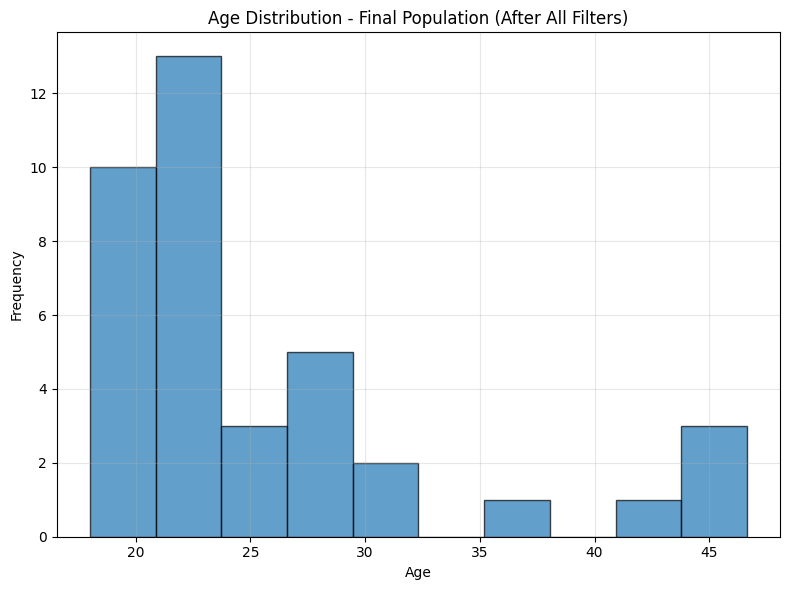


=== DATAFRAMES READY FOR NEXT STEPS ===
main_df_final: 38 subjects (filtered main population)
sp_df: 14 subjects (SP population for later use)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set up paths relative to the multiecho-pilot directory
# This will work across different operating systems and user setups
project_root = Path.cwd()
while project_root.name != 'multiecho-pilot' and project_root.parent != project_root:
    project_root = project_root.parent
    
if project_root.name != 'multiecho-pilot':
    raise ValueError("Could not find 'multiecho-pilot' directory. Please run this script from within the project directory.")

# Define file paths relative to project root
demographics_path = project_root / 'code' / 'multiecho-pilot_Demographics.xlsx'
outlier_path = project_root / 'derivatives' / 'Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv'

# Read the demographics Excel file
print(f"Loading demographics from: {demographics_path}")
df = pd.read_excel(demographics_path)

# Separate data based on spSubs column
sp_df = df[df['spSubs'] == 1].copy()
main_df = df[df['spSubs'] == 0].copy()

print(f"\nInitial separation:")
print(f"- SP subjects (spSubs=1): {len(sp_df)} subjects")
print(f"- Main subjects (spSubs=0): {len(main_df)} subjects")

# Print initial statistics for main population
print("\n=== MAIN POPULATION (spSubs=0) - ALL SUBJECTS ===")
print(f"Total N: {len(main_df)}")  # Since OpenNeuro is binary and all are 1
print(f"Age: Mean = {main_df['Age'].mean():.1f}, SD = {main_df['Age'].std():.1f}")

# Filter 1: Remove subjects with SixRuns = 0
main_df_filtered = main_df[main_df['SixRuns'] != 0].copy()
subjects_removed_sixruns = len(main_df) - len(main_df_filtered)

print("\n=== AFTER REMOVING SixRuns=0 ===")
print(f"Removed {subjects_removed_sixruns} subjects")
print(f"Total N: {len(main_df_filtered)}")
print(f"Age: Mean = {main_df_filtered['Age'].mean():.1f}, SD = {main_df_filtered['Age'].std():.1f}")

# Filter 2: Remove subjects with motion outliers
print("\n=== MOTION OUTLIER ANALYSIS ===")
print(f"Loading outlier data from: {outlier_path}")

# Read the outlier TSV file
outlier_df = pd.read_csv(outlier_path, sep='\t')
print(f"Successfully loaded {len(outlier_df)} rows")

# Find outlier runs (where outlier_acq_Custom1 is True)
outlier_runs = outlier_df[outlier_df['outlier_acq_Custom1'] == True]
print(f"\nTotal outlier runs identified: {len(outlier_runs)}")

if len(outlier_runs) > 0:
    # Extract unique subject IDs from outlier runs
    outlier_subjects_raw = outlier_runs['Sub'].unique()
    print(f"Unique subjects with outlier runs: {len(outlier_subjects_raw)}")
    
    # Convert outlier subject IDs to match demographics format
    # Remove 'sub-' prefix but keep the full ID (including 'sp' suffix if present)
    outlier_subjects_clean = []
    for sub in outlier_subjects_raw:
        if sub.startswith('sub-'):
            clean_id = sub.replace('sub-', '')
            outlier_subjects_clean.append(clean_id)
    
    print(f"Outlier subjects (cleaned IDs): {sorted(outlier_subjects_clean)}")
    
    # Since demographics Subject column can be either numeric or string with 'sp' suffix,
    # we need to convert to string for comparison
    main_df_filtered['Subject_str'] = main_df_filtered['Subject'].astype(str)
    
    # Remove subjects with outlier runs from main_df_filtered
    main_df_final = main_df_filtered[~main_df_filtered['Subject_str'].isin(outlier_subjects_clean)].copy()
    
    # Drop the temporary string column
    main_df_final = main_df_final.drop(columns=['Subject_str'])
    subjects_removed_outliers = len(main_df_filtered) - len(main_df_final)
    print(f"Removed {subjects_removed_outliers} subjects due to motion outliers")
else:
    print("No outlier runs found.")
    main_df_final = main_df_filtered.copy()
    subjects_removed_outliers = 0

# Print final statistics
print("\n=== FINAL POPULATION (After All Filters) ===")
print(f"Total N: {len(main_df_final)}")
print(f"Age: Mean = {main_df_final['Age'].mean():.1f}, SD = {main_df_final['Age'].std():.1f}")

# Print breakdown by Headcoil
print(f"\nBreakdown by Headcoil:")
headcoil_counts = main_df_final['Headcoil'].value_counts().sort_index()
for headcoil, count in headcoil_counts.items():
    print(f"- Headcoil {headcoil}: N = {count}")

# Summary of filtering
print("\n=== FILTERING SUMMARY ===")
print(f"Initial main subjects: {len(main_df)}")
print(f"Removed due to SixRuns=0: {subjects_removed_sixruns}")
print(f"Removed due to motion outliers: {subjects_removed_outliers}")
print(f"Final sample size: {len(main_df_final)}")

# Create histogram of age for final filtered population
plt.figure(figsize=(8, 6))
plt.hist(main_df_final['Age'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution - Final Population (After All Filters)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Store the key dataframes for use in subsequent kernels
print("\n=== DATAFRAMES READY FOR NEXT STEPS ===")
print(f"main_df_final: {len(main_df_final)} subjects (filtered main population)")
print(f"sp_df: {len(sp_df)} subjects (SP population for later use)")

# Spatial Smoothness Analysis
This kernel analyzes spatial smoothness in fMRI data before and after preprocessing by:
1. **Loading smoothness measurements** from two CSV files (pre- and post-smoothing)
2. **Filtering subjects** to include only those from the main study population with complete data
3. **Running Linear Mixed Effects models** to test effects of:
   - Headcoil type (20 vs 64 channel)
   - Multiband acceleration factor (mb1, mb3, mb6)
   - Multi-echo acquisition (me1, me4)
   - All interactions between these factors
4. **Generating visualizations** in a 2×2 subplot layout showing:
   - Top row: Pre-smoothing spatial smoothness
   - Bottom row: Post-smoothing spatial smoothness
   - Columns separated by headcoil type
5. **Saving outputs** to `derivatives/plots/` including:
   - APA-formatted ANOVA tables
   - Complete subject lists
   - Combined bar plot figure

The analysis quantifies how acquisition parameters affect spatial smoothness and the impact of preprocessing.

SMOOTHNESS ANALYSIS PIPELINE - PRE AND POST SMOOTHING
Filtering to 38 subjects from main population
Pre-smoothing file: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv
Post-smoothing file: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/smoothness-all.csv
Output directory: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots

PART 1: PRE-SMOOTHING DATA ANALYSIS

Pre-smoothing complete subjects: 38
  - 20-channel headcoil: 16
  - 64-channel headcoil: 22
Complete subjects table saved to '/Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots/complete_subjects_smoothness_pre_with_headcoil.csv'

Running LME analysis for pre-smoothing data
Observations: 228, Subjects: 38
Linear mixed model fit by REML [’lmerMod’]
Formula: smoothness~headcoil*mb*me+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 228	 Groups: {'subject': 38.0}

Log-likelihood: 266.879 	 AIC: -505.759

Random effects:


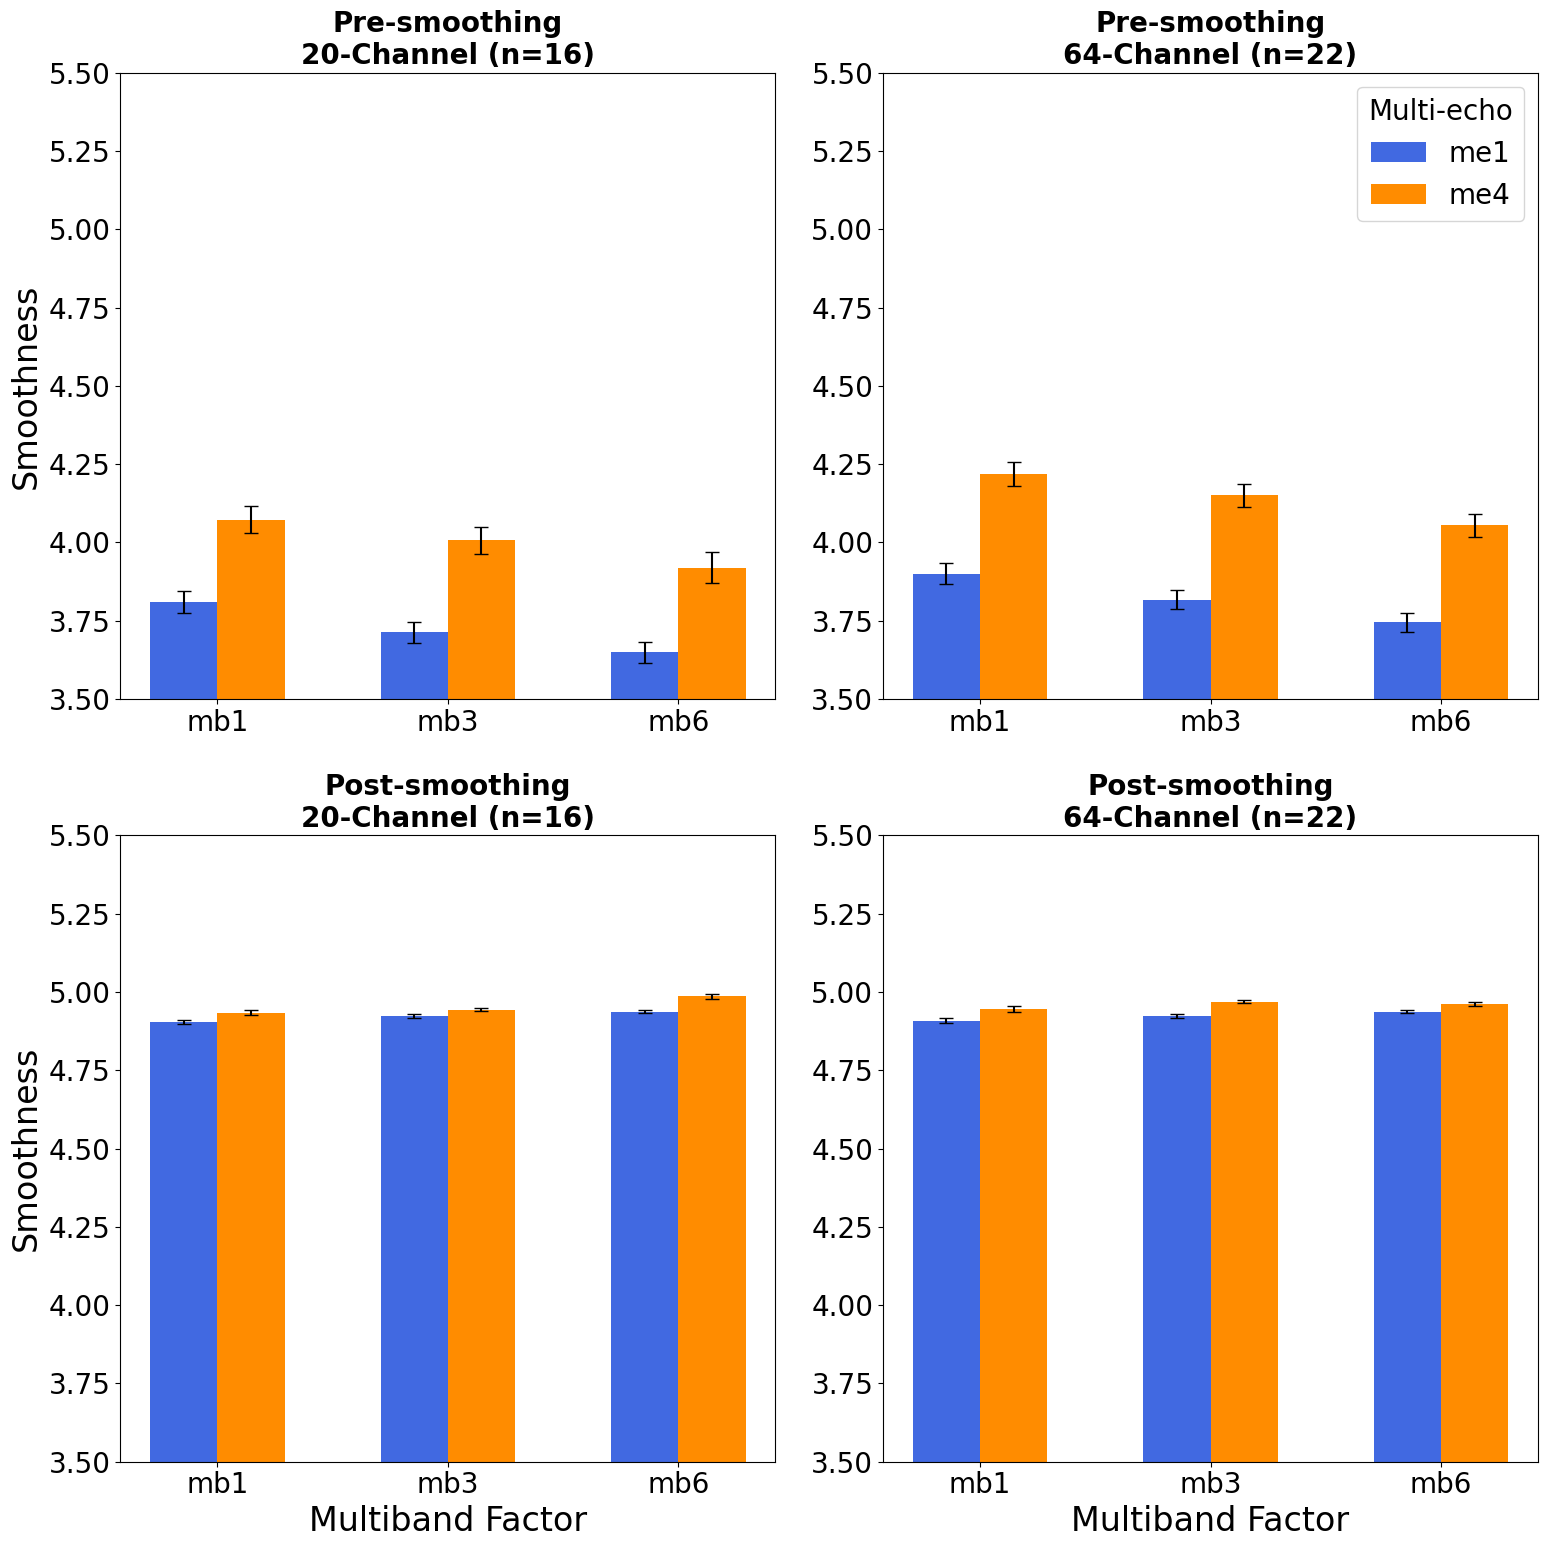


ANALYSIS COMPLETE - SUMMARY

Pre-smoothing data:
  Complete subjects: 38
  - 20-channel: 16
  - 64-channel: 22

Post-smoothing data:
  Complete subjects: 38
  - 20-channel: 16
  - 64-channel: 22

Files generated in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots:
  - complete_subjects_smoothness_pre_with_headcoil.csv
  - complete_subjects_smoothness_post_with_headcoil.csv
  - smoothness_pre_lme_anova_complete_subjects.csv
  - smoothness_post_lme_anova_complete_subjects.csv
  - smoothness_combined_bar_plot.png


In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import warnings
from pymer4.models import Lmer
from pathlib import Path

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")

print("=" * 80)
print("SMOOTHNESS ANALYSIS PIPELINE - PRE AND POST SMOOTHING")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths to both CSV files
csv_path_pre = Path(os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv'))
csv_path_post = Path(os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv'))

# Create output directory if it doesn't exist
output_dir = Path(os.path.expanduser('~/Documents/GitHub/multiecho-pilot/derivatives/plots'))
output_dir.mkdir(parents=True, exist_ok=True)

# Get valid subjects and headcoil information from main_df_final
valid_subjects = main_df_final['Subject'].astype(str).tolist()
headcoil_mapping = dict(zip(main_df_final['Subject'].astype(str), 
                           main_df_final['Headcoil'].astype(str)))

print(f"Filtering to {len(valid_subjects)} subjects from main population")

# Output file names
complete_subjects_file_pre = output_dir / 'complete_subjects_smoothness_pre_with_headcoil.csv'
complete_subjects_file_post = output_dir / 'complete_subjects_smoothness_post_with_headcoil.csv'
anova_table_file_pre = output_dir / 'smoothness_pre_lme_anova_complete_subjects.csv'
anova_table_file_post = output_dir / 'smoothness_post_lme_anova_complete_subjects.csv'
combined_plot_file = output_dir / 'smoothness_combined_bar_plot.png'

print(f"Pre-smoothing file: {csv_path_pre}")
print(f"Post-smoothing file: {csv_path_post}")
print(f"Output directory: {output_dir}")

# ============================================================================
# SHARED FUNCTIONS
# ============================================================================

def load_and_process_data(csv_path, valid_subjects, headcoil_mapping):
    """Load and process the CSV file with shift-up correction"""
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns for clarity
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift up procedure to align smoothness values with correct acquisition
        data['file_path'] = data['path'].shift(1)
        
        # Filter rows with non-null smoothness and file_path
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, and me from file_path
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]  # e.g., mb1
                    me = acq[3:]  # e.g., me1
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception as e:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        
        # Filter to only include valid subjects from main_df_final
        data = data[data['subject'].isin(valid_subjects)]
        
        # Assign headcoil based on mapping from main_df_final
        data['headcoil'] = data['subject'].map(headcoil_mapping)
        
        # Select relevant columns
        data = data[['subject', 'headcoil', 'mb', 'me', 'smoothness']]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        # Filter out invalid rows
        data = data.dropna(subset=['subject', 'mb', 'me', 'smoothness'])
        
        return data
        
    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}")
        return None
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

def identify_complete_subjects(data):
    """Identify subjects with complete data across all 6 acquisitions"""
    # Create a combined mb_me column for pivoting
    data['mb_me'] = data['mb'].astype(str) + data['me'].astype(str)
    
    # Pivot the data to create a table with subjects as rows and mb_me combinations as columns
    pivot_table = data.pivot_table(
        values='smoothness',
        index='subject',
        columns='mb_me',
        aggfunc='mean'  # In case of duplicates, take the mean
    )
    
    # Ensure all expected mb_me combinations are present as columns
    expected_columns = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    pivot_table = pivot_table.reindex(columns=expected_columns)
    
    # Identify subjects with no NaN values across all mb_me columns
    complete_subjects = pivot_table.dropna()
    
    # Sort the index (subjects) for consistency
    complete_subjects = complete_subjects.sort_index()
    
    # Round smoothness values to 3 decimal places for readability
    complete_subjects = complete_subjects.round(3)
    
    # Get headcoil information for complete subjects
    headcoil_data = data[['subject', 'headcoil']].drop_duplicates().set_index('subject')
    complete_headcoil = headcoil_data.loc[complete_subjects.index].astype(str)
    
    # Add headcoil as a column to the complete subjects table
    complete_subjects = complete_subjects.reset_index().merge(
        complete_headcoil[['headcoil']].reset_index(),
        on='subject',
        how='left'
    ).set_index('subject')
    
    # Reorder columns to have headcoil first
    cols = ['headcoil'] + expected_columns
    complete_subjects = complete_subjects[cols]
    
    return complete_subjects

def run_lme_analysis(data_complete, label):
    """Run Linear Mixed Effects analysis and return results"""
    print(f"\nRunning LME analysis for {label} data")
    print(f"Observations: {len(data_complete)}, Subjects: {data_complete['subject'].nunique()}")
    
    # Prepare data for LME model with sum-to-zero contrasts
    data_model = data_complete.copy()
    data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
    
    # Fit the LME model
    model = Lmer('smoothness ~ headcoil * mb * me + (1 | subject)', data=data_model)
    model.fit()
    
    # Get ANOVA table
    anova_table = model.anova()
    
    # Define effect names and numerator df for APA table
    effect_map = {
        'headcoil': 'Head Coil',
        'mb': 'Multiband',
        'me': 'Multi-echo',
        'headcoil:mb': 'Head Coil × Multiband',
        'headcoil:me': 'Head Coil × Multi-echo',
        'mb:me': 'Multiband × Multi-echo',
        'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
    }
    
    df_dict = {
        'Head Coil': 1,
        'Multiband': 2,
        'Multi-echo': 1,
        'Head Coil × Multiband': 2,
        'Head Coil × Multi-echo': 1,
        'Multiband × Multi-echo': 2,
        'Head Coil × Multiband × Multi-echo': 2
    }
    
    # Build APA table
    apa_data = []
    for effect in anova_table.index:
        if effect in ['(Intercept)', 'Residuals']:
            continue
        effect_name = effect_map.get(effect, effect)
        apa_data.append({
            'Effect': effect_name,
            'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
            'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
            'Num df': df_dict.get(effect_name, np.nan),
            'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
            'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
            'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
            'Partial η²': np.nan  # Computed below
        })
    
    # Compute partial eta-squared
    try:
        residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
    except (KeyError, IndexError):
        residual_var = model.ranef_var.iloc[1]['Var']
    
    n_obs = len(data_model)
    n_fixed = sum(df_dict.values())
    n_subj = data_model['subject'].nunique()
    ss_residual = residual_var * (n_obs - n_fixed - n_subj)
    
    for i, row in enumerate(apa_data):
        ss_effect = row['Sum Sq']
        if pd.notna(ss_effect):
            apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    
    # Create APA table
    apa_table = pd.DataFrame(apa_data)
    apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
    apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
    apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
    apa_table['Den df'] = apa_table['Den df'].round(2)
    apa_table['F'] = apa_table['F'].round(2)
    apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
    apa_table['Partial η²'] = apa_table['Partial η²'].round(3)
    
    return apa_table

def process_data_for_plotting(data, value_column='smoothness'):
    """Calculate mean and standard error by multiband, multi-echo, and headcoil"""
    if data is None or data.empty:
        return pd.DataFrame()
    
    data = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data.empty:
        return pd.DataFrame()
    
    agg_data = data.groupby(['mb', 'me', 'headcoil'], observed=True).agg({
        value_column: 'mean',
        'subject': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'headcoil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    return result

# ============================================================================
# PART 1: PROCESS PRE-SMOOTHING DATA
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: PRE-SMOOTHING DATA ANALYSIS")
print("=" * 80)

# Load and process pre-smoothing data
data_pre = load_and_process_data(csv_path_pre, valid_subjects, headcoil_mapping)

if data_pre is None:
    raise Exception("Failed to load pre-smoothing data. Stopping execution.")

# Identify complete subjects
complete_subjects_table_pre = identify_complete_subjects(data_pre)
total_n_pre = len(complete_subjects_table_pre)
headcoil_counts_pre = complete_subjects_table_pre['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nPre-smoothing complete subjects: {total_n_pre}")
print(f"  - 20-channel headcoil: {headcoil_counts_pre['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_pre['64']}")

# Save complete subjects table
complete_subjects_table_pre.to_csv(complete_subjects_file_pre)
print(f"Complete subjects table saved to '{complete_subjects_file_pre}'")

# Filter data to complete subjects only
complete_subject_list_pre = [str(subj) for subj in complete_subjects_table_pre.index.tolist()]
data_complete_pre = data_pre[data_pre['subject'].isin(complete_subject_list_pre)]

# Run LME analysis
apa_table_pre = run_lme_analysis(data_complete_pre, "pre-smoothing")
print("\nAPA-Style ANOVA Table for Pre-smoothing Data:")
print(apa_table_pre.to_string(index=False))
apa_table_pre.to_csv(anova_table_file_pre, index=False)

# ============================================================================
# PART 2: PROCESS POST-SMOOTHING DATA
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: POST-SMOOTHING DATA ANALYSIS")
print("=" * 80)

# Load and process post-smoothing data
data_post = load_and_process_data(csv_path_post, valid_subjects, headcoil_mapping)

if data_post is None:
    raise Exception("Failed to load post-smoothing data. Stopping execution.")

# Identify complete subjects
complete_subjects_table_post = identify_complete_subjects(data_post)
total_n_post = len(complete_subjects_table_post)
headcoil_counts_post = complete_subjects_table_post['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nPost-smoothing complete subjects: {total_n_post}")
print(f"  - 20-channel headcoil: {headcoil_counts_post['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_post['64']}")

# Save complete subjects table
complete_subjects_table_post.to_csv(complete_subjects_file_post)
print(f"Complete subjects table saved to '{complete_subjects_file_post}'")

# Filter data to complete subjects only
complete_subject_list_post = [str(subj) for subj in complete_subjects_table_post.index.tolist()]
data_complete_post = data_post[data_post['subject'].isin(complete_subject_list_post)]

# Run LME analysis
apa_table_post = run_lme_analysis(data_complete_post, "post-smoothing")
print("\nAPA-Style ANOVA Table for Post-smoothing Data:")
print(apa_table_post.to_string(index=False))
apa_table_post.to_csv(anova_table_file_post, index=False)

# ============================================================================
# PART 3: COMBINED VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING COMBINED BAR PLOTS")
print("=" * 80)

# Process data for plotting
smoothness_processed_pre = process_data_for_plotting(data_complete_pre, 'smoothness')
smoothness_processed_post = process_data_for_plotting(data_complete_post, 'smoothness')

# Get n_subjects per coil for both datasets
n_subjects_per_coil_pre = data_complete_pre.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
n_subjects_per_coil_post = data_complete_post.groupby('headcoil', observed=True)['subject'].nunique().to_dict()

# Create combined 2x2 plot
plt.rcParams.update({'font.size': 24})  # Reduced from 48 for better fit in 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

width = 0.35
x1 = [0, 1.2, 2.4]
x2 = [x + width for x in x1]
me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
mb_levels = ['mb1', 'mb3', 'mb6']

# Set consistent y-axis limits for all subplots
y_limits = (3.5, 5.5)

# Function to plot data in a subplot
def plot_smoothness_data(ax, data_processed, n_subjects_per_coil, headcoil, title_prefix):
    """Plot smoothness data for a specific headcoil"""
    
    coil_data = data_processed[data_processed['headcoil'] == headcoil]
    
    if coil_data.empty:
        ax.set_title(f"{title_prefix}\n{headcoil}-Channel (n=0)", fontsize=20, fontweight='bold')
        ax.set_ylim(y_limits)
        return
    
    me1_data = coil_data[coil_data['me'] == 'me1']
    me4_data = coil_data[coil_data['me'] == 'me4']
    
    me1_means = me1_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
    me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
    me4_means = me4_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
    me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
    
    ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
           yerr=me1_errors, capsize=5)
    ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
           yerr=me4_errors, capsize=5)
    
    ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
    ax.set_xticklabels(mb_levels, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    n_subjects = n_subjects_per_coil.get(headcoil, 0)
    ax.set_title(f"{title_prefix}\n{headcoil}-Channel (n={n_subjects})", fontsize=20, fontweight='bold')
    ax.set_ylim(y_limits)

# Plot data in 2x2 layout
# Top row: Pre-smoothing
plot_smoothness_data(axes[0, 0], smoothness_processed_pre, n_subjects_per_coil_pre, '20', 'Pre-smoothing')
plot_smoothness_data(axes[0, 1], smoothness_processed_pre, n_subjects_per_coil_pre, '64', 'Pre-smoothing')

# Bottom row: Post-smoothing
plot_smoothness_data(axes[1, 0], smoothness_processed_post, n_subjects_per_coil_post, '20', 'Post-smoothing')
plot_smoothness_data(axes[1, 1], smoothness_processed_post, n_subjects_per_coil_post, '64', 'Post-smoothing')

# Add labels
axes[0, 0].set_ylabel('Smoothness', fontsize=24)
axes[1, 0].set_ylabel('Smoothness', fontsize=24)
axes[1, 0].set_xlabel('Multiband Factor', fontsize=24)
axes[1, 1].set_xlabel('Multiband Factor', fontsize=24)

# Add legend to the top right subplot
axes[0, 1].legend(title='Multi-echo', fontsize=20, title_fontsize=20, 
                  loc='upper right')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(combined_plot_file, dpi=300, bbox_inches='tight')
print(f"Combined plot saved to '{combined_plot_file}'")

plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"\nPre-smoothing data:")
print(f"  Complete subjects: {total_n_pre}")
print(f"  - 20-channel: {headcoil_counts_pre['20']}")
print(f"  - 64-channel: {headcoil_counts_pre['64']}")
print(f"\nPost-smoothing data:")
print(f"  Complete subjects: {total_n_post}")
print(f"  - 20-channel: {headcoil_counts_post['20']}")
print(f"  - 64-channel: {headcoil_counts_post['64']}")
print(f"\nFiles generated in {output_dir}:")
print(f"  - {complete_subjects_file_pre.name}")
print(f"  - {complete_subjects_file_post.name}")
print(f"  - {anova_table_file_pre.name}")
print(f"  - {anova_table_file_post.name}")
print(f"  - {combined_plot_file.name}")
print("=" * 80)

# Load Smoothness Data

In [ ]:
# Newer kernel
# Load and process smoothness data to identify complete subjects
# This kernel builds off the previous demographic analysis

import os
import re
import warnings

# Suppress FutureWarning from pandas if needed
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv')

print("=== SMOOTHNESS DATA ANALYSIS ===")
print(f"Final demographic sample size: {len(main_df_final)} subjects")

# Load and process the CSV file
try:
    smoothness_data = pd.read_csv(csv_path)
    
    # Rename columns for clarity
    smoothness_data = smoothness_data.rename(columns={
        smoothness_data.columns[0]: 'path',
        'Unnamed: 3': 'smoothness'
    })
    
    # Apply shift up procedure to align smoothness values with correct acquisition
    smoothness_data['file_path'] = smoothness_data['path'].shift(1)
    
    # Filter rows with non-null smoothness and file_path
    smoothness_data = smoothness_data[smoothness_data['smoothness'].notnull() & smoothness_data['file_path'].notnull()]
    
    # Extract subject, mb, and me from file_path
    def parse_path(path):
        try:
            if not isinstance(path, str):
                return pd.Series({'subject': None, 'mb': None, 'me': None})
            sub_match = re.search(r'sub-(\d+)', path)
            acq_match = re.search(r'acq-(mb\dme\d)', path)
            subject = sub_match.group(1) if sub_match else None
            acq = acq_match.group(1) if acq_match else None
            if acq:
                mb = acq[:3]  # e.g., mb1
                me = acq[3:]  # e.g., me1
            else:
                mb = None
                me = None
            return pd.Series({'subject': subject, 'mb': mb, 'me': me})
        except Exception as e:
            return pd.Series({'subject': None, 'mb': None, 'me': None})
    
    parsed_data = smoothness_data['file_path'].apply(parse_path)
    smoothness_data = pd.concat([smoothness_data, parsed_data], axis=1)
    
    # Filter out invalid rows
    smoothness_data = smoothness_data.dropna(subset=['subject', 'mb', 'me', 'smoothness'])
    smoothness_data = smoothness_data[~smoothness_data['subject'].str.contains('sp', na=False)]
    smoothness_data = smoothness_data[smoothness_data['subject'] != 'nan']
    
    # Convert subject to int for matching with demographics data
    smoothness_data['subject_int'] = smoothness_data['subject'].astype(int)
    
    print(f"Smoothness data loaded: {len(smoothness_data['subject_int'].unique())} unique subjects")
    
    # Match subjects between demographics and smoothness data
    demo_subjects = set(main_df_final[subject_id_col].unique())
    smoothness_subjects = set(smoothness_data['subject_int'].unique())
    
    # Find subjects in smoothness data but not in demographics
    extra_smoothness_subjects = smoothness_subjects - demo_subjects
    # Find subjects in demographics but not in smoothness data
    missing_smoothness_subjects = demo_subjects - smoothness_subjects
    # Find subjects in both datasets
    common_subjects = demo_subjects & smoothness_subjects
    
    print(f"\nSubject matching results:")
    print(f"- Subjects in demographics: {len(demo_subjects)}")
    print(f"- Subjects in smoothness data: {len(smoothness_subjects)}")
    print(f"- Subjects in both datasets: {len(common_subjects)}")
    print(f"- Subjects only in smoothness data: {len(extra_smoothness_subjects)}")
    print(f"- Subjects only in demographics data: {len(missing_smoothness_subjects)}")
    
    if extra_smoothness_subjects:
        print(f"\nSubjects in smoothness data but not in final demographics (will be excluded):")
        for sub in sorted(extra_smoothness_subjects):
            print(f"  - {sub}")
    
    if missing_smoothness_subjects:
        print(f"\nSubjects in demographics but missing from smoothness data:")
        for sub in sorted(missing_smoothness_subjects):
            print(f"  - {sub}")
    
    # Filter smoothness data to only include subjects from demographics
    smoothness_data_matched = smoothness_data[smoothness_data['subject_int'].isin(common_subjects)].copy()
    print(f"\nFiltered smoothness data to {len(smoothness_data_matched['subject_int'].unique())} subjects matching demographics")
    
    # Get headcoil information from demographics data
    demo_headcoil_map = dict(zip(main_df_final[subject_id_col], main_df_final['Headcoil']))
    smoothness_data_matched['headcoil'] = smoothness_data_matched['subject_int'].map(demo_headcoil_map)
    
    # Convert to appropriate data types
    smoothness_data_matched['headcoil'] = pd.Categorical(smoothness_data_matched['headcoil'], categories=[20, 64])
    smoothness_data_matched['mb'] = pd.Categorical(smoothness_data_matched['mb'], categories=['mb1', 'mb3', 'mb6'])
    smoothness_data_matched['me'] = pd.Categorical(smoothness_data_matched['me'], categories=['me1', 'me4'])
    
    # Create a combined mb_me column for pivoting
    smoothness_data_matched['mb_me'] = smoothness_data_matched['mb'].astype(str) + smoothness_data_matched['me'].astype(str)
    
    # Pivot the data to create a table with subjects as rows and mb_me combinations as columns
    pivot_table = smoothness_data_matched.pivot_table(
        values='smoothness',
        index='subject_int',
        columns='mb_me',
        aggfunc='mean'  # In case of duplicates, take the mean
    )
    
    # Ensure all expected mb_me combinations are present as columns
    expected_columns = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    pivot_table = pivot_table.reindex(columns=expected_columns)
    
    # Identify subjects with no NaN values across all mb_me columns
    complete_subjects = pivot_table.dropna()
    
    # Sort the index (subjects) for consistency
    complete_subjects = complete_subjects.sort_index()
    
    # Round smoothness values to 3 decimal places for readability
    complete_subjects = complete_subjects.round(3)
    
    # Get headcoil information for complete subjects
    complete_headcoil = pd.DataFrame({
        'headcoil': [demo_headcoil_map.get(sub, None) for sub in complete_subjects.index]
    }, index=complete_subjects.index)
    
    # Calculate total N and N per headcoil
    total_n = len(complete_subjects)
    headcoil_counts = complete_headcoil['headcoil'].value_counts().reindex([20, 64], fill_value=0)
    
    # Add headcoil as a column to the complete subjects table
    complete_subjects = complete_subjects.reset_index().merge(
        complete_headcoil.reset_index(),
        left_on='subject_int', 
        right_on='subject_int',
        how='left'
    ).set_index('subject_int')
    
    # Reorder columns to have headcoil first
    cols = ['headcoil'] + expected_columns
    complete_subjects = complete_subjects[cols]
    
    # Display results
    print("\n=== SUBJECTS WITH COMPLETE SMOOTHNESS DATA ===")
    print("Subjects with Complete Data for All 6 Acquisitions (mb1me1, mb3me1, mb6me1, mb1me4, mb3me4, mb6me4):")
    print(f"Total N: {total_n}")
    print("\nN per Headcoil:")
    print(f"  Headcoil 20: {headcoil_counts[20]}")
    print(f"  Headcoil 64: {headcoil_counts[64]}")
    
    if complete_subjects.empty:
        print("\nNo subjects have complete data for all 6 acquisitions.")
    else:
        print(f"\nFound {total_n} subjects with complete data:")
        print(sorted(complete_subjects.index.tolist()))
        print("\nSmoothness Values for Complete Subjects (with Headcoil):")
        print(complete_subjects.to_string())
    
    # Save the complete subjects table to a CSV file for future use
    complete_subjects.to_csv('complete_subjects_smoothness_with_headcoil.csv')
    print(f"\nSaved complete subjects data to 'complete_subjects_smoothness_with_headcoil.csv'")
    
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"Error processing data: {str(e)}")

## Pre-smoothing statistics

In [ ]:
# Newer pre-smoothing statistics
# Run LME analysis on complete subjects with shift-up corrected data
# This kernel builds off the previous smoothness analysis

from pymer4.models import Lmer

# Use the complete subjects data from the previous kernel
complete_subject_list = [str(subj) for subj in complete_subjects.index.tolist()]  # Ensure strings
print(f"Loaded {len(complete_subject_list)} complete subjects for analysis")
print(f"Complete subjects (first 10): {complete_subject_list[:10]}")

# Use the already processed and matched smoothness data from previous kernel
print(f"Running LME analysis on {len(smoothness_data_matched)} observations from {smoothness_data_matched['subject_int'].nunique()} subjects")

# Filter to only complete subjects and prepare for LME model
data_model = smoothness_data_matched[smoothness_data_matched['subject_int'].isin([int(s) for s in complete_subject_list])].copy()

# Convert subject back to string for model
data_model['subject'] = data_model['subject_int'].astype(str)

# Prepare data for LME model with sum-to-zero contrasts
data_model['headcoil_contrast'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5

print(f"Final model data: {len(data_model)} observations from {data_model['subject'].nunique()} subjects")

# Fit the LME model
model = Lmer('smoothness ~ headcoil_contrast * mb * me + (1 | subject)', data=data_model)
model.fit()

# Get ANOVA table
anova_table = model.anova()

# Define effect names and numerator df for APA table
effect_map = {
    'headcoil_contrast': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil_contrast:mb': 'Head Coil × Multiband',
    'headcoil_contrast:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil_contrast:mb:me': 'Head Coil × Multiband × Multi-echo'
}

df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError):
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display results
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model:")
print("Model: smoothness ~ headcoil * mb * me + (1 | subject)")
print(f"Data: Complete subjects only (N = {data_model['subject'].nunique()}), shift-up corrected\n")
print(apa_table.to_string(index=False))

# Save APA table
apa_table.to_csv('smoothness_lme_anova_complete_subjects.csv', index=False)
print(f"\nAPA table saved to 'smoothness_lme_anova_complete_subjects.csv'")

# Pre-smoothing Bar Plot

In [ ]:
# Kernel 3: Generate bar plots using shift-up corrected data from complete subjects
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Debug: Verify Matplotlib backend
print(f"Matplotlib backend: {matplotlib.get_backend()}")

def load_and_process_shifted_data():
    """
    Load and process the CSV data with shift-up correction, filtering to complete subjects only
    """
    print("Loading and processing shift-up corrected data...")
    
    # Load complete subjects list
    try:
        complete_subjects_table = pd.read_csv('complete_subjects_smoothness_with_headcoil.csv', index_col=0)
        complete_subject_list = [str(subj) for subj in complete_subjects_table.index.tolist()]
        print(f"Loaded {len(complete_subject_list)} complete subjects for plotting")
    except FileNotFoundError:
        print("Error: Please run kernels 1 and 2 first to generate complete subjects data")
        return None
    
    # Load and process original data with shift-up correction
    csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv')
    
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns for clarity
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift up procedure to align smoothness values with correct acquisition
        data['file_path'] = data['path'].shift(1)
        
        # Filter rows with non-null smoothness and file_path
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, and me from file_path
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]  # e.g., mb1
                    me = acq[3:]  # e.g., me1
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception as e:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        
        # Filter to only complete subjects
        data = data[data['subject'].isin(complete_subject_list)]
        
        # Assign headcoil information
        HEADCOIL_64_SUBJECTS = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
            "10186", "10188", "10221"
        ]
        data['headcoil'] = data['subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20' if x else None)
        
        # Select relevant columns and clean data
        data = data[['subject', 'headcoil', 'mb', 'me', 'smoothness']].dropna()
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        
        # Convert to appropriate data types
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        print(f"Processed data: {len(data)} observations from {data['subject'].nunique()} subjects")
        print("Data columns:", data.columns.tolist())
        print("Unique headcoil values:", data['headcoil'].unique())
        print("Unique mb values:", data['mb'].unique())
        print("Unique me values:", data['me'].unique())
        
        return data
        
    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}")
        return None
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

def process_data_for_plotting(data, value_column='smoothness'):
    """
    Calculate mean and standard error by multiband, multi-echo, and headcoil
    """
    print("\nProcessing data for plotting...")
    
    if data is None or data.empty:
        print("Error: Data is None or empty. Cannot process.")
        return pd.DataFrame()
    
    # Debug: Check input data
    print("Input data shape:", data.shape)
    print("Number of unique subjects:", data['subject'].nunique())
    
    data = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data.empty:
        print("Error: Data is empty after dropping NaNs. Cannot process.")
        return pd.DataFrame()
    
    agg_data = data.groupby(['mb', 'me', 'headcoil'], observed=True).agg({
        value_column: 'mean',
        'subject': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'headcoil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    # Debug: Check processed data
    print("Processed data shape:", result.shape)
    print("Processed data:\n", result)
    
    return result

def create_smoothness_bar_plots(data_processed, n_subjects_per_coil, save_files=True):
    """
    Create bar plots for smoothness with identical y-axis scales across subplots
    """
    print("\nCreating bar plots...")
    if data_processed.empty:
        print("Error: Processed data is empty. Cannot create plots.")
        return None
    
    plt.rcParams.update({'font.size': 48})
    coil_types = sorted(data_processed['headcoil'].unique())  # Sort for consistency
    print(f"Plotting for coil types: {coil_types}")
    
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = data_processed[data_processed['headcoil'] == coil]
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
    
    # Calculate global y-axis limits
    if all_y_values:
        #y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        #y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        y_max = 5
        y_min = 3.5
        margin = (y_max - y_min) * 0.1  # Add 10% margin
        y_limits = (max(0, y_min - margin), y_max + margin)
        print(f"Y-axis limits: {y_limits}")
    else:
        y_limits = (0, 1)
        print("Warning: No valid y-values found. Using default y-limits:", y_limits)
    
    # Plot each subplot with consistent y-axis
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['headcoil'] == coil]
        if coil_data.empty:
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            ax.set_ylim(y_limits)
            print(f"No data for coil {coil}")
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel('Smoothness', fontsize=48)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    if save_files:
        plt.savefig('smoothness_bar_plot_shift_corrected.png', dpi=300, bbox_inches='tight')
        print("Plot saved to 'smoothness_bar_plot_shift_corrected.png'")
    
    # Explicitly show the plot
    plt.show()
    
    return fig

# Main execution
print("Starting Kernel 3: Bar plot generation with shift-up corrected data")

# Load the shift-up corrected data for complete subjects only
data_corrected = load_and_process_shifted_data()

if data_corrected is not None and not data_corrected.empty:
    # Compute n_subjects_per_coil from corrected data
    n_subjects_per_coil = data_corrected.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
    print("Subjects per coil:", n_subjects_per_coil)
    
    # Process data for plotting
    smoothness_processed = process_data_for_plotting(data_corrected, 'smoothness')
    
    # Create bar plots
    if not smoothness_processed.empty:
        fig = create_smoothness_bar_plots(smoothness_processed, n_subjects_per_coil)
        print("Bar plot generation complete with shift-up corrected data!")
    else:
        print("Error: Failed to process data for plotting.")
else:
    print("Error: Failed to load corrected data. Please ensure kernels 1 and 2 have been run successfully.")

# Post-smoothing loading, stats, and plots
Loads data, generates LME stats, and bar plots for the 

In [ ]:
# Combined Kernel: Complete smoothness analysis pipeline
# Processes data, identifies complete subjects, runs LME analysis, and generates plots

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import warnings
from pymer4.models import Lmer

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")

print("=" * 80)
print("SMOOTHNESS ANALYSIS PIPELINE")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Output file names
complete_subjects_file = 'complete_subjects_smoothness_all_with_headcoil.csv'
anova_table_file = 'smoothness_all_lme_anova_complete_subjects.csv'
plot_file = 'smoothness_all_bar_plot_shift_corrected.png'

print(f"Input file: {csv_path}")
print(f"Processing smoothness-all.csv data...")

# ============================================================================
# PART 1: DATA PROCESSING AND COMPLETE SUBJECT IDENTIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: IDENTIFYING COMPLETE SUBJECTS")
print("=" * 80)

def load_and_process_data(csv_path):
    """Load and process the CSV file with shift-up correction"""
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns for clarity
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift up procedure to align smoothness values with correct acquisition
        data['file_path'] = data['path'].shift(1)
        
        # Filter rows with non-null smoothness and file_path
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, and me from file_path
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]  # e.g., mb1
                    me = acq[3:]  # e.g., me1
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception as e:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        
        # Assign headcoil
        data['headcoil'] = data['subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20' if x else None)
        
        # Select relevant columns
        data = data[['subject', 'headcoil', 'mb', 'me', 'smoothness']]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        # Filter out invalid rows
        data = data.dropna(subset=['subject', 'mb', 'me', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        
        return data
        
    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}")
        return None
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

def identify_complete_subjects(data):
    """Identify subjects with complete data across all 6 acquisitions"""
    # Create a combined mb_me column for pivoting
    data['mb_me'] = data['mb'].astype(str) + data['me'].astype(str)
    
    # Pivot the data to create a table with subjects as rows and mb_me combinations as columns
    pivot_table = data.pivot_table(
        values='smoothness',
        index='subject',
        columns='mb_me',
        aggfunc='mean'  # In case of duplicates, take the mean
    )
    
    # Ensure all expected mb_me combinations are present as columns
    expected_columns = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    pivot_table = pivot_table.reindex(columns=expected_columns)
    
    # Identify subjects with no NaN values across all mb_me columns
    complete_subjects = pivot_table.dropna()
    
    # Sort the index (subjects) for consistency
    complete_subjects = complete_subjects.sort_index()
    
    # Round smoothness values to 3 decimal places for readability
    complete_subjects = complete_subjects.round(3)
    
    # Get headcoil information for complete subjects
    headcoil_data = data[['subject', 'headcoil']].drop_duplicates().set_index('subject')
    complete_headcoil = headcoil_data.loc[complete_subjects.index].astype(str)
    
    # Add headcoil as a column to the complete subjects table
    complete_subjects = complete_subjects.reset_index().merge(
        complete_headcoil[['headcoil']].reset_index(),
        on='subject',
        how='left'
    ).set_index('subject')
    
    # Reorder columns to have headcoil first
    cols = ['headcoil'] + expected_columns
    complete_subjects = complete_subjects[cols]
    
    return complete_subjects

# Load and process data
data = load_and_process_data(csv_path)

if data is None:
    raise Exception("Failed to load data. Stopping execution.")

# Identify complete subjects
complete_subjects_table = identify_complete_subjects(data)

# Calculate summary statistics
total_n = len(complete_subjects_table)
headcoil_counts = complete_subjects_table['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

# Display results
print("Subjects with Complete Data for All 6 Acquisitions (mb1me1, mb3me1, mb6me1, mb1me4, mb3me4, mb6me4):")
print(f"Total N: {total_n}")
print("\nN per Headcoil:")
print(f"  Headcoil 20: {headcoil_counts['20']}")
print(f"  Headcoil 64: {headcoil_counts['64']}")

if complete_subjects_table.empty:
    print("\nNo subjects have complete data for all 6 acquisitions.")
    raise Exception("No complete subjects found. Stopping execution.")
else:
    print(f"\nFound {total_n} subjects with complete data:")
    print(complete_subjects_table.index.tolist())
    print("\nSmoothness Values for Complete Subjects (with Headcoil):")
    print(complete_subjects_table.to_string())

# Save the complete subjects table
complete_subjects_table.to_csv(complete_subjects_file)
print(f"\nComplete subjects table saved to '{complete_subjects_file}'")

# ============================================================================
# PART 2: LINEAR MIXED EFFECTS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: LINEAR MIXED EFFECTS ANALYSIS")
print("=" * 80)

# Filter data to complete subjects only
complete_subject_list = [str(subj) for subj in complete_subjects_table.index.tolist()]
data_complete = data[data['subject'].isin(complete_subject_list)]

print(f"Running LME analysis on {len(data_complete)} observations from {data_complete['subject'].nunique()} subjects")

# Prepare data for LME model with sum-to-zero contrasts
data_model = data_complete.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5

# Fit the LME model
model = Lmer('smoothness ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Get ANOVA table
anova_table = model.anova()

# Define effect names and numerator df for APA table
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}

df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError):
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display results
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model:")
print("Model: smoothness ~ headcoil * mb * me + (1 | subject)")
print(f"Data: Complete subjects only (N = {data_model['subject'].nunique()}), shift-up corrected\n")
print(apa_table.to_string(index=False))

# Save APA table
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")

# ============================================================================
# PART 3: BAR PLOT GENERATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING BAR PLOTS")
print("=" * 80)

# Debug: Verify Matplotlib backend
print(f"Matplotlib backend: {matplotlib.get_backend()}")

def process_data_for_plotting(data, value_column='smoothness'):
    """Calculate mean and standard error by multiband, multi-echo, and headcoil"""
    print("Processing data for plotting...")
    
    if data is None or data.empty:
        print("Error: Data is None or empty. Cannot process.")
        return pd.DataFrame()
    
    print("Input data shape:", data.shape)
    print("Number of unique subjects:", data['subject'].nunique())
    
    data = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data.empty:
        print("Error: Data is empty after dropping NaNs. Cannot process.")
        return pd.DataFrame()
    
    agg_data = data.groupby(['mb', 'me', 'headcoil'], observed=True).agg({
        value_column: 'mean',
        'subject': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'headcoil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    print("Processed data shape:", result.shape)
    print("Processed data:\n", result)
    
    return result

def create_smoothness_bar_plots(data_processed, n_subjects_per_coil, save_files=True):
    """Create bar plots for smoothness with identical y-axis scales across subplots"""
    print("Creating bar plots...")
    if data_processed.empty:
        print("Error: Processed data is empty. Cannot create plots.")
        return None
    
    plt.rcParams.update({'font.size': 48})
    coil_types = sorted(data_processed['headcoil'].unique())
    print(f"Plotting for coil types: {coil_types}")
    
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = data_processed[data_processed['headcoil'] == coil]
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
    
    # Calculate global y-axis limits
    if all_y_values:
        #y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        #y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        y_max = 5
        y_min = 3.5
        margin = (y_max - y_min) * 0.1
        y_limits = (max(0, y_min - margin), y_max + margin)
        print(f"Y-axis limits: {y_limits}")
    else:
        y_limits = (0, 1)
        print("Warning: No valid y-values found. Using default y-limits:", y_limits)
    
    # Plot each subplot with consistent y-axis
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['headcoil'] == coil]
        if coil_data.empty:
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            ax.set_ylim(y_limits)
            print(f"No data for coil {coil}")
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel('Smoothness', fontsize=48)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    if save_files:
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to '{plot_file}'")
    
    plt.show()
    return fig

# Generate plots using complete subjects data
n_subjects_per_coil = data_complete.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
print("Subjects per coil:", n_subjects_per_coil)

# Process data for plotting
smoothness_processed = process_data_for_plotting(data_complete, 'smoothness')

# Create bar plots
if not smoothness_processed.empty:
    fig = create_smoothness_bar_plots(smoothness_processed, n_subjects_per_coil)
    print("Bar plot generation complete!")
else:
    print("Error: Failed to process data for plotting.")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"Input file: {csv_path}")
print(f"Complete subjects identified: {total_n}")
print(f"  - 20-channel headcoil: {headcoil_counts['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts['64']}")
print(f"\nFiles generated:")
print(f"  - {complete_subjects_file}")
print(f"  - {anova_table_file}")
print(f"  - {plot_file}")
print("=" * 80)

# TSNR Data Analysis Pipeline (Figure 4)
This pipeline analyzes TSNR (Temporal Signal-to-Noise Ratio), investigating how it's affected by MRI acquisition parameters and smoothness as a covariate.
## 1. Purpose
The pipeline statistically models and visualizes TSNR, examining the impact of multiband (MB), multi-echo (ME), head coil type, and data smoothness.
## 2. Input Data
- TSNR Data: combined_tsnr_coil_output.csv (contains TSNR values).
- Smoothness Data: smoothness-all.csv (contains corresponding smoothness metrics).
## 3. Key Analysis Steps
### A. Data Preparation
  Both TSNR and smoothness datasets are processed. Only common complete subjects (those with all 6 acquisition conditions present in both datasets) are selected for analysis.
### B. Linear Mixed Effects (LME) Analysis
A statistical model (tsnrMedian ~ headcoil * mb * me + smoothness + (1 | subject)) is fit. This assesses the main and interactive effects of head coil, MB, ME, and the direct influence of smoothness on TSNR, accounting for individual subject variability. An APA-style ANOVA table summarizes the results.
### C. Bar Plot Generation
Mean TSNR values are calculated and visualized using bar plots. These plots display average TSNR across different acquisition conditions and head coil types, maintaining consistent formatting and y-axis scales for clear comparison.
## 4. Generated Output Files
- `complete_subjects_tsnr_common_with_headcoil.csv`
- `tsnr_lme_anova_complete_subjects_with_smoothness.csv`
- `tsnr_bar_plot_median.png`

In [ ]:
# Load and process TSNR data to identify complete subjects
import pandas as pd
import os
import numpy as np

# Define the path to the TSNR CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Load and process the CSV
try:
    tsnr_data = pd.read_csv(csv_path)
    
    # Ensure consistent string formatting
    tsnr_data['Subject'] = tsnr_data['Subject'].astype(str)
    tsnr_data['AcquisitionType'] = tsnr_data['AcquisitionType'].astype(str)
    
    # Extract mb and me from AcquisitionType
    tsnr_data['mb'] = tsnr_data['AcquisitionType'].str.extract(r'(mb\d)')
    tsnr_data['me'] = tsnr_data['AcquisitionType'].str.extract(r'(me\d)')
    
    # Add headcoil info
    tsnr_data['headcoil'] = tsnr_data['Subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20')
    
    # Create combined mb_me label
    tsnr_data['mb_me'] = tsnr_data['mb'] + tsnr_data['me']
    
    # Expected acquisition types
    expected_columns = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    
    # Pivot to wide format (using tsnrMedian; change to tsnrMean if needed)
    pivot_table = tsnr_data.pivot_table(
        values='tsnrMedian',
        index='Subject',
        columns='mb_me',
        aggfunc='mean'
    )
    
    # Ensure all expected columns are present
    pivot_table = pivot_table.reindex(columns=expected_columns)
    
    # Identify complete subjects
    complete_subjects = pivot_table.dropna()
    complete_subjects = complete_subjects.sort_index()
    complete_subjects = complete_subjects.round(3)
    
    # Add headcoil column
    headcoil_df = tsnr_data[['Subject', 'headcoil']].drop_duplicates().set_index('Subject')
    complete_headcoil = headcoil_df.loc[complete_subjects.index].astype(str)
    
    # Count totals
    total_n = len(complete_subjects)
    headcoil_counts = complete_headcoil['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)
    
    # Merge headcoil column into complete_subjects
    complete_subjects = complete_subjects.reset_index().merge(
        complete_headcoil.reset_index(),
        on='Subject',
        how='left'
    ).set_index('Subject')
    
    # Reorder columns
    cols = ['headcoil'] + expected_columns
    complete_subjects = complete_subjects[cols]
    
    # Output results
    print("Subjects with Complete TSNR Data for All 6 Acquisitions:")
    print(f"Total N: {total_n}")
    print("\nN per Headcoil:")
    print(f"  Headcoil 20: {headcoil_counts['20']}")
    print(f"  Headcoil 64: {headcoil_counts['64']}")
    
    if complete_subjects.empty:
        print("\nNo subjects have complete TSNR data for all 6 acquisitions.")
    else:
        print(f"\nFound {total_n} subjects with complete TSNR data:")
        print(complete_subjects.index.tolist())
        print("\nTSNR Median Values for Complete Subjects (with Headcoil):")
        print(complete_subjects.to_string())
    
    # Save results
    complete_subjects.to_csv('complete_subjects_tsnr_mean_with_headcoil.csv')

except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"Error processing TSNR data: {str(e)}")


In [ ]:
# Combined Kernel: TSNR analysis pipeline with smoothness covariate and bar plots
# Processes TSNR and smoothness data, identifies complete subjects, runs LME analysis, and generates plots

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import warnings
from pymer4.models import Lmer

# Suppress common warnings that might clutter output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")

print("=" * 80)
print("TSNR ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND BAR PLOTS")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define the paths to the CSV files
# Ensure these paths correctly point to your data files
tsnr_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Define subjects with 64-channel headcoil (as per your provided list)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Output file names for the results
complete_subjects_tsnr_file = 'complete_subjects_tsnr_common_with_headcoil.csv'
anova_table_file = 'tsnr_lme_anova_complete_subjects_with_smoothness.csv'
tsnr_plot_file = 'tsnr_bar_plot_median.png' # New output file for TSNR plot

print(f"TSNR input file: {tsnr_csv_path}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Initiating data processing for TSNR and smoothness...")

# ============================================================================
# PART 1: DATA PROCESSING AND COMMON COMPLETE SUBJECT IDENTIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR TSNR AND SMOOTHNESS")
print("=" * 80)

def load_and_process_tsnr_data(csv_path, headcoil_64_subjects):
    """
    Loads and preprocesses the TSNR CSV file.
    Extracts acquisition parameters (mb, me) and assigns headcoil type.
    Ensures 'tsnrMedian' is available for analysis.
    """
    try:
        tsnr_data = pd.read_csv(csv_path)
        
        # Ensure 'Subject' and 'AcquisitionType' columns are strings for consistent processing
        tsnr_data['Subject'] = tsnr_data['Subject'].astype(str)
        tsnr_data['AcquisitionType'] = tsnr_data['AcquisitionType'].astype(str)
        
        # Extract multiband (mb) and multi-echo (me) factors using regular expressions
        tsnr_data['mb'] = tsnr_data['AcquisitionType'].str.extract(r'(mb\d)')
        tsnr_data['me'] = tsnr_data['AcquisitionType'].str.extract(r'(me\d)')
        
        # Add headcoil info
        tsnr_data['headcoil'] = tsnr_data['Subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20'
        )
        
        # Rename 'Subject' column to 'subject' for consistency with smoothness data
        tsnr_data = tsnr_data.rename(columns={'Subject': 'subject'})

        # Create combined mb_me label BEFORE selecting columns
        tsnr_data['mb_me'] = tsnr_data['mb'].astype(str) + tsnr_data['me'].astype(str)
        
        # Select relevant columns for TSNR analysis (tsnrMean is used for complete subject identification,
        # tsnrMedian for the LME as per your request).
        # IMPORTANT: Added 'mb_me' to the required_tsnr_cols to fix the KeyError.
        required_tsnr_cols = ['subject', 'headcoil', 'mb', 'me', 'mb_me', 'tsnrMean', 'tsnrMedian']
        if not all(col in tsnr_data.columns for col in required_tsnr_cols):
            missing_cols = [col for col in required_tsnr_cols if col not in tsnr_data.columns]
            raise ValueError(f"Missing required TSNR columns: {missing_cols}. Please ensure 'tsnrMedian' and others are in your CSV.")
            
        tsnr_data = tsnr_data[required_tsnr_cols]
        
        # Convert relevant columns to categorical types for proper statistical modeling
        tsnr_data['headcoil'] = pd.Categorical(tsnr_data['headcoil'], categories=['20', '64'])
        tsnr_data['mb'] = pd.Categorical(tsnr_data['mb'], categories=['mb1', 'mb3', 'mb6'])
        tsnr_data['me'] = pd.Categorical(tsnr_data['me'], categories=['me1', 'me4'])
        
        # Drop any rows with NaN values in the key columns, as these would be incomplete for analysis
        tsnr_data = tsnr_data.dropna(subset=['subject', 'headcoil', 'mb', 'me', 'mb_me', 'tsnrMean', 'tsnrMedian'])
        
        return tsnr_data

    except FileNotFoundError:
        print(f"Error: TSNR file not found at {csv_path}. Please check the path.")
        return None
    except ValueError as e:
        print(f"Data processing error for TSNR: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing TSNR data: {str(e)}")
        return None

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    """
    Loads and preprocesses the Smoothness CSV file, applying the 'shift-up' correction.
    Extracts acquisition parameters and assigns headcoil type.
    """
    try:
        data = pd.read_csv(csv_path)
        
        # Rename initial columns for clarity, consistent with the original smoothness kernel
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply the 'shift up' procedure to align smoothness values with their corresponding file paths.
        # This is specific to how the smoothness-all.csv file is structured.
        data['file_path'] = data['path'].shift(1)
        
        # Filter for rows where both smoothness and file_path are valid
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Function to parse subject, multiband, and multi-echo from the file_path
        def parse_path(path):
            try:
                if not isinstance(path, str): # Handle non-string paths if any
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]  # e.g., mb1
                    me = acq[3:]  # e.g., me1
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception: # Catch any parsing errors for a specific path
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        # Apply the parsing function to create new columns
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)

        # Create combined mb_me label BEFORE selecting columns
        data['mb_me'] = data['mb'].astype(str) + data['me'].astype(str)
        
        # Assign headcoil type
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        
        # Select relevant columns for smoothness analysis
        data = data[['subject', 'headcoil', 'mb', 'me', 'mb_me', 'smoothness']] # Added mb_me here too
        
        # Convert to categorical types and ensure subject is string
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        # Filter out rows with incomplete or invalid subject/acquisition data
        data = data.dropna(subset=['subject', 'mb', 'me', 'mb_me', 'smoothness']) # Added mb_me to dropna
        data = data[~data['subject'].str.contains('sp', na=False)] # Filter out 'sp' subjects
        data = data[data['subject'] != 'nan'] # Filter out 'nan' string subjects if any
        
        return data
        
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_mb_me):
    """
    Identifies subjects who have complete data (non-null values) for a given metric
    across all expected multiband-multi-echo acquisition combinations.
    """
    # Pivot the data to create a table where subjects are rows and mb_me combinations are columns.
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='mb_me', # Use the pre-existing 'mb_me' column
        aggfunc='first' 
    )
    
    # Ensure all expected acquisition combinations are present as columns.
    pivot_table = pivot_table.reindex(columns=expected_mb_me)
    
    # Identify subjects with no NaN values across all expected acquisition columns.
    complete_subjects = pivot_table.dropna()
    
    return complete_subjects.index.tolist()


# Define expected acquisition combinations for both TSNR and Smoothness
expected_mb_me_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

# Load and process TSNR data
tsnr_data_preprocessed = load_and_process_tsnr_data(tsnr_csv_path, HEADCOIL_64_SUBJECTS)
if tsnr_data_preprocessed is None:
    raise Exception("Critical: TSNR data loading failed. Aborting script.")

# Load and process Smoothness data
smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

# Identify subjects with complete TSNR data
complete_tsnr_subjects = identify_complete_subjects_for_metric(
    tsnr_data_preprocessed.copy(), # Use a copy to avoid SettingWithCopyWarning
    'tsnrMedian', 
    expected_mb_me_combinations
)
print(f"Subjects with complete TSNR data: {len(complete_tsnr_subjects)}")

# Identify subjects with complete Smoothness data
complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(), # Use a copy
    'smoothness', 
    expected_mb_me_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

# Find the intersection of subjects who are complete in *both* datasets
common_complete_subjects = list(set(complete_tsnr_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort() # Sort for consistent order
print(f"\nTotal common complete subjects for combined TSNR and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    print("No subjects found with complete data for both TSNR and Smoothness across all acquisitions. Cannot proceed with LME analysis.")
    raise Exception("No common complete subjects for analysis.")

# Filter both TSNR and Smoothness dataframes to include only these common subjects
tsnr_data_filtered = tsnr_data_preprocessed[
    tsnr_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

# Ensure categorical types are consistent before merging, especially after filtering
tsnr_data_filtered['headcoil'] = pd.Categorical(tsnr_data_filtered['headcoil'], categories=['20', '64'])
tsnr_data_filtered['mb'] = pd.Categorical(tsnr_data_filtered['mb'], categories=['mb1', 'mb3', 'mb6'])
tsnr_data_filtered['me'] = pd.Categorical(tsnr_data_filtered['me'], categories=['me1', 'me4'])

smoothness_data_filtered['headcoil'] = pd.Categorical(smoothness_data_filtered['headcoil'], categories=['20', '64'])
smoothness_data_filtered['mb'] = pd.Categorical(smoothness_data_filtered['mb'], categories=['mb1', 'mb3', 'mb6'])
smoothness_data_filtered['me'] = pd.Categorical(smoothness_data_filtered['me'], categories=['me1', 'me4'])


# Merge the two filtered dataframes.
# Crucially, merge on 'subject', 'mb', and 'me' to ensure that the correct TSNR and smoothness
# values are matched for each unique acquisition condition for each subject.
merged_analysis_data = pd.merge(
    tsnr_data_filtered[['subject', 'headcoil', 'mb', 'me', 'tsnrMedian']],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner' # Use inner merge to keep only the precisely matched rows
)

# A final check for any NaNs after merge, which should be minimal if subjects were truly complete
merged_analysis_data.dropna(inplace=True)

# Calculate and display summary statistics for the final analysis dataset
total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

# Save a table of TSNR values for the common complete subjects
# This replicates the output from your previous TSNR kernel, but with the refined subject list.
# Now 'mb_me' column is guaranteed to be present in tsnr_data_filtered
tsnr_complete_table_for_output = tsnr_data_filtered.pivot_table(
    values='tsnrMean', # Using tsnrMean for this summary table as in your original TSNR script
    index='subject',
    columns='mb_me', # This column now exists
    aggfunc='mean' # Use mean in case of any duplicate entries from processing (should be unique after dropna)
).reindex(columns=expected_mb_me_combinations).dropna().sort_index().round(3)

# Add headcoil information to this output table
headcoil_df_for_output = tsnr_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
tsnr_complete_table_for_output = tsnr_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[tsnr_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_mb_me_combinations
tsnr_complete_table_for_output = tsnr_complete_table_for_output[cols_output]

tsnr_complete_table_for_output.to_csv(complete_subjects_tsnr_file)
print(f"\nComplete TSNR subjects table (for common subjects) saved to '{complete_subjects_tsnr_file}'")

# ============================================================================
# PART 2: LINEAR MIXED EFFECTS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

# Prepare data for LME model. Create a copy to avoid modifying the original dataframe
# and ensure sum-to-zero contrasts for 'headcoil' as in your reference kernel.
data_model_for_lme = merged_analysis_data.copy()

# Manually encode 'headcoil' for sum-to-zero contrasts (-0.5 for 20-channel, 0.5 for 64-channel).
# Pymer4 handles other categorical variables (mb, me) appropriately for ANOVA.
data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# Fit the Linear Mixed Effects model using tsnrMedian as the dependent variable
# and including smoothness as a continuous covariate.
# Model formula: tsnrMedian ~ headcoil_encoded * mb * me + smoothness + (1 | subject)
# (1 | subject) specifies a random intercept for each subject.
model = Lmer('tsnrMedian ~ headcoil_encoded * mb * me + smoothness + (1 | subject)', data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

# Retrieve the ANOVA table from the fitted model
anova_table = model.anova()

# Define mapping for effect names and numerator degrees of freedom (df) for APA style
effect_map = {
    'headcoil_encoded': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness', # Covariate
    'headcoil_encoded:mb': 'Head Coil × Multiband',
    'headcoil_encoded:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil_encoded:mb:me': 'Head Coil × Multiband × Multi-echo'
}

# Numerator degrees of freedom for each effect (based on factor levels and covariate type)
df_dict = {
    'Head Coil': 1, # 2 levels (20, 64) - 1
    'Multiband': 2, # 3 levels (mb1, mb3, mb6) - 1
    'Multi-echo': 1, # 2 levels (me1, me4) - 1
    'Smoothness': 1, # Continuous covariate has 1 degree of freedom
    'Head Coil × Multiband': 2,  # 1 * 2
    'Head Coil × Multi-echo': 1, # 1 * 1
    'Multiband × Multi-echo': 2, # 2 * 1
    'Head Coil × Multiband × Multi-echo': 2 # 1 * 2 * 1
}

# Build the APA-style ANOVA table structure
apa_data = []
for effect in anova_table.index:
    # Skip intercept and residuals rows from the pymer4 ANOVA output
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect) # Map to more readable names
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Placeholder, computed below
    })

# Compute Partial Eta-Squared ($\eta_p^2$)
# This calculation assumes Type III Sum of Squares, which pymer4 typically uses for ANOVA.
# The `residual_var` is the variance of the level 1 residuals (observation-level error).
try:
    # Attempt to find residual variance by name 'Residual' first
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'] == 'Residual', 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback: if 'Residual' is not explicitly named, assume it's the second row (index 1)
        # in ranef_var, typically representing the lowest-level variance.
        residual_var = model.ranef_var.iloc[1]['Var'] if len(model.ranef_var) > 1 else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan # Set to NaN if unable to find

n_obs_lme = len(data_model_for_lme)
# Sum of numerator degrees of freedom for all fixed effects (used in ss_residual approximation)
n_fixed_df_sum = sum(v for k, v in df_dict.items() if k != 'Residuals') # Exclude residuals df
n_subj_lme = data_model_for_lme['subject'].nunique()

# Approximate residual sum of squares (SS_error)
# This formula is based on the residual variance estimate and the degrees of freedom.
# It aligns with the calculation used in your original smoothness kernel.
ss_residual = residual_var * (n_obs_lme - n_fixed_df_sum - n_subj_lme) if pd.notna(residual_var) else np.nan

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    # Calculate Partial Eta-Squared: SS_effect / (SS_effect + SS_error)
    if pd.notna(ss_effect) and pd.notna(ss_residual) and (ss_effect + ss_residual) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    else:
        apa_data[i]['Partial η²'] = np.nan # Set to NaN if calculation is not possible

# Create the final APA table DataFrame and format numerical columns
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA) # Ensure integer type for df
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
# Format p-values: '< .001' for very small p-values, otherwise 3 decimal places
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display the APA-style ANOVA table
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model:")
print("Model: tsnrMedian ~ headcoil * mb * me + smoothness + (1 | subject)")
print(f"Data: Common complete subjects only (N = {total_subjects_for_lme} subjects, {len(merged_analysis_data)} observations)\n")
print(apa_table.to_string(index=False))

# Save the APA table to a CSV file
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")

# ============================================================================
# PART 3: BAR PLOT GENERATION FOR TSNR
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING BAR PLOTS FOR TSNR MEDIAN")
print("=" * 80)

# Debug: Verify Matplotlib backend
print(f"Matplotlib backend: {matplotlib.get_backend()}")

def process_data_for_plotting(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and headcoil
    for a given value_column (e.g., 'tsnrMedian').
    """
    print(f"Processing data for plotting '{value_column}'...")
    
    if data is None or data.empty:
        print("Error: Data is None or empty. Cannot process for plotting.")
        return pd.DataFrame()
        
    print("Input data shape:", data.shape)
    print("Number of unique subjects in plotting data:", data['subject'].nunique())
    
    # Ensure the value_column and grouping columns exist and are not NaN
    data_for_agg = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data_for_agg.empty:
        print("Error: Data is empty after dropping NaNs for plotting. Cannot process.")
        return pd.DataFrame()
        
    agg_data = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True).agg(
        mean_value=(value_column, 'mean'),
        n_subjects=('subject', 'nunique')
    ).reset_index()
    
    # Calculate standard error manually
    std_error = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index(name='se')
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    print("Processed data shape for plotting:", result.shape)
    print("Processed data for plotting (first 5 rows):\n", result.head())
    
    return result

def create_tsnr_bar_plots(data_processed, n_subjects_per_coil, save_files=True):
    """
    Create bar plots for TSNR Median with identical y-axis scales across subplots,
    matching the style of the smoothness plots.
    """
    print("Creating TSNR bar plots...")
    if data_processed.empty:
        print("Error: Processed data for plotting is empty. Cannot create plots.")
        return None
        
    plt.rcParams.update({'font.size': 48}) # Set global font size
    coil_types = sorted(data_processed['headcoil'].unique())
    print(f"Plotting for coil types: {coil_types}")
    
    # Create subplots, one for each headcoil type
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    # If there's only one subplot, axes will not be an array, so wrap it.
    if len(coil_types) == 1:
        axes = [axes]
        
    width = 0.4 # Bar width
    x1 = [0, 1.2, 2.4] # X-coordinates for the first set of bars (e.g., me1)
    x2 = [x + width for x in x1] # X-coordinates for the second set of bars (e.g., me4)
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'} # Colors for multi-echo conditions
    mb_levels = ['mb1', 'mb3', 'mb6'] # Order of multiband levels for x-axis
    
    # Collect all y-values (tsnrMedian) and their errors across all data
    # to determine a consistent y-axis range for all subplots.
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = data_processed[data_processed['headcoil'] == coil]
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        # Reindex to ensure all mb_levels are present, filling missing with 0 for plotting
        me1_means = me1_data.set_index('mb')['tsnrMedian'].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')['tsnrMedian'].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        # Only add non-zero values/errors to the list for limit calculation
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
    
    # Calculate global y-axis limits to make all plots comparable
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1 # Add a 10% margin for better visualization
        y_limits = (max(0, y_min - margin), y_max + margin) # Ensure lower limit is not negative
        print(f"Calculated consistent Y-axis limits: {y_limits}")
    else:
        y_limits = (0, 1) # Default limits if no valid data is found
        print("Warning: No valid TSNR y-values found. Using default y-limits:", y_limits)
    
    # Plot each subplot with the consistent y-axis limits
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['headcoil'] == coil]
        if coil_data.empty:
            # Handle cases where a coil type might have no data after processing
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            ax.set_ylim(y_limits)
            ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
            ax.set_xticklabels(mb_levels, fontsize=48)
            ax.tick_params(axis='both', which='major', labelsize=48)
            print(f"No data for coil {coil}. Skipping plot for this headcoil type.")
            continue
            
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')['tsnrMedian'].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')['tsnrMedian'].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        # Plot bars for me1 and me4
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        # Set y-axis label only for the first subplot
        if i == 0:
            ax.set_ylabel('TSNR Median', fontsize=48)
        
        # Set title with headcoil type and subject count
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        # Apply the consistent y-axis limits
        ax.set_ylim(y_limits)
    
    # Add a single legend for both subplots (placed outside the last subplot)
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout()
    fig.subplots_adjust(right=0.85) # Adjust right margin to make space for the legend
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05) # Super x-label for the whole figure
    
    # Save the plot
    if save_files:
        plt.savefig(tsnr_plot_file, dpi=300, bbox_inches='tight')
        print(f"TSNR plot saved to '{tsnr_plot_file}'")
    
    plt.show() # Display the plot
    return fig

# Generate plots using complete subjects TSNR data
# Use tsnr_data_filtered (the TSNR data for common complete subjects) for plotting
n_subjects_per_coil_plot = tsnr_data_filtered.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
print("Subjects per coil (for TSNR plotting):", n_subjects_per_coil_plot)

# Process data for plotting
tsnr_processed_for_plot = process_data_for_plotting(tsnr_data_filtered, 'tsnrMedian')

# Create bar plots for TSNR
if not tsnr_processed_for_plot.empty:
    fig = create_tsnr_bar_plots(tsnr_processed_for_plot, n_subjects_per_coil_plot)
    print("TSNR bar plot generation complete!")
else:
    print("Error: Failed to process TSNR data for plotting.")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"TSNR input file: {tsnr_csv_path}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Total common complete subjects identified and used for analysis: {total_subjects_for_lme}")
print(f"  - 20-channel headcoil: {headcoil_counts_for_lme['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_for_lme['64']}")
print(f"\nFiles generated:")
print(f"  - {complete_subjects_tsnr_file}")
print(f"  - {anova_table_file}")
print(f"  - {tsnr_plot_file}") # Include the new plot file in the summary
print("=" * 80)

# TSNR in VS (Figure 5)
# NOTICE FOR ALL ROI-Based Analyses! We're missing one 64-ch sub

In [ ]:
# Combined Kernel: TSNR ROI analysis pipeline with smoothness covariate and bar plots
# Processes ROI TSNR and smoothness data, identifies common complete subjects,
# runs LME analysis with smoothness as covariate, generates ANOVA table, and creates bar plots.

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer

# Suppress common warnings that might clutter output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")

print("=" * 80)
print("TSNR ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND BAR PLOTS")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths and parameters for ROI TSNR data extraction
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "tsnr" # This will be the dependent variable in LME and for plotting
MASK_VALUE = "VSconstrained" # Specific ROI
DENOISE_VALUE = "base"

# Define the path to the whole-brain smoothness CSV file (covariate)
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Define subjects with 64-channel headcoil (as per your provided list)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Output file names for the results
complete_subjects_roi_tsnr_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
roi_tsnr_plot_file = f'{MASK_VALUE}_{IMG_VALUE}_bar_plot.png' # New output file for ROI TSNR plot

print(f"ROI TSNR extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing TSNR for ROI: {MASK_VALUE}")
print(f"Initiating data processing for ROI TSNR and smoothness...")

# ============================================================================
# PART 1: DATA PROCESSING AND COMMON COMPLETE SUBJECT IDENTIFICATION
# ============================================================================

# ============================================================================
# PART 1: DATA PROCESSING AND COMMON COMPLETE SUBJECT IDENTIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR ROI TSNR AND SMOOTHNESS")
print("=" * 80)

def extract_roi_tsnr_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    """
    Extracts ROI TSNR data from .txt files, parses filenames, and creates a DataFrame.
    This function combines logic from your provided reference kernel's data extraction.
    """
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for ROI TSNR data...")

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip 'sp' subjects and files not matching current parameters
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            
            # Check if acquisition type is one of the expected ones
            if acq not in acq_params_list:
                continue

            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                
                # Extract mb and me from acquisition string
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None

                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq, # Keep this for pivoting, similar to mb_me
                    img_value: value # Use IMG_VALUE as the column name for TSNR
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")

    if not data_records:
        print(f"Warning: No valid ROI TSNR data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None

    df = pd.DataFrame(data_records)
    
    # Ensure correct data types for categorical variables
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)

    # Drop rows with any critical missing data after initial parsing
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    
    print(f"Successfully extracted {len(df)} ROI TSNR data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    """
    Loads and preprocesses the Smoothness CSV file, applying the 'shift-up' correction.
    Extracts acquisition parameters and assigns headcoil type.
    (Copied from previous TSNR LME kernel for consistency)
    """
    try:
        data = pd.read_csv(csv_path)
        
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        def parse_path(path):
            try:
                if not isinstance(path, str): 
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)

        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str) # Renamed to match ROI tsnr data structure
        
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
        
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    """
    Identifies subjects who have complete data (non-null values) for a given metric
    across all expected acquisition combinations (acq_combined column).
    """
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined', # Use 'acq_combined' for pivoting
        aggfunc='first' 
    )
    
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    
    return complete_subjects.index.tolist()


# Define expected acquisition combinations for both ROI TSNR and Smoothness
expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

# Load and process ROI TSNR data
roi_tsnr_data_preprocessed = extract_roi_tsnr_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_tsnr_data_preprocessed is None:
    raise Exception("Critical: ROI TSNR data loading failed. Aborting script.")

# Load and process Smoothness data
smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

# Identify subjects with complete ROI TSNR data
complete_roi_tsnr_subjects = identify_complete_subjects_for_metric(
    roi_tsnr_data_preprocessed.copy(), 
    IMG_VALUE, # Use the actual image value column name
    expected_acq_combinations
)
print(f"Subjects with complete ROI TSNR data ({MASK_VALUE}): {len(complete_roi_tsnr_subjects)}")

# Identify subjects with complete Smoothness data
complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(), 
    'smoothness', 
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

# --- NEW ADDITION: Displaying complete subject lists side-by-side ---
all_unique_subjects = sorted(list(set(complete_roi_tsnr_subjects) | set(complete_smoothness_subjects)))

subject_comparison_data = []
for sub in all_unique_subjects:
    in_roi_tsnr = sub if sub in complete_roi_tsnr_subjects else np.nan
    in_smoothness = sub if sub in complete_smoothness_subjects else np.nan
    subject_comparison_data.append({
        f'{MASK_VALUE} TSNR Subjects': in_roi_tsnr,
        'Smoothness Subjects': in_smoothness
    })

subject_comparison_df = pd.DataFrame(subject_comparison_data)

print("\nComparison of Complete Subjects (ROI TSNR vs. Smoothness):")
print(subject_comparison_df.to_string(index=False))
# --- END NEW ADDITION ---

# Find the intersection of subjects who are complete in *both* datasets
common_complete_subjects = list(set(complete_roi_tsnr_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort() 
print(f"\nTotal common complete subjects for combined {MASK_VALUE} TSNR and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    print("No subjects found with complete data for both ROI TSNR and Smoothness across all acquisitions. Cannot proceed with LME analysis.")
    raise Exception("No common complete subjects for analysis.")

# Filter both DataFrames to include only these common subjects
roi_tsnr_data_filtered = roi_tsnr_data_preprocessed[
    roi_tsnr_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

# Ensure categorical types are consistent after filtering
for df in [roi_tsnr_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

# Merge the two filtered dataframes.
# Crucially, merge on 'subject', 'mb', and 'me' to ensure that the correct TSNR and smoothness
# values are matched for each unique acquisition condition for each subject.
merged_analysis_data = pd.merge(
    roi_tsnr_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]], # Use IMG_VALUE for TSNR column
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner' 
)

# A final check for any NaNs after merge
merged_analysis_data.dropna(inplace=True)

# Calculate and display descriptive statistics for the final analysis dataset
total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

# Generate and save a table of ROI TSNR values for the common complete subjects
# This replicates the output from your previous TSNR kernel's complete subject table.
roi_tsnr_complete_table_for_output = roi_tsnr_data_filtered.pivot_table(
    values=IMG_VALUE, # Use the dynamic IMG_VALUE here
    index='subject',
    columns='acq_combined', # Use acq_combined for pivoting
    aggfunc='mean' 
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

# Add headcoil information to this output table
headcoil_df_for_output = roi_tsnr_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_tsnr_complete_table_for_output = roi_tsnr_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_tsnr_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_tsnr_complete_table_for_output = roi_tsnr_complete_table_for_output[cols_output]

roi_tsnr_complete_table_for_output.to_csv(complete_subjects_roi_tsnr_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table (for common subjects) saved to '{complete_subjects_roi_tsnr_file}'")
# ============================================================================
# PART 2: LINEAR MIXED EFFECTS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

# Prepare data for LME model. Create a copy to avoid modifying the original dataframe
data_model_for_lme = merged_analysis_data.copy()

# Manually encode 'headcoil' for sum-to-zero contrasts (-0.5 for 20-channel, 0.5 for 64=0.5).
data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# Fit the Linear Mixed Effects model
# Model formula: tsnr ~ headcoil * mb * me + smoothness + (1 | subject)
model = Lmer(f'{IMG_VALUE} ~ headcoil_encoded * mb * me + smoothness + (1 | subject)', data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

# Retrieve the ANOVA table from the fitted model
anova_table = model.anova()

# Define mapping for effect names and numerator degrees of freedom (df) for APA style
effect_map = {
    'headcoil_encoded': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness', # Covariate
    'headcoil_encoded:mb': 'Head Coil × Multiband',
    'headcoil_encoded:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil_encoded:mb:me': 'Head Coil × Multiband × Multi-echo'
}

# Numerator degrees of freedom for each effect (based on factor levels and covariate type)
df_dict = {
    'Head Coil': 1, 
    'Multiband': 2, 
    'Multi-echo': 1, 
    'Smoothness': 1, # Continuous covariate
    'Head Coil × Multiband': 2, 
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build the APA-style ANOVA table structure
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect) 
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  
    })

# Compute Partial Eta-Squared ($\eta_p^2$)
try:
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'] == 'Residual', 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        residual_var = model.ranef_var.iloc[1]['Var'] if len(model.ranef_var) > 1 else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan 

n_obs_lme = len(data_model_for_lme)
n_fixed_df_sum = sum(v for k, v in df_dict.items() if k != 'Residuals')
n_subj_lme = data_model_for_lme['subject'].nunique()

ss_residual = residual_var * (n_obs_lme - n_fixed_df_sum - n_subj_lme) if pd.notna(residual_var) else np.nan

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect) and pd.notna(ss_residual) and (ss_effect + ss_residual) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    else:
        apa_data[i]['Partial η²'] = np.nan 

# Create the final APA table DataFrame and format numerical columns
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display the APA-style ANOVA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))

# Save the APA table to a CSV file
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")

# ============================================================================
# PART 3: BAR PLOT GENERATION FOR ROI TSNR
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 3: GENERATING BAR PLOTS FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

# Debug: Verify Matplotlib backend
print(f"Matplotlib backend: {matplotlib.get_backend()}")

def process_data_for_plotting(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and headcoil
    for a given value_column (e.g., 'tsnrMedian').
    """
    print(f"Processing data for plotting '{value_column}'...")
    
    if data is None or data.empty:
        print("Error: Data is None or empty. Cannot process for plotting.")
        return pd.DataFrame()
        
    print("Input data shape:", data.shape)
    print("Number of unique subjects in plotting data:", data['subject'].nunique())
    
    # Ensure the value_column and grouping columns exist and are not NaN
    data_for_agg = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data_for_agg.empty:
        print("Error: Data is empty after dropping NaNs for plotting. Cannot process.")
        return pd.DataFrame()
        
    agg_data = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True).agg(
        mean_value=(value_column, 'mean'),
        n_subjects=('subject', 'nunique')
    ).reset_index()
    
    # Calculate standard error manually
    std_error = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index(name='se')
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    print("Processed data shape for plotting:", result.shape)
    print("Processed data for plotting (first 5 rows):\n", result.head())
    
    return result

def create_tsnr_roi_bar_plots(data_processed, n_subjects_per_coil, plot_value_column_name, plot_file_name, mask_name, save_files=True):
    """
    Create bar plots for ROI TSNR with identical y-axis scales across subplots,
    matching the style of the smoothness plots.
    """
    print(f"Creating {mask_name} {plot_value_column_name} bar plots...")
    if data_processed.empty:
        print("Error: Processed data for plotting is empty. Cannot create plots.")
        return None
        
    plt.rcParams.update({'font.size': 48}) # Set global font size
    coil_types = sorted(data_processed['headcoil'].unique())
    print(f"Plotting for coil types: {coil_types}")
    
    # Create subplots, one for each headcoil type
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    # If there's only one subplot, axes will not be an array, so wrap it.
    if len(coil_types) == 1:
        axes = [axes]
        
    width = 0.4 # Bar width
    x1 = [0, 1.2, 2.4] # X-coordinates for the first set of bars (e.g., me1)
    x2 = [x + width for x in x1] # X-coordinates for the second set of bars (e.g., me4)
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'} # Colors for multi-echo conditions
    mb_levels = ['mb1', 'mb3', 'mb6'] # Order of multiband levels for x-axis
    
    # Collect all y-values (tsnr) and their errors across all data
    # to determine a consistent y-axis range for all subplots.
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = data_processed[data_processed['headcoil'] == coil]
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        # Reindex to ensure all mb_levels are present, filling missing with 0 for plotting
        me1_means = me1_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        # Only add non-zero values/errors to the list for limit calculation
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
    
    # Calculate global y-axis limits to make all plots comparable
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1 # Add a 10% margin for better visualization
        y_limits = (max(0, y_min - margin), y_max + margin) # Ensure lower limit is not negative
        print(f"Calculated consistent Y-axis limits: {y_limits}")
    else:
        y_limits = (0, 1) # Default limits if no valid data is found
        print(f"Warning: No valid {plot_value_column_name} y-values found. Using default y-limits:", y_limits)
    
    # Plot each subplot with the consistent y-axis limits
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['headcoil'] == coil]
        if coil_data.empty:
            # Handle cases where a coil type might have no data after processing
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            ax.set_ylim(y_limits)
            ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
            ax.set_xticklabels(mb_levels, fontsize=48)
            ax.tick_params(axis='both', which='major', labelsize=48)
            print(f"No data for coil {coil}. Skipping plot for this headcoil type.")
            continue
            
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        # Plot bars for me1 and me4
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        # Set y-axis label only for the first subplot
        if i == 0:
            ax.set_ylabel(plot_value_column_name.replace('tsnr', 'TSNR ').replace('Median', ' Median'), fontsize=48)
        
        # Set title with headcoil type and subject count
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        # Apply the consistent y-axis limits
        ax.set_ylim(y_limits)
    
    # Add a single legend for both subplots (placed outside the last subplot)
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout()
    fig.subplots_adjust(right=0.85) # Adjust right margin to make space for the legend
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05) # Super x-label for the whole figure
    
    # Save the plot
    if save_files:
        plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')
        print(f"Plot saved to '{plot_file_name}'")
    
    plt.show() # Display the plot
    return fig

# Generate plots using complete subjects ROI TSNR data
# Use roi_tsnr_data_filtered (the TSNR data for common complete subjects) for plotting
n_subjects_per_coil_plot = roi_tsnr_data_filtered.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
print(f"Subjects per coil (for {MASK_VALUE} {IMG_VALUE} plotting):", n_subjects_per_coil_plot)

# Process data for plotting
tsnr_roi_processed_for_plot = process_data_for_plotting(roi_tsnr_data_filtered, IMG_VALUE)

# Create bar plots for ROI TSNR
if not tsnr_roi_processed_for_plot.empty:
    fig = create_tsnr_roi_bar_plots(tsnr_roi_processed_for_plot, n_subjects_per_coil_plot, IMG_VALUE, roi_tsnr_plot_file, MASK_VALUE)
    print(f"{MASK_VALUE} {IMG_VALUE} bar plot generation complete!")
else:
    print(f"Error: Failed to process {MASK_VALUE} {IMG_VALUE} data for plotting.")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"ROI TSNR extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Total common complete subjects identified and used for analysis: {total_subjects_for_lme}")
print(f"  - 20-channel headcoil: {headcoil_counts_for_lme['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_for_lme['64']}")
print(f"\nFiles generated:")
print(f"  - {complete_subjects_roi_tsnr_file}")
print(f"  - {anova_table_file}")
print(f"  - {roi_tsnr_plot_file}") # Include the new plot file in the summary
print("=" * 80)


# TSNR in rFFA

In [ ]:
# Combined Kernel: TSNR rFFA ROI analysis pipeline with smoothness covariate and bar plots
# Processes rFFA ROI TSNR and smoothness data, identifies common complete subjects,
# runs LME analysis with smoothness as covariate, generates ANOVA table, and creates bar plots.

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer

# Suppress common warnings that might clutter output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")

print("=" * 80)
print("TSNR rFFA ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND BAR PLOTS")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths and parameters for ROI TSNR data extraction
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "tsnr" # This will be the dependent variable in LME and for plotting
MASK_VALUE = "rFFA" # Specific ROI: rFFA
DENOISE_VALUE = "base"

# Define the path to the whole-brain smoothness CSV file (covariate)
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Define subjects with 64-channel headcoil (as per your provided list)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Output file names for the results, updated for rFFA
complete_subjects_roi_tsnr_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
roi_tsnr_plot_file = f'{MASK_VALUE}_{IMG_VALUE}_bar_plot.png' # New output file for ROI TSNR plot

print(f"ROI TSNR extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing TSNR for ROI: {MASK_VALUE}")
print(f"Initiating data processing for ROI TSNR and smoothness...")

# ============================================================================
# PART 1: DATA PROCESSING AND COMMON COMPLETE SUBJECT IDENTIFICATION
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} TSNR AND SMOOTHNESS")
print("=" * 80)

def extract_roi_tsnr_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    """
    Extracts ROI TSNR data from .txt files, parses filenames, and creates a DataFrame.
    This function combines logic from your provided reference kernel's data extraction.
    """
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for ROI TSNR data...")

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip 'sp' subjects and files not matching current parameters
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            
            # Check if acquisition type is one of the expected ones
            if acq not in acq_params_list:
                continue

            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                
                # Extract mb and me from acquisition string
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None

                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq, # Keep this for pivoting, similar to mb_me
                    img_value: value # Use IMG_VALUE as the column name for TSNR
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")

    if not data_records:
        print(f"Warning: No valid ROI TSNR data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None

    df = pd.DataFrame(data_records)
    
    # Ensure correct data types for categorical variables
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)

    # Drop rows with any critical missing data after initial parsing
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    
    print(f"Successfully extracted {len(df)} ROI TSNR data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    """
    Loads and preprocesses the Smoothness CSV file, applying the 'shift-up' correction.
    Extracts acquisition parameters and assigns headcoil type.
    (Copied from previous TSNR LME kernel for consistency)
    """
    try:
        data = pd.read_csv(csv_path)
        
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        def parse_path(path):
            try:
                if not isinstance(path, str): 
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)

        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str) # Renamed to match ROI tsnr data structure
        
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
        
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    """
    Identifies subjects who have complete data (non-null values) for a given metric
    across all expected acquisition combinations (acq_combined column).
    """
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined', # Use 'acq_combined' for pivoting
        aggfunc='first' 
    )
    
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    
    return complete_subjects.index.tolist()


# Define expected acquisition combinations for both ROI TSNR and Smoothness
expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

# Load and process ROI TSNR data
roi_tsnr_data_preprocessed = extract_roi_tsnr_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_tsnr_data_preprocessed is None:
    raise Exception("Critical: ROI TSNR data loading failed. Aborting script.")

# Load and process Smoothness data
smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

# Identify subjects with complete ROI TSNR data
complete_roi_tsnr_subjects = identify_complete_subjects_for_metric(
    roi_tsnr_data_preprocessed.copy(), 
    IMG_VALUE, # Use the actual image value column name
    expected_acq_combinations
)
print(f"Subjects with complete ROI TSNR data ({MASK_VALUE}): {len(complete_roi_tsnr_subjects)}")

# Identify subjects with complete Smoothness data
complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(), 
    'smoothness', 
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

# Find the intersection of subjects who are complete in *both* datasets
common_complete_subjects = list(set(complete_roi_tsnr_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort() 
print(f"\nTotal common complete subjects for combined {MASK_VALUE} TSNR and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    print("No subjects found with complete data for both ROI TSNR and Smoothness across all acquisitions. Cannot proceed with LME analysis.")
    raise Exception("No common complete subjects for analysis.")

# Filter both DataFrames to include only these common subjects
roi_tsnr_data_filtered = roi_tsnr_data_preprocessed[
    roi_tsnr_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

# Ensure categorical types are consistent after filtering
for df in [roi_tsnr_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

# Merge the two filtered dataframes.
# Crucially, merge on 'subject', 'mb', and 'me' to ensure that the correct TSNR and smoothness
# values are matched for each unique acquisition condition for each subject.
merged_analysis_data = pd.merge(
    roi_tsnr_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]], # Use IMG_VALUE for TSNR column
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner' 
)

# A final check for any NaNs after merge
merged_analysis_data.dropna(inplace=True)

# Calculate and display descriptive statistics for the final analysis dataset
total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

# Generate and save a table of ROI TSNR values for the common complete subjects
# This replicates the output from your previous TSNR kernel's complete subject table.
roi_tsnr_complete_table_for_output = roi_tsnr_data_filtered.pivot_table(
    values=IMG_VALUE, # Use the dynamic IMG_VALUE here
    index='subject',
    columns='acq_combined', # Use acq_combined for pivoting
    aggfunc='mean' 
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

# Add headcoil information to this output table
headcoil_df_for_output = roi_tsnr_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_tsnr_complete_table_for_output = roi_tsnr_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_tsnr_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_tsnr_complete_table_for_output = roi_tsnr_complete_table_for_output[cols_output]

roi_tsnr_complete_table_for_output.to_csv(complete_subjects_roi_tsnr_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table (for common subjects) saved to '{complete_subjects_roi_tsnr_file}'")

# ============================================================================
# PART 2: LINEAR MIXED EFFECTS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

# Prepare data for LME model. Create a copy to avoid modifying the original dataframe
data_model_for_lme = merged_analysis_data.copy()

# Manually encode 'headcoil' for sum-to-zero contrasts (-0.5 for 20-channel, 0.5 for 64=0.5).
data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# Fit the Linear Mixed Effects model
# Model formula: tsnr ~ headcoil * mb * me + smoothness + (1 | subject)
model = Lmer(f'{IMG_VALUE} ~ headcoil_encoded * mb * me + smoothness + (1 | subject)', data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

# Retrieve the ANOVA table from the fitted model
anova_table = model.anova()

# Define mapping for effect names and numerator degrees of freedom (df) for APA style
effect_map = {
    'headcoil_encoded': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness', # Covariate
    'headcoil_encoded:mb': 'Head Coil × Multiband',
    'headcoil_encoded:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil_encoded:mb:me': 'Head Coil × Multiband × Multi-echo'
}

# Numerator degrees of freedom for each effect (based on factor levels and covariate type)
df_dict = {
    'Head Coil': 1, 
    'Multiband': 2, 
    'Multi-echo': 1, 
    'Smoothness': 1, # Continuous covariate
    'Head Coil × Multiband': 2, 
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build the APA-style ANOVA table structure
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect) 
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  
    })

# Compute Partial Eta-Squared ($\eta_p^2$)
try:
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'] == 'Residual', 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        residual_var = model.ranef_var.iloc[1]['Var'] if len(model.ranef_var) > 1 else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan 

n_obs_lme = len(data_model_for_lme)
n_fixed_df_sum = sum(v for k, v in df_dict.items() if k != 'Residuals')
n_subj_lme = data_model_for_lme['subject'].nunique()

ss_residual = residual_var * (n_obs_lme - n_fixed_df_sum - n_subj_lme) if pd.notna(residual_var) else np.nan

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect) and pd.notna(ss_residual) and (ss_effect + ss_residual) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    else:
        apa_data[i]['Partial η²'] = np.nan 

# Create the final APA table DataFrame and format numerical columns
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display the APA-style ANOVA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))

# Save the APA table to a CSV file
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")

# ============================================================================
# PART 3: BAR PLOT GENERATION FOR ROI TSNR
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 3: GENERATING BAR PLOTS FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

# Debug: Verify Matplotlib backend
print(f"Matplotlib backend: {matplotlib.get_backend()}")

def process_data_for_plotting(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and headcoil
    for a given value_column (e.g., 'tsnrMedian').
    """
    print(f"Processing data for plotting '{value_column}'...")
    
    if data is None or data.empty:
        print("Error: Data is None or empty. Cannot process for plotting.")
        return pd.DataFrame()
        
    print("Input data shape:", data.shape)
    print("Number of unique subjects in plotting data:", data['subject'].nunique())
    
    # Ensure the value_column and grouping columns exist and are not NaN
    data_for_agg = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data_for_agg.empty:
        print("Error: Data is empty after dropping NaNs for plotting. Cannot process.")
        return pd.DataFrame()
        
    agg_data = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True).agg(
        mean_value=(value_column, 'mean'),
        n_subjects=('subject', 'nunique')
    ).reset_index()
    
    # Calculate standard error manually
    std_error = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index(name='se')
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    print("Processed data shape for plotting:", result.shape)
    print("Processed data for plotting (first 5 rows):\n", result.head())
    
    return result

def create_tsnr_roi_bar_plots(data_processed, n_subjects_per_coil, plot_value_column_name, plot_file_name, mask_name, save_files=True):
    """
    Create bar plots for ROI TSNR with identical y-axis scales across subplots,
    matching the style of the smoothness plots.
    """
    print(f"Creating {mask_name} {plot_value_column_name} bar plots...")
    if data_processed.empty:
        print("Error: Processed data for plotting is empty. Cannot create plots.")
        return None
        
    plt.rcParams.update({'font.size': 48}) # Set global font size
    coil_types = sorted(data_processed['headcoil'].unique())
    print(f"Plotting for coil types: {coil_types}")
    
    # Create subplots, one for each headcoil type
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    # If there's only one subplot, axes will not be an array, so wrap it.
    if len(coil_types) == 1:
        axes = [axes]
        
    width = 0.4 # Bar width
    x1 = [0, 1.2, 2.4] # X-coordinates for the first set of bars (e.g., me1)
    x2 = [x + width for x in x1] # X-coordinates for the second set of bars (e.g., me4)
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'} # Colors for multi-echo conditions
    mb_levels = ['mb1', 'mb3', 'mb6'] # Order of multiband levels for x-axis
    
    # Collect all y-values (tsnr) and their errors across all data
    # to determine a consistent y-axis range for all subplots.
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = data_processed[data_processed['headcoil'] == coil]
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        # Reindex to ensure all mb_levels are present, filling missing with 0 for plotting
        me1_means = me1_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        # Only add non-zero values/errors to the list for limit calculation
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
    
    # Calculate global y-axis limits to make all plots comparable
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1 # Add a 10% margin for better visualization
        y_limits = (max(0, y_min - margin), y_max + margin) # Ensure lower limit is not negative
        print(f"Calculated consistent Y-axis limits: {y_limits}")
    else:
        y_limits = (0, 1) # Default limits if no valid data is found
        print(f"Warning: No valid {plot_value_column_name} y-values found. Using default y-limits:", y_limits)
    
    # Plot each subplot with the consistent y-axis limits
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['headcoil'] == coil]
        if coil_data.empty:
            # Handle cases where a coil type might have no data after processing
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            ax.set_ylim(y_limits)
            ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
            ax.set_xticklabels(mb_levels, fontsize=48)
            ax.tick_params(axis='both', which='major', labelsize=48)
            print(f"No data for coil {coil}. Skipping plot for this headcoil type.")
            continue
            
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        # Plot bars for me1 and me4
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        # Set y-axis label only for the first subplot
        if i == 0:
            ax.set_ylabel(plot_value_column_name.replace('tsnr', 'TSNR ').replace('Median', ' Median').replace('tsnr', 'TSNR'), fontsize=48)
        
        # Set title with headcoil type and subject count
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        # Apply the consistent y-axis limits
        ax.set_ylim(y_limits)
    
    # Add a single legend for both subplots (placed outside the last subplot)
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout()
    fig.subplots_adjust(right=0.85) # Adjust right margin to make space for the legend
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05) # Super x-label for the whole figure
    
    # Save the plot
    if save_files:
        plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')
        print(f"Plot saved to '{plot_file_name}'")
    
    plt.show() # Display the plot
    return fig

# Generate plots using complete subjects ROI TSNR data
n_subjects_per_coil_plot = roi_tsnr_data_filtered.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
print(f"Subjects per coil (for {MASK_VALUE} {IMG_VALUE} plotting):", n_subjects_per_coil_plot)

# Process data for plotting
tsnr_roi_processed_for_plot = process_data_for_plotting(roi_tsnr_data_filtered, IMG_VALUE)

# Create bar plots for ROI TSNR
if not tsnr_roi_processed_for_plot.empty:
    fig = create_tsnr_roi_bar_plots(tsnr_roi_processed_for_plot, n_subjects_per_coil_plot, IMG_VALUE, roi_tsnr_plot_file, MASK_VALUE)
    print(f"{MASK_VALUE} {IMG_VALUE} bar plot generation complete!")
else:
    print(f"Error: Failed to process {MASK_VALUE} {IMG_VALUE} data for plotting.")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"ROI TSNR extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Total common complete subjects identified and used for analysis: {total_subjects_for_lme}")
print(f"  - 20-channel headcoil: {headcoil_counts_for_lme['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_for_lme['64']}")
print(f"\nFiles generated:")
print(f"  - {complete_subjects_roi_tsnr_file}")
print(f"  - {anova_table_file}")
print(f"  - {roi_tsnr_plot_file}")
print("=" * 80)


# TSNR in Motor Cortex (beginning Figure 5)

In [ ]:
# Combined Kernel: TSNR bilateralMotor ROI analysis pipeline with smoothness covariate and bar plots
# Processes bilateralMotor ROI TSNR and smoothness data, identifies common complete subjects,
# runs LME analysis with smoothness as covariate, generates ANOVA table, and creates bar plots.

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer

# Suppress common warnings that might clutter output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")

print("=" * 80)
print("TSNR bilateralMotor ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND BAR PLOTS")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths and parameters for ROI TSNR data extraction
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "tsnr" # This will be the dependent variable in LME and for plotting
MASK_VALUE = "bilateralMotor" # Specific ROI: bilateralMotor
DENOISE_VALUE = "base"

# Define the path to the whole-brain smoothness CSV file (covariate)
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Define subjects with 64-channel headcoil (as per your provided list)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Output file names for the results, updated for bilateralMotor
complete_subjects_roi_tsnr_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
roi_tsnr_plot_file = f'{MASK_VALUE}_{IMG_VALUE}_bar_plot.png' # New output file for ROI TSNR plot

print(f"ROI TSNR extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing TSNR for ROI: {MASK_VALUE}")
print(f"Initiating data processing for ROI TSNR and smoothness...")

# ============================================================================
# PART 1: DATA PROCESSING AND COMMON COMPLETE SUBJECT IDENTIFICATION
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} TSNR AND SMOOTHNESS")
print("=" * 80)

def extract_roi_tsnr_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    """
    Extracts ROI TSNR data from .txt files, parses filenames, and creates a DataFrame.
    This function combines logic from your provided reference kernel's data extraction.
    """
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for ROI TSNR data...")

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip 'sp' subjects and files not matching current parameters
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            
            # Check if acquisition type is one of the expected ones
            if acq not in acq_params_list:
                continue

            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                
                # Extract mb and me from acquisition string
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None

                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq, # Keep this for pivoting, similar to mb_me
                    img_value: value # Use IMG_VALUE as the column name for TSNR
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")

    if not data_records:
        print(f"Warning: No valid ROI TSNR data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None

    df = pd.DataFrame(data_records)
    
    # Ensure correct data types for categorical variables
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)

    # Drop rows with any critical missing data after initial parsing
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    
    print(f"Successfully extracted {len(df)} ROI TSNR data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    """
    Loads and preprocesses the Smoothness CSV file, applying the 'shift-up' correction.
    Extracts acquisition parameters and assigns headcoil type.
    (Copied from previous TSNR LME kernel for consistency)
    """
    try:
        data = pd.read_csv(csv_path)
        
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        def parse_path(path):
            try:
                if not isinstance(path, str): 
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)

        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str) # Renamed to match ROI tsnr data structure
        
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
        
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    """
    Identifies subjects who have complete data (non-null values) for a given metric
    across all expected acquisition combinations (acq_combined column).
    """
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined', # Use 'acq_combined' for pivoting
        aggfunc='first' 
    )
    
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    
    return complete_subjects.index.tolist()


# Define expected acquisition combinations for both ROI TSNR and Smoothness
expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

# Load and process ROI TSNR data
roi_tsnr_data_preprocessed = extract_roi_tsnr_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_tsnr_data_preprocessed is None:
    raise Exception("Critical: ROI TSNR data loading failed. Aborting script.")

# Load and process Smoothness data
smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

# Identify subjects with complete ROI TSNR data
complete_roi_tsnr_subjects = identify_complete_subjects_for_metric(
    roi_tsnr_data_preprocessed.copy(), 
    IMG_VALUE, # Use the actual image value column name
    expected_acq_combinations
)
print(f"Subjects with complete ROI TSNR data ({MASK_VALUE}): {len(complete_roi_tsnr_subjects)}")

# Identify subjects with complete Smoothness data
complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(), 
    'smoothness', 
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

# Find the intersection of subjects who are complete in *both* datasets
common_complete_subjects = list(set(complete_roi_tsnr_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort() 
print(f"\nTotal common complete subjects for combined {MASK_VALUE} TSNR and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    print("No subjects found with complete data for both ROI TSNR and Smoothness across all acquisitions. Cannot proceed with LME analysis.")
    raise Exception("No common complete subjects for analysis.")

# Filter both DataFrames to include only these common subjects
roi_tsnr_data_filtered = roi_tsnr_data_preprocessed[
    roi_tsnr_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

# Ensure categorical types are consistent after filtering
for df in [roi_tsnr_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

# Merge the two filtered dataframes.
# Crucially, merge on 'subject', 'mb', and 'me' to ensure that the correct TSNR and smoothness
# values are matched for each unique acquisition condition for each subject.
merged_analysis_data = pd.merge(
    roi_tsnr_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]], # Use IMG_VALUE for TSNR column
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner' 
)

# A final check for any NaNs after merge
merged_analysis_data.dropna(inplace=True)

# Calculate and display descriptive statistics for the final analysis dataset
total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

# Generate and save a table of ROI TSNR values for the common complete subjects
roi_tsnr_complete_table_for_output = roi_tsnr_data_filtered.pivot_table(
    values=IMG_VALUE, # Use the dynamic IMG_VALUE here
    index='subject',
    columns='acq_combined', # Use acq_combined for pivoting
    aggfunc='mean' 
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

# Add headcoil information to this output table
headcoil_df_for_output = roi_tsnr_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_tsnr_complete_table_for_output = roi_tsnr_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_tsnr_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_tsnr_complete_table_for_output = roi_tsnr_complete_table_for_output[cols_output]

roi_tsnr_complete_table_for_output.to_csv(complete_subjects_roi_tsnr_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table (for common subjects) saved to '{complete_subjects_roi_tsnr_file}'")

# ============================================================================
# PART 2: LINEAR MIXED EFFECTS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

# Prepare data for LME model. Create a copy to avoid modifying the original dataframe
data_model_for_lme = merged_analysis_data.copy()

# Manually encode 'headcoil' for sum-to-zero contrasts (-0.5 for 20-channel, 0.5 for 64=0.5).
data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# Fit the Linear Mixed Effects model
# Model formula: tsnr ~ headcoil * mb * me + smoothness + (1 | subject)
model = Lmer(f'{IMG_VALUE} ~ headcoil_encoded * mb * me + smoothness + (1 | subject)', data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

# Retrieve the ANOVA table from the fitted model
anova_table = model.anova()

# Define mapping for effect names and numerator degrees of freedom (df) for APA style
effect_map = {
    'headcoil_encoded': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness', # Covariate
    'headcoil_encoded:mb': 'Head Coil × Multiband',
    'headcoil_encoded:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil_encoded:mb:me': 'Head Coil × Multiband × Multi-echo'
}

# Numerator degrees of freedom for each effect (based on factor levels and covariate type)
df_dict = {
    'Head Coil': 1, 
    'Multiband': 2, 
    'Multi-echo': 1, 
    'Smoothness': 1, # Continuous covariate
    'Head Coil × Multiband': 2, 
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build the APA-style ANOVA table structure
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect) 
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  
    })

# Compute Partial Eta-Squared ($\eta_p^2$)
try:
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'] == 'Residual', 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        residual_var = model.ranef_var.iloc[1]['Var'] if len(model.ranef_var) > 1 else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan 

n_obs_lme = len(data_model_for_lme)
n_fixed_df_sum = sum(v for k, v in df_dict.items() if k != 'Residuals')
n_subj_lme = data_model_for_lme['subject'].nunique()

ss_residual = residual_var * (n_obs_lme - n_fixed_df_sum - n_subj_lme) if pd.notna(residual_var) else np.nan

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect) and pd.notna(ss_residual) and (ss_effect + ss_residual) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    else:
        apa_data[i]['Partial η²'] = np.nan 

# Create the final APA table DataFrame and format numerical columns
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display the APA-style ANOVA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))

# Save the APA table to a CSV file
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")

# ============================================================================
# PART 3: BAR PLOT GENERATION FOR ROI TSNR
# ============================================================================

print("\n" + "=" * 80)
print(f"PART 3: GENERATING BAR PLOTS FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

# Debug: Verify Matplotlib backend
print(f"Matplotlib backend: {matplotlib.get_backend()}")

def process_data_for_plotting(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and headcoil
    for a given value_column (e.g., 'tsnrMedian').
    """
    print(f"Processing data for plotting '{value_column}'...")
    
    if data is None or data.empty:
        print("Error: Data is None or empty. Cannot process for plotting.")
        return pd.DataFrame()
        
    print("Input data shape:", data.shape)
    print("Number of unique subjects in plotting data:", data['subject'].nunique())
    
    # Ensure the value_column and grouping columns exist and are not NaN
    data_for_agg = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data_for_agg.empty:
        print("Error: Data is empty after dropping NaNs for plotting. Cannot process.")
        return pd.DataFrame()
        
    agg_data = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True).agg(
        mean_value=(value_column, 'mean'),
        n_subjects=('subject', 'nunique')
    ).reset_index()
    
    # Calculate standard error manually
    std_error = data_for_agg.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index(name='se')
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    print("Processed data shape for plotting:", result.shape)
    print("Processed data for plotting (first 5 rows):\n", result.head())
    
    return result

def create_tsnr_roi_bar_plots(data_processed, n_subjects_per_coil, plot_value_column_name, plot_file_name, mask_name, save_files=True):
    """
    Create bar plots for ROI TSNR with identical y-axis scales across subplots,
    matching the style of the smoothness plots.
    """
    print(f"Creating {mask_name} {plot_value_column_name} bar plots...")
    if data_processed.empty:
        print("Error: Processed data for plotting is empty. Cannot create plots.")
        return None
        
    plt.rcParams.update({'font.size': 48}) # Set global font size
    coil_types = sorted(data_processed['headcoil'].unique())
    print(f"Plotting for coil types: {coil_types}")
    
    # Create subplots, one for each headcoil type
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    # If there's only one subplot, axes will not be an array, so wrap it.
    if len(coil_types) == 1:
        axes = [axes]
        
    width = 0.4 # Bar width
    x1 = [0, 1.2, 2.4] # X-coordinates for the first set of bars (e.g., me1)
    x2 = [x + width for x in x1] # X-coordinates for the second set of bars (e.g., me4)
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'} # Colors for multi-echo conditions
    mb_levels = ['mb1', 'mb3', 'mb6'] # Order of multiband levels for x-axis
    
    # Collect all y-values (tsnr) and their errors across all data
    # to determine a consistent y-axis range for all subplots.
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = data_processed[data_processed['headcoil'] == coil]
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        # Reindex to ensure all mb_levels are present, filling missing with 0 for plotting
        me1_means = me1_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        # Only add non-zero values/errors to the list for limit calculation
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
    
    # Calculate global y-axis limits to make all plots comparable
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1 # Add a 10% margin for better visualization
        y_limits = (max(0, y_min - margin), y_max + margin) # Ensure lower limit is not negative
        print(f"Calculated consistent Y-axis limits: {y_limits}")
    else:
        y_limits = (0, 1) # Default limits if no valid data is found
        print(f"Warning: No valid {plot_value_column_name} y-values found. Using default y-limits:", y_limits)
    
    # Plot each subplot with the consistent y-axis limits
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['headcoil'] == coil]
        if coil_data.empty:
            # Handle cases where a coil type might have no data after processing
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            ax.set_ylim(y_limits)
            ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
            ax.set_xticklabels(mb_levels, fontsize=48)
            ax.tick_params(axis='both', which='major', labelsize=48)
            print(f"No data for coil {coil}. Skipping plot for this headcoil type.")
            continue
            
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[plot_value_column_name].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        # Plot bars for me1 and me4
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        # Set y-axis label only for the first subplot
        if i == 0:
            ax.set_ylabel(plot_value_column_name.replace('tsnr', 'TSNR ').replace('Median', ' Median').replace('tsnr', 'TSNR'), fontsize=48)
        
        # Set title with headcoil type and subject count
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        # Apply the consistent y-axis limits
        ax.set_ylim(y_limits)
    
    # Add a single legend for both subplots (placed outside the last subplot)
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout()
    fig.subplots_adjust(right=0.85) # Adjust right margin to make space for the legend
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05) # Super x-label for the whole figure
    
    # Save the plot
    if save_files:
        plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')
        print(f"Plot saved to '{plot_file_name}'")
    
    plt.show() # Display the plot
    return fig

# Generate plots using complete subjects ROI TSNR data
n_subjects_per_coil_plot = roi_tsnr_data_filtered.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
print(f"Subjects per coil (for {MASK_VALUE} {IMG_VALUE} plotting):", n_subjects_per_coil_plot)

# Process data for plotting
tsnr_roi_processed_for_plot = process_data_for_plotting(roi_tsnr_data_filtered, IMG_VALUE)

# Create bar plots for ROI TSNR
if not tsnr_roi_processed_for_plot.empty:
    fig = create_tsnr_roi_bar_plots(tsnr_roi_processed_for_plot, n_subjects_per_coil_plot, IMG_VALUE, roi_tsnr_plot_file, MASK_VALUE)
    print(f"{MASK_VALUE} {IMG_VALUE} bar plot generation complete!")
else:
    print(f"Error: Failed to process {MASK_VALUE} {IMG_VALUE} data for plotting.")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"ROI TSNR extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Total common complete subjects identified and used for analysis: {total_subjects_for_lme}")
print(f"  - 20-channel headcoil: {headcoil_counts_for_lme['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_for_lme['64']}")
print(f"\nFiles generated:")
print(f"  - {complete_subjects_roi_tsnr_file}")
print(f"  - {anova_table_file}")
print(f"  - {roi_tsnr_plot_file}")
print("=" * 80)


# BETAs: Estimated Marginal Means (EMMs) Line Plots (Figure 6)
This kernel is dedicated to visualizing the Estimated Marginal Means (EMMs) derived from the Linear Mixed Effects (LME) model fitted in the previous section. EMMs, also known as least-squares means, are predictions from a statistical model over a regular grid of predictor values, often adjusted for covariates. They're especially useful for interpreting effects in complex models like LMEs, particularly when interactions between factors are present.

The code here uses the rpy2 library to connect with R's powerful statistical packages, specifically lme4 for the mixed-effects model and emmeans for calculating these estimated marginal means.

## How it Works:
- Input Data: It takes your preprocessed and merged analysis data (which includes subject, headcoil, mb, me, your beta values, and smoothness) as its main input. It also uses the subject counts per head coil to display in the plot titles.
- LME Model Fitting: A simplified LME model is re-fitted internally within the plotting function using rpy2 and R's lme4. This model includes the headcoil, multiband, multi-echo factors, their interactions, and the smoothness covariate, with subject as a random effect. This ensures the EMMs are properly adjusted for all relevant variables.
- EMM Calculation: After the model is fitted, rpy2 calls R's emmeans package to compute the estimated marginal means of your beta values across the multiband factor, conditioned on headcoil and multi-echo levels.
- Visualization: Using matplotlib, the kernel generates clear line plots. Each subplot represents a head coil type, showing the EMMs for different multiband factors, with distinct lines for multi-echo types. Error bars indicate the standard error of the means. The y-axis is kept consistent across subplots for easy comparison.
- Output: The generated plot is saved as a PNG image (rFFA_beta_emm_plot.png) and displayed right in your notebook.

This visualization offers an intuitive way to understand the main effects and interactions of your experimental factors on the beta values, all while accounting for the smoothness covariate and individual subject variability.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from patsy import dmatrix
import rpy2.robjects as robjects
from rpy2.robjects import conversion
import rpy2.robjects.numpy2ri as numpy2ri

# --- Add rpy2 specific imports and setup for EMM plots ---
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate numpy2ri conversion (already present)
numpy2ri.activate()
# Activate pandas2ri conversion (NEW)
pandas2ri.activate()

# Import R packages required for EMM plotting (NEW)
lme4 = importr('lme4')
lmerTest = importr('lmerTest') # Useful if you run LME directly in R, though pymer4 handles it
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")

print("=" * 80)
print("BETA VS ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# Configuration
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "beta" # This variable holds the name of your value column (e.g., 'beta')
MASK_VALUE = "VSconstrained"
DENOISE_VALUE = "base"
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

complete_subjects_roi_beta_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
emm_table_file = f'{MASK_VALUE}_{IMG_VALUE}_emm_table.csv'

print(f"ROI Beta extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing Beta for ROI: {MASK_VALUE}")
print(f"Initiating data processing...")

# --- NEW: Function to create EMM Line Plots, adapted for this kernel's data ---
def create_emm_line_plots(data, n_subjects_per_coil, img_value_col_name):
    """
    Create line plots for estimated marginal means of beta values with consistent y-axis across subplots.

    Args:
        data (pd.DataFrame): The input DataFrame containing ROI beta and smoothness data.
                             Expected columns: 'subject', 'headcoil', 'mb', 'me', img_value_col_name, 'smoothness'.
        n_subjects_per_coil (dict): A dictionary mapping coil names ('20', '64') to the number of subjects for each coil.
        img_value_col_name (str): The name of the column in 'data' that contains the values to plot EMMs for (e.g., 'beta').
    """
    # Prepare data for R
    # Rename columns to match R-friendly names (e.g., 'BetaValue' for the outcome)
    data_r = data.rename(columns={'subject': 'Subj', 'headcoil': 'HC', 'mb': 'MB', 'me': 'ME',
                                  img_value_col_name: 'BetaValue'})
    
    # Drop rows with any NaN in critical columns before sending to R
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure relevant columns are of string type for R factor conversion
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert pandas DataFrame to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r) # Renamed to avoid confusion with R object name

    # Push the R DataFrame object to the R global environment with a temporary name
    r_df_name = "temp_emm_data_df" # A unique temporary name for the R object
    ro.globalenv[r_df_name] = r_df_temp

    # Define factor levels in R to ensure correct ordering in plots/models
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64") # Explicitly define headcoil levels
    ''')

    # Apply factor conversions in R to the DataFrame
    # Now, explicitly use the name we gave the DataFrame in R
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''') # No .format() needed here because we use f-string and the R name

    # Clean up the temporary R object (optional)
    del ro.globalenv[r_df_name]
    
    # Fit the Linear Mixed Effects Model using lme4
    # IMPORTANT: Added 'smoothness' covariate to the formula
    formula = Formula(f'BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute Estimated Marginal Means (EMMs) using emmeans
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert the R EMMs object to a pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factor indices back to original string labels from R
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['headcoil'].unique()) # Get actual headcoil levels from data
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # --- Plotting Section ---
    plt.rcParams.update({'font.size': 48})
    
    coil_types = emm_df['HC'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    
    if len(coil_types) == 1:
        axes = [axes]
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (y_min - margin, y_max + margin) # Allow negative if data goes there
    else:
        y_limits = (-1, 1) # Default limits if no data
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Adjusted title to use 'Headcoil' instead of 'Channel' if '20' or '64' are your nominal headcoil types
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"Headcoil {coil}\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {img_value_col_name.capitalize()}', fontsize=48)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig(f'{MASK_VALUE}_{IMG_VALUE}_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

# Part 1: Data Processing and Common Complete Subject Identification
print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} BETA AND SMOOTHNESS")
print("=" * 80)

def extract_roi_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for {mask_value} {img_value} data...")
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            if acq not in acq_params_list:
                continue
            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None
                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")
    if not data_records:
        print(f"Warning: No valid ROI data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None
    df = pd.DataFrame(data_records)
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    print(f"Successfully extracted {len(df)} {mask_value} {img_value} data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    try:
        data = pd.read_csv(csv_path)
        data = data.rename(columns={data.columns[0]: 'path', 'Unnamed: 3': 'smoothness'})
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        # Corrected: Filter to select only relevant columns and remove any 'nan' from subject
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    )
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    return complete_subjects.index.tolist()

expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

roi_beta_data_preprocessed = extract_roi_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_beta_data_preprocessed is None:
    raise Exception("Critical: ROI Beta data loading failed. Aborting script.")

smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

complete_roi_beta_subjects = identify_complete_subjects_for_metric(
    roi_beta_data_preprocessed.copy(),
    IMG_VALUE,
    expected_acq_combinations
)
print(f"Subjects with complete ROI Beta data ({MASK_VALUE}): {len(complete_roi_beta_subjects)}")

complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(),
    'smoothness',
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

common_complete_subjects = list(set(complete_roi_beta_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort()
print(f"\nTotal common complete subjects for combined {MASK_VALUE} {IMG_VALUE} and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    raise Exception("No common complete subjects for analysis.")

roi_beta_data_filtered = roi_beta_data_preprocessed[
    roi_beta_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

for df in [roi_beta_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

merged_analysis_data = pd.merge(
    roi_beta_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
)
merged_analysis_data.dropna(inplace=True)

total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

roi_beta_complete_table_for_output = roi_beta_data_filtered.pivot_table(
    values=IMG_VALUE,
    index='subject',
    columns='acq_combined',
    aggfunc='mean'
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

headcoil_df_for_output = roi_beta_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_beta_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output[cols_output]
roi_beta_complete_table_for_output.to_csv(complete_subjects_roi_beta_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table saved to '{complete_subjects_roi_beta_file}'")

# Part 2: Linear Mixed Effects Analysis
print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

data_model_for_lme = merged_analysis_data.copy()
# pymer4 automatically handles categorical encoding, so headcoil_encoded might not be strictly needed for pymer4,
# but if you use dmatrix explicitly or found it necessary, keep it.
# For R's lmer, it prefers factors directly, which we handle in the create_emm_line_plots.
# data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# LME model using pymer4 (this part remains unchanged)
lme_formula = f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)' # Use 'headcoil' directly if pymer4 handles factors
model = Lmer(lme_formula, data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

anova_table = model.anova()

# Map pymer4 effect names to APA-style names
effect_map = {
    'headcoil': 'Head Coil', # Changed from headcoil_encoded
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil:mb': 'Head Coil × Multiband', # Changed from headcoil_encoded:mb
    'headcoil:me': 'Head Coil × Multi-echo', # Changed from headcoil_encoded:me
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo' # Changed from headcoil_encoded:mb:me
}

# The NumDF values for the main effects and interactions are fixed based on levels:
# Head Coil (2 levels) - 1 df
# Multiband (3 levels) - 2 df
# Multi-echo (2 levels) - 1 df
# Smoothness (continuous) - 1 df
# Interactions are product of main effect DFs
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 1 * 2,
    'Head Coil × Multi-echo': 1 * 1,
    'Multiband × Multi-echo': 2 * 1,
    'Head Coil × Multiband × Multi-echo': 1 * 2 * 1
}

apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan
    })

try:
    # Attempt to get residual variance from pymer4 model's ranef_var
    # pymer4's residual variance is often labelled as '__sigma__' or 'residual'
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'].isin(['Residual', '__sigma__']), 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback if specific residual label not found, often last entry
        residual_var = model.ranef_var.iloc[-1]['Var'] if not model.ranef_var.empty else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan

# Calculate partial eta-squared (assuming type III SS from pymer4)
# For partial eta-squared, we need SS_effect and SS_error (residual SS)
# pymer4's SS are Type 3 by default, suitable for this calculation.
# The total sum of squares for the effect and error needs to be sum of SS_effect and SS_Residual.
# The `model.ranef_var` contains variance components, not necessarily SS_residual directly for fixed effects.
# A common simplification for partial eta-squared in mixed models is SS_effect / (SS_effect + SS_error_for_that_effect)
# However, without direct SS_error from pymer4's ANOVA for each effect, we rely on total residual variance from the model.
# This approximation might not be perfectly aligned with more complex mixed model eta-squared calculations
# (e.g., those considering denominator degrees of freedom).
# For now, keeping the previous logic of ss_effect / (ss_effect + SS_residual_overall_from_model) as an approximation.

# Re-evaluating residual SS calculation:
# For lmer/lmerTest, the residual variance (sigma^2) is reported.
# SS_residual = residual_variance * residual_df.
# From anova_table, DenomDF is often the error df for that effect.
# For fixed effects, a simpler approximation of partial eta-squared is SS_effect / (SS_effect + SS_error)
# where SS_error could be the sum of squares for the residual from the overall ANOVA table.
# pymer4's anova doesn't directly report an 'Error' row with SS.
# Let's use the total residual variance from the model for a common (though approximate) partial eta-squared.
# The original code's calculation of ss_residual was more of an estimation based on total observations.

# A more robust calculation for partial eta-squared from pymer4's output would involve:
# For each effect, Partial η² = SS_effect / (SS_effect + SS_error_for_that_effect)
# However, pymer4's ANOVA table doesn't directly provide SS_error_for_that_effect.
# We'll use the residual variance `residual_var` from `model.ranef_var` as an overall residual variance estimate.
# The calculation in the original code for `ss_residual` was:
# `residual_var * anova_df['Den Df']` from the R `anova` table.
# Since we are using pymer4 here, we have `anova_table['DenomDF']`.
# Let's adapt the calculation to be closer to what `lmerTest` does for approximate partial eta-squared.

# If DenomDF is available from pymer4's anova, we can use it to derive an approximate SS_error per effect.
# This assumes DenomDF represents the error degrees of freedom associated with that F-test.
# SS_error_approx = residual_var * anova_table.loc[effect, 'DenomDF']
# For simplicity, let's keep the existing loop logic for now, using the overall residual_var
# and assuming it's a common denominator for the partial eta-squared.

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    denom_df = row['Den df'] # Denominator DF for this effect
    # The true SS_error is complex in mixed models.
    # An approximation for partial eta-squared for fixed effects is often
    # SS_effect / (SS_effect + SS_Residual from overall model).
    # Since pymer4 doesn't give a direct SS_Residual for the fixed effects ANOVA,
    # and the 'smoothness' is added, we use the `residual_var` as an overall error component.
    # A more precise partial eta^2 for lmer models might require more specific formulas or another R package.
    
    # Using the logic from the original kernel for the effect size calculation:
    # partial_eta2 = SS_effect / (SS_effect + SS_residual)
    # The SS_residual was approximated from model deviance or variance components (sigma^2 * Den Df).
    
    # If we assume `residual_var` (sigma^2) is the common error variance:
    # SS_error for a given effect is approximately residual_var * DenomDF for that effect.
    if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df) and (ss_effect + (residual_var * denom_df)) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    else:
        apa_data[i]['Partial η²'] = np.nan


apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")


# Part 3: Estimated Marginal Means (EMMs) Calculation
print("\n" + "=" * 80)
print(f"PART 3: ESTIMATED MARGINAL MEANS (EMMs) FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    print("Skipping EMM plot generation: Merged analysis data is empty.")
else:
    # Prepare n_subjects_per_coil for the plotting function
    # It should map '20' to count and '64' to count
    n_subjects_per_coil_for_plot = headcoil_counts_for_lme.to_dict()
    
    # Call the EMM plotting function
    print("Generating EMM line plots...")
    emm_plot_fig = create_emm_line_plots(merged_analysis_data, n_subjects_per_coil_for_plot, IMG_VALUE)
    print(f"EMM line plot saved to '{MASK_VALUE}_{IMG_VALUE}_emm_plot.png'")
    plt.show() # Display the plot in the notebook

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from patsy import dmatrix
import rpy2.robjects as robjects
from rpy2.robjects import conversion
import rpy2.robjects.numpy2ri as numpy2ri

# --- Add rpy2 specific imports and setup for EMM plots ---
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate numpy2ri conversion (already present)
numpy2ri.activate()
# Activate pandas2ri conversion (NEW)
pandas2ri.activate()

# Import R packages required for EMM plotting (NEW)
lme4 = importr('lme4')
lmerTest = importr('lmerTest') # Useful if you run LME directly in R, though pymer4 handles it
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")

print("=" * 80)
print("BETA rFFA ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# Configuration
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "beta" # This variable holds the name of your value column (e.g., 'beta')
MASK_VALUE = "rFFA"
DENOISE_VALUE = "base"
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

complete_subjects_roi_beta_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
emm_table_file = f'{MASK_VALUE}_{IMG_VALUE}_emm_table.csv'

print(f"ROI Beta extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing Beta for ROI: {MASK_VALUE}")
print(f"Initiating data processing...")

# --- NEW: Function to create EMM Line Plots, adapted for this kernel's data ---
def create_emm_line_plots(data, n_subjects_per_coil, img_value_col_name):
    """
    Create line plots for estimated marginal means of beta values with consistent y-axis across subplots.

    Args:
        data (pd.DataFrame): The input DataFrame containing ROI beta and smoothness data.
                             Expected columns: 'subject', 'headcoil', 'mb', 'me', img_value_col_name, 'smoothness'.
        n_subjects_per_coil (dict): A dictionary mapping coil names ('20', '64') to the number of subjects for each coil.
        img_value_col_name (str): The name of the column in 'data' that contains the values to plot EMMs for (e.g., 'beta').
    """
    # Prepare data for R
    # Rename columns to match R-friendly names (e.g., 'BetaValue' for the outcome)
    data_r = data.rename(columns={'subject': 'Subj', 'headcoil': 'HC', 'mb': 'MB', 'me': 'ME',
                                  img_value_col_name: 'BetaValue'})
    
    # Drop rows with any NaN in critical columns before sending to R
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure relevant columns are of string type for R factor conversion
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert pandas DataFrame to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r) # Renamed to avoid confusion with R object name

    # Push the R DataFrame object to the R global environment with a temporary name
    r_df_name = "temp_emm_data_df" # A unique temporary name for the R object
    ro.globalenv[r_df_name] = r_df_temp

    # Define factor levels in R to ensure correct ordering in plots/models
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64") # Explicitly define headcoil levels
    ''')

    # Apply factor conversions in R to the DataFrame
    # Now, explicitly use the name we gave the DataFrame in R
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''') # No .format() needed here because we use f-string and the R name

    # Clean up the temporary R object (optional)
    del ro.globalenv[r_df_name]
    
    # Fit the Linear Mixed Effects Model using lme4
    # IMPORTANT: Added 'smoothness' covariate to the formula
    formula = Formula(f'BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute Estimated Marginal Means (EMMs) using emmeans
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert the R EMMs object to a pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factor indices back to original string labels from R
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['headcoil'].unique()) # Get actual headcoil levels from data
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # --- Plotting Section ---
    plt.rcParams.update({'font.size': 48})
    
    coil_types = emm_df['HC'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    
    if len(coil_types) == 1:
        axes = [axes]
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (y_min - margin, y_max + margin) # Allow negative if data goes there
    else:
        y_limits = (-1, 1) # Default limits if no data
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Adjusted title to use 'Headcoil' instead of 'Channel' if '20' or '64' are your nominal headcoil types
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"Headcoil {coil}\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {img_value_col_name.capitalize()}', fontsize=48)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig(f'{MASK_VALUE}_{IMG_VALUE}_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

# Part 1: Data Processing and Common Complete Subject Identification
print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} BETA AND SMOOTHNESS")
print("=" * 80)

def extract_roi_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for {mask_value} {img_value} data...")
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            if acq not in acq_params_list:
                continue
            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None
                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")
    if not data_records:
        print(f"Warning: No valid ROI data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None
    df = pd.DataFrame(data_records)
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    print(f"Successfully extracted {len(df)} {mask_value} {img_value} data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    try:
        data = pd.read_csv(csv_path)
        data = data.rename(columns={data.columns[0]: 'path', 'Unnamed: 3': 'smoothness'})
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        # Corrected: Filter to select only relevant columns and remove any 'nan' from subject
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    )
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    return complete_subjects.index.tolist()

expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

roi_beta_data_preprocessed = extract_roi_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_beta_data_preprocessed is None:
    raise Exception("Critical: ROI Beta data loading failed. Aborting script.")

smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

complete_roi_beta_subjects = identify_complete_subjects_for_metric(
    roi_beta_data_preprocessed.copy(),
    IMG_VALUE,
    expected_acq_combinations
)
print(f"Subjects with complete ROI Beta data ({MASK_VALUE}): {len(complete_roi_beta_subjects)}")

complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(),
    'smoothness',
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

common_complete_subjects = list(set(complete_roi_beta_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort()
print(f"\nTotal common complete subjects for combined {MASK_VALUE} {IMG_VALUE} and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    raise Exception("No common complete subjects for analysis.")

roi_beta_data_filtered = roi_beta_data_preprocessed[
    roi_beta_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

for df in [roi_beta_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

merged_analysis_data = pd.merge(
    roi_beta_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
)
merged_analysis_data.dropna(inplace=True)

total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

roi_beta_complete_table_for_output = roi_beta_data_filtered.pivot_table(
    values=IMG_VALUE,
    index='subject',
    columns='acq_combined',
    aggfunc='mean'
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

headcoil_df_for_output = roi_beta_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_beta_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output[cols_output]
roi_beta_complete_table_for_output.to_csv(complete_subjects_roi_beta_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table saved to '{complete_subjects_roi_beta_file}'")

# Part 2: Linear Mixed Effects Analysis
print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

data_model_for_lme = merged_analysis_data.copy()
# pymer4 automatically handles categorical encoding, so headcoil_encoded might not be strictly needed for pymer4,
# but if you use dmatrix explicitly or found it necessary, keep it.
# For R's lmer, it prefers factors directly, which we handle in the create_emm_line_plots.
# data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# LME model using pymer4 (this part remains unchanged)
lme_formula = f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)' # Use 'headcoil' directly if pymer4 handles factors
model = Lmer(lme_formula, data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

anova_table = model.anova()

# Map pymer4 effect names to APA-style names
effect_map = {
    'headcoil': 'Head Coil', # Changed from headcoil_encoded
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil:mb': 'Head Coil × Multiband', # Changed from headcoil_encoded:mb
    'headcoil:me': 'Head Coil × Multi-echo', # Changed from headcoil_encoded:me
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo' # Changed from headcoil_encoded:mb:me
}

# The NumDF values for the main effects and interactions are fixed based on levels:
# Head Coil (2 levels) - 1 df
# Multiband (3 levels) - 2 df
# Multi-echo (2 levels) - 1 df
# Smoothness (continuous) - 1 df
# Interactions are product of main effect DFs
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 1 * 2,
    'Head Coil × Multi-echo': 1 * 1,
    'Multiband × Multi-echo': 2 * 1,
    'Head Coil × Multiband × Multi-echo': 1 * 2 * 1
}

apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan
    })

try:
    # Attempt to get residual variance from pymer4 model's ranef_var
    # pymer4's residual variance is often labelled as '__sigma__' or 'residual'
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'].isin(['Residual', '__sigma__']), 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback if specific residual label not found, often last entry
        residual_var = model.ranef_var.iloc[-1]['Var'] if not model.ranef_var.empty else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan

# Calculate partial eta-squared (assuming type III SS from pymer4)
# For partial eta-squared, we need SS_effect and SS_error (residual SS)
# pymer4's SS are Type 3 by default, suitable for this calculation.
# The total sum of squares for the effect and error needs to be sum of SS_effect and SS_Residual.
# The `model.ranef_var` contains variance components, not necessarily SS_residual directly for fixed effects.
# A common simplification for partial eta-squared in mixed models is SS_effect / (SS_effect + SS_error_for_that_effect)
# However, without direct SS_error from pymer4's ANOVA for each effect, we rely on total residual variance from the model.
# This approximation might not be perfectly aligned with more complex mixed model eta-squared calculations
# (e.g., those considering denominator degrees of freedom).
# For now, keeping the previous logic of ss_effect / (ss_effect + SS_residual_overall_from_model) as an approximation.

# Re-evaluating residual SS calculation:
# For lmer/lmerTest, the residual variance (sigma^2) is reported.
# SS_residual = residual_variance * residual_df.
# From anova_table, DenomDF is often the error df for that effect.
# For fixed effects, a simpler approximation of partial eta-squared is SS_effect / (SS_effect + SS_error)
# where SS_error could be the sum of squares for the residual from the overall ANOVA table.
# pymer4's anova doesn't directly report an 'Error' row with SS.
# Let's use the total residual variance from the model for a common (though approximate) partial eta-squared.
# The original code's calculation of ss_residual was more of an estimation based on total observations.

# A more robust calculation for partial eta-squared from pymer4's output would involve:
# For each effect, Partial η² = SS_effect / (SS_effect + SS_error_for_that_effect)
# However, pymer4's ANOVA table doesn't directly provide SS_error_for_that_effect.
# We'll use the residual variance `residual_var` from `model.ranef_var` as an overall residual variance estimate.
# The calculation in the original code for `ss_residual` was:
# `residual_var * anova_df['Den Df']` from the R `anova` table.
# Since we are using pymer4 here, we have `anova_table['DenomDF']`.
# Let's adapt the calculation to be closer to what `lmerTest` does for approximate partial eta-squared.

# If DenomDF is available from pymer4's anova, we can use it to derive an approximate SS_error per effect.
# This assumes DenomDF represents the error degrees of freedom associated with that F-test.
# SS_error_approx = residual_var * anova_table.loc[effect, 'DenomDF']
# For simplicity, let's keep the existing loop logic for now, using the overall residual_var
# and assuming it's a common denominator for the partial eta-squared.

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    denom_df = row['Den df'] # Denominator DF for this effect
    # The true SS_error is complex in mixed models.
    # An approximation for partial eta-squared for fixed effects is often
    # SS_effect / (SS_effect + SS_Residual from overall model).
    # Since pymer4 doesn't give a direct SS_Residual for the fixed effects ANOVA,
    # and the 'smoothness' is added, we use the `residual_var` as an overall error component.
    # A more precise partial eta^2 for lmer models might require more specific formulas or another R package.
    
    # Using the logic from the original kernel for the effect size calculation:
    # partial_eta2 = SS_effect / (SS_effect + SS_residual)
    # The SS_residual was approximated from model deviance or variance components (sigma^2 * Den Df).
    
    # If we assume `residual_var` (sigma^2) is the common error variance:
    # SS_error for a given effect is approximately residual_var * DenomDF for that effect.
    if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df) and (ss_effect + (residual_var * denom_df)) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    else:
        apa_data[i]['Partial η²'] = np.nan


apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")


# Part 3: Estimated Marginal Means (EMMs) Calculation
print("\n" + "=" * 80)
print(f"PART 3: ESTIMATED MARGINAL MEANS (EMMs) FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    print("Skipping EMM plot generation: Merged analysis data is empty.")
else:
    # Prepare n_subjects_per_coil for the plotting function
    # It should map '20' to count and '64' to count
    n_subjects_per_coil_for_plot = headcoil_counts_for_lme.to_dict()
    
    # Call the EMM plotting function
    print("Generating EMM line plots...")
    emm_plot_fig = create_emm_line_plots(merged_analysis_data, n_subjects_per_coil_for_plot, IMG_VALUE)
    print(f"EMM line plot saved to '{MASK_VALUE}_{IMG_VALUE}_emm_plot.png'")
    plt.show() # Display the plot in the notebook

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from patsy import dmatrix
import rpy2.robjects as robjects
from rpy2.robjects import conversion
import rpy2.robjects.numpy2ri as numpy2ri

# --- Add rpy2 specific imports and setup for EMM plots ---
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate numpy2ri conversion (already present)
numpy2ri.activate()
# Activate pandas2ri conversion (NEW)
pandas2ri.activate()

# Import R packages required for EMM plotting (NEW)
lme4 = importr('lme4')
lmerTest = importr('lmerTest') # Useful if you run LME directly in R, though pymer4 handles it
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")

print("=" * 80)
print("BETA Motor Cortex ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# Configuration
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "beta" # This variable holds the name of your value column (e.g., 'beta')
MASK_VALUE = "bilateralMotor"
DENOISE_VALUE = "base"
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

complete_subjects_roi_beta_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
emm_table_file = f'{MASK_VALUE}_{IMG_VALUE}_emm_table.csv'

print(f"ROI Beta extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing Beta for ROI: {MASK_VALUE}")
print(f"Initiating data processing...")

# --- NEW: Function to create EMM Line Plots, adapted for this kernel's data ---
def create_emm_line_plots(data, n_subjects_per_coil, img_value_col_name):
    """
    Create line plots for estimated marginal means of beta values with consistent y-axis across subplots.

    Args:
        data (pd.DataFrame): The input DataFrame containing ROI beta and smoothness data.
                             Expected columns: 'subject', 'headcoil', 'mb', 'me', img_value_col_name, 'smoothness'.
        n_subjects_per_coil (dict): A dictionary mapping coil names ('20', '64') to the number of subjects for each coil.
        img_value_col_name (str): The name of the column in 'data' that contains the values to plot EMMs for (e.g., 'beta').
    """
    # Prepare data for R
    # Rename columns to match R-friendly names (e.g., 'BetaValue' for the outcome)
    data_r = data.rename(columns={'subject': 'Subj', 'headcoil': 'HC', 'mb': 'MB', 'me': 'ME',
                                  img_value_col_name: 'BetaValue'})
    
    # Drop rows with any NaN in critical columns before sending to R
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure relevant columns are of string type for R factor conversion
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert pandas DataFrame to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r) # Renamed to avoid confusion with R object name

    # Push the R DataFrame object to the R global environment with a temporary name
    r_df_name = "temp_emm_data_df" # A unique temporary name for the R object
    ro.globalenv[r_df_name] = r_df_temp

    # Define factor levels in R to ensure correct ordering in plots/models
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64") # Explicitly define headcoil levels
    ''')

    # Apply factor conversions in R to the DataFrame
    # Now, explicitly use the name we gave the DataFrame in R
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''') # No .format() needed here because we use f-string and the R name

    # Clean up the temporary R object (optional)
    del ro.globalenv[r_df_name]
    
    # Fit the Linear Mixed Effects Model using lme4
    # IMPORTANT: Added 'smoothness' covariate to the formula
    formula = Formula(f'BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute Estimated Marginal Means (EMMs) using emmeans
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert the R EMMs object to a pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factor indices back to original string labels from R
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['headcoil'].unique()) # Get actual headcoil levels from data
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # --- Plotting Section ---
    plt.rcParams.update({'font.size': 48})
    
    coil_types = emm_df['HC'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    
    if len(coil_types) == 1:
        axes = [axes]
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (y_min - margin, y_max + margin) # Allow negative if data goes there
    else:
        y_limits = (-1, 1) # Default limits if no data
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Adjusted title to use 'Headcoil' instead of 'Channel' if '20' or '64' are your nominal headcoil types
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"Headcoil {coil}\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {img_value_col_name.capitalize()}', fontsize=48)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig(f'{MASK_VALUE}_{IMG_VALUE}_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

# Part 1: Data Processing and Common Complete Subject Identification
print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} BETA AND SMOOTHNESS")
print("=" * 80)

def extract_roi_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for {mask_value} {img_value} data...")
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            if acq not in acq_params_list:
                continue
            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None
                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")
    if not data_records:
        print(f"Warning: No valid ROI data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None
    df = pd.DataFrame(data_records)
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    print(f"Successfully extracted {len(df)} {mask_value} {img_value} data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    try:
        data = pd.read_csv(csv_path)
        data = data.rename(columns={data.columns[0]: 'path', 'Unnamed: 3': 'smoothness'})
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        # Corrected: Filter to select only relevant columns and remove any 'nan' from subject
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    )
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    return complete_subjects.index.tolist()

expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

roi_beta_data_preprocessed = extract_roi_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_beta_data_preprocessed is None:
    raise Exception("Critical: ROI Beta data loading failed. Aborting script.")

smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

complete_roi_beta_subjects = identify_complete_subjects_for_metric(
    roi_beta_data_preprocessed.copy(),
    IMG_VALUE,
    expected_acq_combinations
)
print(f"Subjects with complete ROI Beta data ({MASK_VALUE}): {len(complete_roi_beta_subjects)}")

complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(),
    'smoothness',
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

# --- NEW ADDITION: Displaying complete subject lists side-by-side ---
all_unique_subjects = sorted(list(set(complete_roi_beta_subjects) | set(complete_smoothness_subjects)))

subject_comparison_data = []
for sub in all_unique_subjects:
    in_roi_beta = sub if sub in complete_roi_beta_subjects else np.nan
    in_smoothness = sub if sub in complete_smoothness_subjects else np.nan
    subject_comparison_data.append({
        f'{MASK_VALUE} Beta Subjects': in_roi_beta,
        'Smoothness Subjects': in_smoothness
    })

subject_comparison_df = pd.DataFrame(subject_comparison_data)

print("\nComparison of Complete Subjects (ROI Beta vs. Smoothness):")
print(subject_comparison_df.to_string(index=False))
# --- END NEW ADDITION ---

common_complete_subjects = list(set(complete_roi_beta_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort()
print(f"\nTotal common complete subjects for combined {MASK_VALUE} {IMG_VALUE} and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    raise Exception("No common complete subjects for analysis.")

roi_beta_data_filtered = roi_beta_data_preprocessed[
    roi_beta_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

for df in [roi_beta_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

merged_analysis_data = pd.merge(
    roi_beta_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
)
merged_analysis_data.dropna(inplace=True)

total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

roi_beta_complete_table_for_output = roi_beta_data_filtered.pivot_table(
    values=IMG_VALUE,
    index='subject',
    columns='acq_combined',
    aggfunc='mean'
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

headcoil_df_for_output = roi_beta_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_beta_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output[cols_output]
roi_beta_complete_table_for_output.to_csv(complete_subjects_roi_beta_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table saved to '{complete_subjects_roi_beta_file}'")

# Part 2: Linear Mixed Effects Analysis
print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

data_model_for_lme = merged_analysis_data.copy()
# pymer4 automatically handles categorical encoding, so headcoil_encoded might not be strictly needed for pymer4,
# but if you use dmatrix explicitly or found it necessary, keep it.
# For R's lmer, it prefers factors directly, which we handle in the create_emm_line_plots.
# data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# LME model using pymer4 (this part remains unchanged)
lme_formula = f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)' # Use 'headcoil' directly if pymer4 handles factors
model = Lmer(lme_formula, data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

anova_table = model.anova()

# Map pymer4 effect names to APA-style names
effect_map = {
    'headcoil': 'Head Coil', # Changed from headcoil_encoded
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil:mb': 'Head Coil × Multiband', # Changed from headcoil_encoded:mb
    'headcoil:me': 'Head Coil × Multi-echo', # Changed from headcoil_encoded:me
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo' # Changed from headcoil_encoded:mb:me
}

# The NumDF values for the main effects and interactions are fixed based on levels:
# Head Coil (2 levels) - 1 df
# Multiband (3 levels) - 2 df
# Multi-echo (2 levels) - 1 df
# Smoothness (continuous) - 1 df
# Interactions are product of main effect DFs
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 1 * 2,
    'Head Coil × Multi-echo': 1 * 1,
    'Multiband × Multi-echo': 2 * 1,
    'Head Coil × Multiband × Multi-echo': 1 * 2 * 1
}

apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan
    })

try:
    # Attempt to get residual variance from pymer4 model's ranef_var
    # pymer4's residual variance is often labelled as '__sigma__' or 'residual'
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'].isin(['Residual', '__sigma__']), 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback if specific residual label not found, often last entry
        residual_var = model.ranef_var.iloc[-1]['Var'] if not model.ranef_var.empty else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan

# Calculate partial eta-squared (assuming type III SS from pymer4)
# For partial eta-squared, we need SS_effect and SS_error (residual SS)
# pymer4's SS are Type 3 by default, suitable for this calculation.
# The total sum of squares for the effect and error needs to be sum of SS_effect and SS_Residual.
# The `model.ranef_var` contains variance components, not necessarily SS_residual directly for fixed effects.
# A common simplification for partial eta-squared in mixed models is SS_effect / (SS_effect + SS_error_for_that_effect)
# However, without direct SS_error from pymer4's ANOVA for each effect, we rely on total residual variance from the model.
# This approximation might not be perfectly aligned with more complex mixed model eta-squared calculations
# (e.g., those considering denominator degrees of freedom).
# For now, keeping the previous logic of ss_effect / (ss_effect + SS_residual_overall_from_model) as an approximation.

# Re-evaluating residual SS calculation:
# For lmer/lmerTest, the residual variance (sigma^2) is reported.
# SS_residual = residual_variance * residual_df.
# From anova_table, DenomDF is often the error df for that effect.
# For fixed effects, a simpler approximation of partial eta-squared is SS_effect / (SS_effect + SS_error)
# where SS_error could be the sum of squares for the residual from the overall ANOVA table.
# pymer4's anova doesn't directly report an 'Error' row with SS.
# Let's use the total residual variance from the model for a common (though approximate) partial eta-squared.
# The original code's calculation of ss_residual was more of an estimation based on total observations.

# A more robust calculation for partial eta-squared from pymer4's output would involve:
# For each effect, Partial η² = SS_effect / (SS_effect + SS_error_for_that_effect)
# However, pymer4's ANOVA table doesn't directly provide SS_error_for_that_effect.
# We'll use the residual variance `residual_var` from `model.ranef_var` as an overall residual variance estimate.
# The calculation in the original code for `ss_residual` was:
# `residual_var * anova_df['Den Df']` from the R `anova` table.
# Since we are using pymer4 here, we have `anova_table['DenomDF']`.
# Let's adapt the calculation to be closer to what `lmerTest` does for approximate partial eta-squared.

# If DenomDF is available from pymer4's anova, we can use it to derive an approximate SS_error per effect.
# This assumes DenomDF represents the error degrees of freedom associated with that F-test.
# SS_error_approx = residual_var * anova_table.loc[effect, 'DenomDF']
# For simplicity, let's keep the existing loop logic for now, using the overall residual_var
# and assuming it's a common denominator for the partial eta-squared.

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    denom_df = row['Den df'] # Denominator DF for this effect
    # The true SS_error is complex in mixed models.
    # An approximation for partial eta-squared for fixed effects is often
    # SS_effect / (SS_effect + SS_Residual from overall model).
    # Since pymer4 doesn't give a direct SS_Residual for the fixed effects ANOVA,
    # and the 'smoothness' is added, we use the `residual_var` as an overall error component.
    # A more precise partial eta^2 for lmer models might require more specific formulas or another R package.
    
    # Using the logic from the original kernel for the effect size calculation:
    # partial_eta2 = SS_effect / (SS_effect + SS_residual)
    # The SS_residual was approximated from model deviance or variance components (sigma^2 * Den Df).
    
    # If we assume `residual_var` (sigma^2) is the common error variance:
    # SS_error for a given effect is approximately residual_var * DenomDF for that effect.
    if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df) and (ss_effect + (residual_var * denom_df)) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    else:
        apa_data[i]['Partial η²'] = np.nan


apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")


# Part 3: Estimated Marginal Means (EMMs) Calculation
print("\n" + "=" * 80)
print(f"PART 3: ESTIMATED MARGINAL MEANS (EMMs) FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    print("Skipping EMM plot generation: Merged analysis data is empty.")
else:
    # Prepare n_subjects_per_coil for the plotting function
    # It should map '20' to count and '64' to count
    n_subjects_per_coil_for_plot = headcoil_counts_for_lme.to_dict()
    
    # Call the EMM plotting function
    print("Generating EMM line plots...")
    emm_plot_fig = create_emm_line_plots(merged_analysis_data, n_subjects_per_coil_for_plot, IMG_VALUE)
    print(f"EMM line plot saved to '{MASK_VALUE}_{IMG_VALUE}_emm_plot.png'")
    plt.show() # Display the plot in the notebook

# Base vs. Tedana Confounds: Generating Group-Level Design Matrices for FSL `randomise` (Figure 8)

## Make sure this pulls from the full OpenNeuro dataset; largest N possible for each acq

This kernel prepares the behavioral and nuisance covariate data for a group-level (L3) analysis using FSL's randomise. It constructs three separate Pandas DataFrames, one for each multi-echo multiband (MB/ME) acquisition type (`mb1me4`, `mb3me4`, `mb6me4`). These DataFrames serve as the "right side" of the `randomise` equation.

For each acquisition type, the corresponding DataFrame will contain the following columns:
- `ones`: A constant regressor (a column of 1s).
- `fd_mean_demeaned`: Mean framewise displacement, de-meaned across subjects for that specific acquisition type.
- `headcoil_demeaned`: Headcoil type (encoded as 0 for 20-channel and 1 for 64-channel), de-meaned across subjects for that acquisition type.
- `fd_mean_x_headcoil_demeaned`: The interaction term between the de-meaned fd_mean and de-meaned headcoil regressors, with this interaction term also de-meaned.
- `smoothness_demeaned`: Voxel-wise smoothness, de-meaned across subjects for that specific acquisition type.

The script ensures that all subjects from `sublist-complete.txt` are represented in each DataFrame. If a subject is missing `fd_mean` or `smoothness` data for a particular acquisition type, `NaN` values will be inserted into the corresponding DataFrame columns instead of omitting the subject. This allows `randomise` (or other statistical software) to handle missing data appropriately during the analysis.

In [ ]:
import pandas as pd
import os
import warnings

# Suppress SyntaxWarning for '\s' as r'\s+' is used below
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("LOADING AND TRUNCATING NEW FD_MEAN DATA SOURCE WITH OUTLIER SUMMARY")
print("=" * 80)

# --- Configuration ---
# Update this path if your GitHub repo is not in Documents/GitHub
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-complete.txt")

# >>>>> CORRECTED PATH FOR FD TSV FILE <<<<<
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")


print(f"New FD TSV data path: {FD_TSV_PATH}")
print(f"Subject list path: {SUBLIST_PATH}")
print("-" * 80)

# --- Step 1: Load Master Subject List ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    # Format subjects from sublist-complete.txt to match the 'sub-XXXXX' format in the TSV
    all_subjects_formatted = [f"sub-{s}" for s in all_subjects_raw]
    all_subjects_formatted.sort() # Keep it sorted for consistent output
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH} (formatted to 'sub-XXXXX').")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Please check the path. Exiting.")
    exit() # Exit if the subject list isn't found
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit() # Exit for other errors

# --- Step 2: Load the new FD Mean TSV data ---
fd_new_df_raw = None # Initialize to None so it exists even if read_csv fails
try:
    # Using a raw string r'\s+' for the separator to handle variable whitespace
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Please check the path to your TSV file. Exiting.")
    exit() # Exit if the FD data file isn't found
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit() # Exit for other errors

# --- Step 3: Truncate the DataFrame to only include subjects from the sublist ---
# This step will only execute if fd_new_df_raw was successfully loaded due to the exit() calls above.
# The 'Sub' column in the TSV should match the 'sub-XXXXX' format.
# We will filter based on the formatted subject list.
filtered_fd_df = fd_new_df_raw[fd_new_df_raw['Sub'].isin(all_subjects_formatted)].copy()

print(f"\nTruncated FD DataFrame to {len(filtered_fd_df)} records, including only subjects from {SUBLIST_PATH}.")

# --- Step 4: Summarize and list Outlier Runs ---
# Ensure the 'outlier_acq_Custom1' column is boolean type for accurate filtering
# Coercing errors to NaN and then filling with False to handle any non-boolean values gracefully
filtered_fd_df['outlier_acq_Custom1'] = pd.to_numeric(filtered_fd_df['outlier_acq_Custom1'], errors='coerce')
filtered_fd_df['outlier_acq_Custom1'] = filtered_fd_df['outlier_acq_Custom1'].fillna(False).astype(bool)


outlier_runs = filtered_fd_df[filtered_fd_df['outlier_acq_Custom1'] == True].copy()
num_outlier_runs = len(outlier_runs)

print(f"\n--- Outlier Run Summary ---")
print(f"Total number of runs classified as Outlier: {num_outlier_runs}")

if num_outlier_runs > 0:
    print("\nDetails of Outlier Runs:")
    # Display all columns for outlier runs, reset display options if needed
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(outlier_runs)
    # Reset to default if desired after printing
    # pd.reset_option('display.max_columns')
    # pd.reset_option('display.width')
else:
    print("No runs classified as Outlier (i.e., 'True' for outlier_acq_Custom1).")


# --- Step 5: Print the truncated DataFrame (head/tail) as before ---
print("\n--- Truncated FD Mean DataFrame (Head) ---")
print(filtered_fd_df.head())

print("\n--- Truncated FD Mean DataFrame (Tail) ---")
print(filtered_fd_df.tail())


print("\n" + "=" * 80)
print("FD DATA TRUNCATION AND OUTLIER SUMMARY COMPLETE")
print("=" * 80)

In [ ]:
import pandas as pd
import os
import re
import warnings

# Suppress SyntaxWarning for '\s' as r'\s+' is used below
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("CONSOLIDATING MULTI-ECHO DATA BY AVERAGING ECHOES")
print("=" * 80)

# --- Configuration (Copied from previous kernel for self-containment) ---
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-complete.txt")
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")

print(f"FD TSV data path: {FD_TSV_PATH}")
print(f"Subject list path: {SUBLIST_PATH}")
print("-" * 80)

# --- Step 1: Load Master Subject List (Copied) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    all_subjects_formatted = [f"sub-{s}" for s in all_subjects_raw]
    all_subjects_formatted.sort()
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load and Truncate FD Mean TSV (Copied) ---
fd_new_df_raw = None
try:
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit()

filtered_fd_df = fd_new_df_raw[fd_new_df_raw['Sub'].isin(all_subjects_formatted)].copy()
print(f"Truncated FD DataFrame to {len(filtered_fd_df)} records, including only subjects from {SUBLIST_PATH}.")

# Ensure 'outlier_acq_Custom1' is boolean type for proper aggregation
# Coercing errors to NaN and then filling with False before converting to bool.
filtered_fd_df['outlier_acq_Custom1'] = pd.to_numeric(filtered_fd_df['outlier_acq_Custom1'], errors='coerce')
filtered_fd_df['outlier_acq_Custom1'] = filtered_fd_df['outlier_acq_Custom1'].fillna(False).astype(bool)

# --- Step 3: Consolidate Multi-Echo Data ---
print("\n--- Consolidating Multi-Echo Data ---")

# Create a new 'consolidated_acq' column
# This regex will extract 'mbXmeY' from strings like 'mb1me4_echo-1_part-mag'
# If the pattern doesn't match (e.g., 'mb3me1'), it will keep the original 'acq' value.
def get_consolidated_acq(acq_str):
    match = re.match(r'(mb\dme\d+)(_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1) # Return the 'mbXmeY' part
    return acq_str # Fallback to original if no match (shouldn't happen with given data)

filtered_fd_df['consolidated_acq'] = filtered_fd_df['acq'].apply(get_consolidated_acq)

# Define aggregation rules:
# - For 'tsnr' and 'fd_mean', take the mean.
# - For 'outlier_acq_Custom1', take `any()`: True if any of the original echoes were an outlier.
# - Other columns like 'task' will be grouped by and implicitly kept as they are constant per group.
aggregation_rules = {
    'tsnr': 'mean',
    'fd_mean': 'mean',
    'outlier_acq_Custom1': 'any' # True if ANY echo was an outlier
}

# Perform the grouping and aggregation
consolidated_df = filtered_fd_df.groupby(['Sub', 'task', 'consolidated_acq'], as_index=False).agg(aggregation_rules)

# Rename 'consolidated_acq' back to 'acq' for consistency with original column name expectations
consolidated_df = consolidated_df.rename(columns={'consolidated_acq': 'acq'})

# Ensure correct column order, if desired
consolidated_df = consolidated_df[['Sub', 'task', 'acq', 'tsnr', 'fd_mean', 'outlier_acq_Custom1']]

print(f"Original DataFrame rows: {len(filtered_fd_df)}")
print(f"Consolidated DataFrame rows: {len(consolidated_df)}")
print("Consolidation complete.")

# --- Step 4: Display the consolidated DataFrame (head/tail) ---
print("\n--- Consolidated FD Mean DataFrame (Head) ---")
print(consolidated_df.head())

print("\n--- Consolidated FD Mean DataFrame (Tail) ---")
print(consolidated_df.tail())


print("\n" + "=" * 80)
print("DATA CONSOLIDATION COMPLETE")
print("=" * 80)

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress FutureWarning from pandas if needed
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)
# Suppress SyntaxWarning for '\s' if using regular string, though raw string is better practice
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("GENERATING SMOOTHNESS TABLE FOR MULTI-ECHO ACQUISITIONS")
print("=" * 80)

# --- Configuration ---
# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')
# Define the subject list path (using openneuro as requested)
SUBLIST_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/sublist-openneuro.txt")

# Define subjects with 64-channel headcoil (used for headcoil assignment)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Define the specific multi-echo acquisitions to display
MULTI_ECHO_ACQS = ['mb1me4', 'mb3me4', 'mb6me4']

# Output CSV file path for the smoothness table
SMOOTHNESS_OUTPUT_CSV = os.path.join(os.path.dirname(SUBLIST_PATH), 'smoothness_multi_echo_table.csv')


print(f"Input smoothness file: {csv_path}")
print(f"Subject list path: {SUBLIST_PATH}")
print(f"Displaying multi-echo acquisitions: {', '.join(MULTI_ECHO_ACQS)}")
print(f"Output CSV will be saved to: {SMOOTHNESS_OUTPUT_CSV}")
print("-" * 80)

# --- Step 1: Load and Prepare Master Subject List (and filter 'sp' subjects) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    
    # Filter out subjects with 'sp' suffix
    all_subjects = [s for s in all_subjects_raw if not s.endswith('sp')]
    all_subjects.sort() # Ensure ascending order
    
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
    print(f"Filtered to {len(all_subjects)} subjects (excluding 'sp' suffix).")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load and Process Smoothness Data ---
print("\n--- Processing Smoothness Data ---")

# Define a helper function to consolidate acquisition names
# This is crucial for matching 'mbXmeY' from original data sources
# which might have echo suffixes in other files but not in smoothness.csv paths.
def get_consolidated_acq_name(acq_str):
    # Regex to capture 'mbXmeY' from a string, handles cases like 'mb1me4' or 'mb1me4_echo-1_part-mag'
    match = re.match(r'(mb\dme\d+)(?:_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1) # Returns 'mbXmeY' part
    return acq_str # Returns original string if no match (e.g., 'mb3me1')

def load_and_process_smoothness_data(csv_path, all_subjects_list):
    processed_records = [] # To store valid, parsed records
    try:
        raw_data = pd.read_csv(csv_path)

        # Rename columns for clarity based on known structure
        data_to_process = raw_data.rename(columns={
            raw_data.columns[0]: 'path', # First column is the path string
            'Unnamed: 3': 'smoothness'   # Column with the actual smoothness value
        })

        # Apply shift up procedure: current row's 'smoothness' corresponds to previous row's 'path'
        data_to_process['file_path'] = data_to_process['path'].shift(1)
        
        # Convert 'smoothness' column to numeric, coercing errors to NaN
        data_to_process['smoothness'] = pd.to_numeric(data_to_process['smoothness'], errors='coerce')

        # Filter out rows that do not have a valid smoothness value or a file_path
        # Also, explicitly convert 'file_path' to string before iterating to prevent float errors
        data_filtered = data_to_process[
            data_to_process['smoothness'].notna() & data_to_process['file_path'].notna()
        ].copy()
        data_filtered['file_path'] = data_filtered['file_path'].astype(str)

        # Regex pattern to extract subject ID and the full acquisition string
        # from the file_path, e.g., 'sub-XXXXX_..._acq-YYYYY_...'
        path_parse_pattern = r'sub-(\d+).*acq-([a-zA-Z0-9_.-]+)'
        
        initial_smoothness_rows = 0
        for index, row in data_filtered.iterrows():
            initial_smoothness_rows += 1 # Count rows that passed initial NaN filter
            file_path_str = row['file_path']
            smoothness_val = row['smoothness']

            # Only attempt regex if the string is not 'nan' (from float NaNs) and is non-empty
            if file_path_str != 'nan' and file_path_str.strip() != '':
                match = re.search(path_parse_pattern, file_path_str)
                if match:
                    subject = match.group(1)
                    acq_raw = match.group(2)
                    
                    # Consolidate acq name (e.g., 'mb1me4_echo-1' -> 'mb1me4')
                    acq = get_consolidated_acq_name(acq_raw)
                    
                    # Only include if subject is in our list of non-'sp' subjects
                    if subject in all_subjects_list:
                        processed_records.append({
                            'subject': subject,
                            'acq': acq,
                            'smoothness': smoothness_val
                        })
                # else: print(f"Debug: No regex match for path: {file_path_str}") # Uncomment for debugging
            # else: print(f"Debug: Skipping due to invalid file_path_str: '{file_path_str}'") # Uncomment for debugging

        if not processed_records:
            print("  No valid smoothness records found after parsing and filtering.")
            return pd.DataFrame(columns=['subject', 'headcoil', 'acq', 'smoothness'])

        data_parsed = pd.DataFrame(processed_records)
        data_parsed['subject'] = data_parsed['subject'].astype(str)
        data_parsed['acq'] = data_parsed['acq'].astype(str) # Ensure acq is string before next step

        # Assign headcoil based on our defined HEADCOIL_64_SUBJECTS
        data_parsed['headcoil'] = data_parsed['subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20')
        
        # Select relevant columns before grouping
        data_parsed = data_parsed[['subject', 'headcoil', 'acq', 'smoothness']].copy()
        
        # Group by subject, headcoil, and consolidated acquisition, then take the mean of smoothness.
        # This handles potential multiple entries for the same (subject, acq) combination,
        # ensuring a unique smoothness value per group.
        initial_rows_before_grouping = len(data_parsed)
        data_final = data_parsed.groupby(['subject', 'headcoil', 'acq'], as_index=False)['smoothness'].mean()
        
        print(f"  Smoothness data records initially extracted: {initial_smoothness_rows}")
        print(f"  Smoothness records after subject/acq/smoothness filtering: {len(data_parsed)}")
        print(f"  Smoothness data records after de-duplication/averaging: {len(data_final)}")
        
        print(f"Loaded and filtered {len(data_final)} smoothness records.")
        return data_final

    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['subject', 'headcoil', 'acq', 'smoothness'])
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}. Returning empty DataFrame.")
        # Re-raise the exception for full traceback during debugging if needed.
        # raise
        return pd.DataFrame(columns=['subject', 'headcoil', 'acq', 'smoothness'])

# --- Load and Process Smoothness Data using the refined function ---
smoothness_df = load_and_process_smoothness_data(csv_path, all_subjects)


# --- Step 3: Create the final table for display and saving ---
print("\n--- Creating Final Smoothness Table ---")

if smoothness_df.empty:
    print("Error: Smoothness data could not be loaded or processed. Cannot create table.")
else:
    # Filter to include only the desired multi-echo acquisitions
    smoothness_filtered_for_display = smoothness_df[
        smoothness_df['acq'].isin(MULTI_ECHO_ACQS)
    ].copy()

    # Ensure all subjects from 'all_subjects' are represented, even if they have no smoothness data
    # for the selected acquisitions.
    # Create a base DataFrame with all relevant subject-acq combinations.
    base_display_combinations = pd.MultiIndex.from_product(
        [all_subjects, MULTI_ECHO_ACQS], 
        names=['subject', 'acq']
    ).to_frame(index=False)

    # Merge the filtered smoothness data onto this base, ensuring all subjects are present.
    # This will introduce NaNs for subjects/acqs where data is missing.
    final_display_df = pd.merge(
        base_display_combinations,
        smoothness_filtered_for_display[['subject', 'acq', 'smoothness']],
        on=['subject', 'acq'],
        how='left'
    )
    
    # Pivot the table to get acquisitions as columns and subjects as rows
    smoothness_pivot = final_display_df.pivot_table(
        values='smoothness',
        index='subject',
        columns='acq',
        aggfunc='first' # 'first' is fine here as we already handled duplicates with .mean() earlier
    )

    # Reindex columns to ensure desired order of multi-echo acquisitions
    smoothness_pivot = smoothness_pivot.reindex(columns=MULTI_ECHO_ACQS)
    
    # Get headcoil information for all_subjects and merge (should be consistent)
    headcoil_info = pd.DataFrame({
        'subject': all_subjects,
        'headcoil': [('64' if s in HEADCOIL_64_SUBJECTS else '20') for s in all_subjects]
    }).set_index('subject')

    # Merge headcoil info onto the pivoted table
    smoothness_pivot = smoothness_pivot.merge(headcoil_info, left_index=True, right_index=True, how='left')

    # Reorder columns: headcoil first, then the acq types
    cols_order = ['headcoil'] + MULTI_ECHO_ACQS
    smoothness_pivot = smoothness_pivot[cols_order].sort_index()

    # Round smoothness values for display
    smoothness_pivot[MULTI_ECHO_ACQS] = smoothness_pivot[MULTI_ECHO_ACQS].round(3)

    print(f"\nFinal Smoothness Table (Multi-echo Acquisitions Only, All Subjects):")
    # Set display options to show entire DataFrame
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(smoothness_pivot.to_string())
    # Reset options to default
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

    # Save the generated table to CSV
    try:
        smoothness_pivot.to_csv(SMOOTHNESS_OUTPUT_CSV)
        print(f"\nSmoothness table saved to '{SMOOTHNESS_OUTPUT_CSV}'")
    except Exception as e:
        print(f"Error saving smoothness table to CSV: {e}")

    # Print a summary of NaNs for these specific acquisitions
    print(f"\nSummary of missing Smoothness data for multi-echo acquisitions:")
    for acq in MULTI_ECHO_ACQS:
        missing_count = smoothness_pivot[acq].isna().sum()
        if missing_count > 0:
            missing_subs = smoothness_pivot[smoothness_pivot[acq].isna()].index.tolist()
            print(f"  {acq}: {missing_count} subjects missing data: {missing_subs}")
        else:
            print(f"  {acq}: No missing data.")

print("\n" + "=" * 80)
print("SMOOTHNESS TABLE GENERATION COMPLETE")
print("=" * 80)


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("GENERATING GROUP-LEVEL DESIGN MATRICES FOR RANDOMISE")
print("  (Using Consolidated FD_MEAN and Pre-Processed Smoothness Table)")
print("=" * 80)

# --- Configuration ---
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")

# Subject list path
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-openneuro.txt")

# Corrected path for the FD TSV file (original raw source)
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")

# Path to the regenerated missing FD mean values
RECALCULATED_FD_PATH = os.path.join(BASE_CODE_DIR, 'missing_fd_mean_recalculated.csv')

# UPDATED: Path to the new, pre-processed smoothness table CSV
SMOOTHNESS_TABLE_PATH = os.path.join(BASE_CODE_DIR, 'smoothness_multi_echo_table.csv')


# Define headcoil assignments (from previous kernel)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Define acquisition types for which to generate dataframes (these are the consolidated ones)
ACQ_TYPES = ["mb1me4", "mb3me4", "mb6me4"] # These are the *target* acq types after consolidation

# Output directory for design matrices
DESIGN_MATRIX_OUTPUT_DIR = os.path.join(BASE_CODE_DIR, 'design_matrices')
os.makedirs(DESIGN_MATRIX_OUTPUT_DIR, exist_ok=True) # Ensure directory exists

print(f"Subject list path: {SUBLIST_PATH}")
print(f"FD TSV data path (original source): {FD_TSV_PATH}")
print(f"Recalculated FD data path: {RECALCULATED_FD_PATH}")
print(f"Smoothness table path (NEW SOURCE): {SMOOTHNESS_TABLE_PATH}")
print(f"Target acquisition types (for consolidation): {', '.join(ACQ_TYPES)}")
print(f"Design matrices will be saved to: {DESIGN_MATRIX_OUTPUT_DIR}")
print("-" * 80)

# --- Step 1: Load and Prepare Master Subject List (and filter 'sp' subjects) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    
    # Filter out subjects with 'sp' suffix
    all_subjects = [s for s in all_subjects_raw if not s.endswith('sp')]
    all_subjects.sort() # Ensure ascending order
    
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
    print(f"Filtered to {len(all_subjects)} subjects (excluding 'sp' suffix).")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load, Truncate, and Consolidate FD Mean Data ---
print("\n--- Processing FD Mean Data ---")
fd_new_df_raw = None
try:
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit()

# Filter by subjects in our master list (non-'sp' subjects) and strip 'sub-' for consistency
fd_df_filtered_raw = fd_new_df_raw[fd_new_df_raw['Sub'].isin([f"sub-{s}" for s in all_subjects])].copy()
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['Sub'].str.replace('sub-', '')
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['subject'].astype(str)

# Ensure 'outlier_acq_Custom1' is boolean for proper aggregation
fd_df_filtered_raw['outlier_acq_Custom1'] = pd.to_numeric(fd_df_filtered_raw['outlier_acq_Custom1'], errors='coerce')
fd_df_filtered_raw['outlier_acq_Custom1'] = fd_df_filtered_raw['outlier_acq_Custom1'].fillna(False).astype(bool)

# Create a new 'consolidated_acq' column by stripping echo info
def get_consolidated_acq(acq_str):
    match = re.match(r'(mb\dme\d+)(_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1)
    return acq_str

fd_df_filtered_raw['consolidated_acq'] = fd_df_filtered_raw['acq'].apply(get_consolidated_acq)

# Define aggregation rules for consolidation
aggregation_rules_fd = {
    'tsnr': 'mean',
    'fd_mean': 'mean',
    'outlier_acq_Custom1': 'any'
}

# --- Initialize consolidated_fd_df with all expected subject-acq combinations ---
# This ensures that even if original data is missing for a combination, a row exists with NaN
base_combinations_fd = pd.MultiIndex.from_product([all_subjects, ACQ_TYPES], names=['subject', 'acq']).to_frame(index=False)

# Perform the grouping and aggregation on the raw data
temp_consolidated_fd_df = fd_df_filtered_raw.groupby(['subject', 'consolidated_acq'], as_index=False).agg(aggregation_rules_fd)
temp_consolidated_fd_df = temp_consolidated_fd_df.rename(columns={'consolidated_acq': 'acq'}) # Rename back

# Merge with the base combinations to ensure all subject-acq pairs are present
consolidated_fd_df = pd.merge(base_combinations_fd, temp_consolidated_fd_df, on=['subject', 'acq'], how='left')


print(f"Original FD data records (after initial subject filter): {len(fd_df_filtered_raw)}")
print(f"Consolidated FD data records (after echo averaging): {len(temp_consolidated_fd_df)}")
print(f"Final consolidated_fd_df records (including missing pairs): {len(consolidated_fd_df)}")
print("FD data consolidation complete.")


# --- Step 2a: Incorporate Recalculated Missing FD Mean Data ---
print("\n--- Incorporating Recalculated FD Mean Data ---")
try:
    recalculated_fd_df = pd.read_csv(RECALCULATED_FD_PATH)
    # Rename 'acquisition' column to 'acq' to match consolidated_fd_df
    recalculated_fd_df = recalculated_fd_df.rename(columns={'acquisition': 'acq'})
    
    # Ensure correct data types for merging/updating
    recalculated_fd_df['subject'] = recalculated_fd_df['subject'].astype(str)
    recalculated_fd_df['acq'] = recalculated_fd_df['acq'].astype(str)
    recalculated_fd_df['fd_mean_recalc'] = pd.to_numeric(recalculated_fd_df['fd_mean'], errors='coerce') 

    # Before update, count NaNs in fd_mean
    nan_count_before_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df BEFORE update: {nan_count_before_update}")

    # Merge the recalculated data into the consolidated dataframe
    # This adds a 'fd_mean_recalc' column.
    consolidated_fd_df = pd.merge(
        consolidated_fd_df,
        recalculated_fd_df[['subject', 'acq', 'fd_mean_recalc']],
        on=['subject', 'acq'],
        how='left'
    )

    # Fill NaNs in the original 'fd_mean' column using values from 'fd_mean_recalc'
    # This will only fill if 'fd_mean' is NaN AND 'fd_mean_recalc' is NOT NaN.
    consolidated_fd_df['fd_mean'] = consolidated_fd_df['fd_mean'].fillna(
        consolidated_fd_df['fd_mean_recalc']
    )

    # Drop the temporary 'fd_mean_recalc' column
    consolidated_fd_df = consolidated_fd_df.drop(columns=['fd_mean_recalc'])

    # After update, count NaNs in fd_mean
    nan_count_after_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df AFTER update: {nan_count_after_update}")

    if nan_count_before_update > nan_count_after_update:
        print("  Successfully filled some missing FD mean values from recalculated data.")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update == 0:
        print("  No missing FD mean values were present to update (already complete).")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update > 0:
        print("  Warning: Some missing FD mean values still persist. This means the recalculated data also contained NaNs or did not cover all missing entries.")
    
except FileNotFoundError:
    print(f"Warning: Recalculated FD data file not found at {RECALCULATED_FD_PATH}. Skipping update.")
except Exception as e:
    print(f"Error incorporating recalculated FD data: {e}. Skipping update.")
    # raise # Uncomment for detailed traceback during debugging if needed
print("Recalculated FD mean data incorporation complete.")


# --- Step 3: Load Pre-Processed Smoothness Data (and Melt) ---
print("\n--- Processing Smoothness Data (from pre-processed table) ---")
def load_preprocessed_smoothness_data(csv_path, all_subjects_list, target_acqs_list):
    try:
        # Read the CSV. The 'subject' column is the index by default if not specified.
        # Given the previous kernel output, 'subject' is likely the first column but not the index.
        # Let's read it without index_col and explicitly set it later if needed.
        data = pd.read_csv(csv_path)
        
        # Ensure 'subject' column is recognized correctly
        if 'subject' not in data.columns and data.index.name == 'subject':
            data = data.reset_index() # If 'subject' was the index, make it a column

        # Ensure 'subject' and 'headcoil' are strings for consistency
        data['subject'] = data['subject'].astype(str)
        data['headcoil'] = data['headcoil'].astype(str)

        # Melt the DataFrame from wide to long format
        # The columns to melt are the target_acqs_list.
        acq_columns_to_melt = [col for col in data.columns if col in target_acqs_list]
        
        if not acq_columns_to_melt:
            print("  Warning: No target acquisition columns found in the smoothness table CSV for melting. Returning empty DataFrame for smoothness.")
            return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
            
        data_long = pd.melt(
            data,
            id_vars=['subject', 'headcoil'],
            value_vars=acq_columns_to_melt,
            var_name='acq',
            value_name='smoothness'
        )

        # Ensure 'smoothness' column is numeric, coercing errors to NaN
        data_long['smoothness'] = pd.to_numeric(data_long['smoothness'], errors='coerce')

        # Filter by our subjects (non-'sp')
        data_long = data_long[data_long['subject'].isin(all_subjects_list)].copy()
        
        # Filter to include only the desired multi-echo acquisitions (redundant with melt, but safe check)
        data_long = data_long[data_long['acq'].isin(target_acqs_list)].copy()
        
        print(f"  Smoothness records loaded from '{os.path.basename(csv_path)}' and melted: {len(data_long)}")
        print(f"Loaded and processed {len(data_long)} smoothness records from pre-processed table.")
        return data_long[['subject', 'acq', 'smoothness']] # Only return relevant columns for merge
    except FileNotFoundError:
        print(f"Error: Pre-processed smoothness table not found at {csv_path}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
    except Exception as e:
        print(f"An unexpected error occurred while loading pre-processed smoothness data: {str(e)}. Returning empty DataFrame.")
        # raise # Uncomment this to see the full traceback if the error persists.
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])

# Call the updated function to load pre-processed smoothness data
smoothness_df = load_preprocessed_smoothness_data(SMOOTHNESS_TABLE_PATH, all_subjects, ACQ_TYPES)


# --- Step 4: Generate Headcoil Encoded Data ---
print("\n--- Generating Headcoil Data ---")
headcoil_map = {sub_id: 1 if sub_id in HEADCOIL_64_SUBJECTS else 0 for sub_id in all_subjects}
headcoil_series = pd.Series(headcoil_map, name='headcoil_encoded').rename_axis('subject').reset_index()
headcoil_series['subject'] = headcoil_series['subject'].astype(str)
print(f"Generated headcoil encoding for {len(headcoil_series)} subjects.")


# --- Step 5: Create Design Matrices for Each Acquisition Type ---
design_matrices = {}

for acq_type in ACQ_TYPES:
    print(f"\n--- Constructing Design Matrix for {acq_type} ---")

    # Initialize DataFrame with all subjects and the constant 'ones'
    df = pd.DataFrame({'subject': all_subjects})
    df['ones'] = 1

    # Merge Consolidated FD Mean data for the current acq_type
    fd_mean_filtered_for_acq = consolidated_fd_df[consolidated_fd_df['acq'] == acq_type][['subject', 'fd_mean']].copy()
    df = pd.merge(df, fd_mean_filtered_for_acq, on='subject', how='left')

    # Merge Headcoil data (constant for all acq types per subject)
    df = pd.merge(df, headcoil_series, on='subject', how='left')

    # Ensure correct column types, coercing errors to NaN
    df['fd_mean'] = pd.to_numeric(df['fd_mean'], errors='coerce')
    df['headcoil_encoded'] = pd.to_numeric(df['headcoil_encoded'], errors='coerce') # Should not have NaNs if all_subjects are covered

    # --- De-meaning (FD & Headcoil) and Interaction Calculation ---
    # Calculate means, ignoring NaNs. Pandas .mean() skips NaNs by default.
    mean_fd_mean = df['fd_mean'].mean()
    mean_headcoil_encoded = df['headcoil_encoded'].mean()

    # De-mean individual columns. NaNs will remain NaN after subtraction.
    df['fd_mean_demeaned'] = df['fd_mean'] - mean_fd_mean
    df['headcoil_demeaned'] = df['headcoil_encoded'] - mean_headcoil_encoded

    # Calculate raw interaction (will propagate NaNs from its components)
    df['interaction_raw'] = df['fd_mean_demeaned'] * df['headcoil_demeaned']
    
    # De-mean the interaction term itself
    mean_interaction_raw = df['interaction_raw'].mean()
    df['fd_mean_x_headcoil_demeaned'] = df['interaction_raw'] - mean_interaction_raw


    # --- NEW: Append Smoothness Data (after initial dataframe assembly) ---
    if not smoothness_df.empty:
        smoothness_filtered_for_acq = smoothness_df[smoothness_df['acq'] == acq_type][['subject', 'smoothness']].copy()
        
        # Merge this filtered smoothness data onto the main df
        df = pd.merge(df, smoothness_filtered_for_acq, on='subject', how='left')
        
        # Ensure smoothness is numeric after merge
        df['smoothness'] = pd.to_numeric(df['smoothness'], errors='coerce')

        # De-mean smoothness
        mean_smoothness = df['smoothness'].mean() # Calculate mean of merged smoothness
        df['smoothness_demeaned'] = df['smoothness'] - mean_smoothness
    else:
        print(f"  Warning: Pre-processed smoothness data is empty. 'smoothness' and 'smoothness_demeaned' columns will be all NaNs for {acq_type}.")
        df['smoothness'] = np.nan
        df['smoothness_demeaned'] = np.nan # Ensure de-meaned column also exists as NaN


    # Select and reorder final columns for the design matrix
    final_cols = [
        'subject',
        'ones',
        'fd_mean_demeaned',
        'headcoil_demeaned',
        'fd_mean_x_headcoil_demeaned',
        'smoothness_demeaned'
    ]
    design_matrix_df = df[final_cols].copy()

    # --- Drop rows with NaN in fd_mean_demeaned (as requested) ---
    original_subject_count_before_fd_drop = len(design_matrix_df)
    missing_fd_subjects_before_drop = design_matrix_df[design_matrix_df['fd_mean_demeaned'].isna()]['subject'].tolist()
    
    if missing_fd_subjects_before_drop:
        print(f"  Subjects with missing FD data (before dropping): {len(missing_fd_subjects_before_drop)}")
        print(f"  Listing missing FD subjects: {missing_fd_subjects_before_drop}")
        design_matrix_df = design_matrix_df.dropna(subset=['fd_mean_demeaned']).copy()
        subjects_dropped_fd = original_subject_count_before_fd_drop - len(design_matrix_df)
        print(f"  Dropped {subjects_dropped_fd} subjects due to missing FD data.")
    else:
        print(f"  No subjects with missing FD data found in {acq_type} to drop.")

    # --- NEW: Drop rows with NaN in smoothness_demeaned ---
    original_subject_count_after_fd_drop = len(design_matrix_df)
    missing_smoothness_subjects_before_drop = design_matrix_df[design_matrix_df['smoothness_demeaned'].isna()]['subject'].tolist()

    if missing_smoothness_subjects_before_drop:
        print(f"  Subjects with missing Smoothness data (before dropping): {len(missing_smoothness_subjects_before_drop)}")
        print(f"  Listing missing Smoothness subjects: {missing_smoothness_subjects_before_drop}")
        design_matrix_df = design_matrix_df.dropna(subset=['smoothness_demeaned']).copy()
        subjects_dropped_smoothness = original_subject_count_after_fd_drop - len(design_matrix_df)
        print(f"  Dropped {subjects_dropped_smoothness} subjects due to missing Smoothness data.")
    else:
        print(f"  No subjects with missing Smoothness data found in {acq_type} to drop.")


    # Store the DataFrame
    design_matrices[acq_type] = design_matrix_df
    print(f"Design Matrix for {acq_type} created. Final number of subjects: {len(design_matrix_df)}")
    # Re-check NaNs after final drops (should be 0 for both)
    print(f"Subjects with missing FD data (after final drop): {design_matrices[acq_type]['fd_mean_demeaned'].isna().sum()}")
    print(f"Subjects with missing Smoothness data (after final drop): {design_matrices[acq_type]['smoothness_demeaned'].isna().sum()}")


# --- Display Sample Heads ---
print("\n" + "=" * 80)
print("SAMPLE HEADS OF GENERATED DESIGN MATRICES (AFTER ALL NaNs DROPPED)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    print(f"\n--- Design Matrix for {acq_type} (First 10 rows) ---")
    # Display more rows for better inspection, adjust as needed
    pd.set_option('display.max_rows', 10) # Show more rows for inspection
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df.head(10)) # Print only first 10 rows
    pd.reset_option('display.max_rows') # Reset after printing
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

    print("-" * 30)

# --- Final Check on NaNs after Dropping ---
print("\n" + "=" * 80)
print("FINAL CHECK: SUBJECTS WITH MISSING FD_MEAN AND SMOOTHNESS DATA (SHOULD BE ZERO AFTER DROP)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    missing_fd_subjects_final = df[df['fd_mean_demeaned'].isna()]['subject'].tolist()
    missing_smoothness_subjects_final = df[df['smoothness_demeaned'].isna()]['subject'].tolist()

    if missing_fd_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_fd_subjects_final)} subjects still have missing FD data:")
        print(f"  {missing_fd_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing FD data (as expected).")

    if missing_smoothness_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_smoothness_subjects_final)} subjects still have missing Smoothness data:")
        print(f"  {missing_smoothness_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing Smoothness data (as expected).")

# --- NEW: Save Design Matrices to CSV files ---
print("\n" + "=" * 80)
print(f"SAVING DESIGN MATRICES TO CSV FILES IN: {DESIGN_MATRIX_OUTPUT_DIR}")
print("=" * 80)

for acq_type, df in design_matrices.items():
    output_filename = os.path.join(DESIGN_MATRIX_OUTPUT_DIR, f'design_matrix_{acq_type}.csv')
    try:
        # Save without the 'subject' column as index, just as data
        df.to_csv(output_filename, index=False)
        print(f"Saved '{output_filename}' with {len(df)} rows.")
    except Exception as e:
        print(f"Error saving {output_filename}: {e}")

print("\nAll design matrices generated, adjusted, and saved.")
print("================================================================================\n")


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("GENERATING GROUP-LEVEL DESIGN MATRICES FOR RANDOMISE")
print("  (Using Consolidated FD_MEAN and Pre-Processed Smoothness Table)")
print("  *** Ensured proper de-meaning after all filtering ***") # Highlight this change
print("=" * 80)

# --- Configuration ---
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")

# Subject list path
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-openneuro.txt")

# Corrected path for the FD TSV file (original raw source)
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")

# Path to the regenerated missing FD mean values
RECALCULATED_FD_PATH = os.path.join(BASE_CODE_DIR, 'missing_fd_mean_recalculated.csv')

# UPDATED: Path to the new, pre-processed smoothness table CSV
SMOOTHNESS_TABLE_PATH = os.path.join(BASE_CODE_DIR, 'smoothness_multi_echo_table.csv')


# Define headcoil assignments (from previous kernel)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Define acquisition types for which to generate dataframes (these are the consolidated ones)
ACQ_TYPES = ["mb1me4", "mb3me4", "mb6me4"] # These are the *target* acq types after consolidation

# Output directory for design matrices
DESIGN_MATRIX_OUTPUT_DIR = os.path.join(BASE_CODE_DIR, 'design_matrices')
os.makedirs(DESIGN_MATRIX_OUTPUT_DIR, exist_ok=True) # Ensure directory exists

print(f"Subject list path: {SUBLIST_PATH}")
print(f"FD TSV data path (original source): {FD_TSV_PATH}")
print(f"Recalculated FD data path: {RECALCULATED_FD_PATH}")
print(f"Smoothness table path (NEW SOURCE): {SMOOTHNESS_TABLE_PATH}")
print(f"Target acquisition types (for consolidation): {', '.join(ACQ_TYPES)}")
print(f"Design matrices will be saved to: {DESIGN_MATRIX_OUTPUT_DIR}")
print("-" * 80)

# --- Step 1: Load and Prepare Master Subject List (and filter 'sp' subjects) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    
    # Filter out subjects with 'sp' suffix
    all_subjects = [s for s in all_subjects_raw if not s.endswith('sp')]
    all_subjects.sort() # Ensure ascending order
    
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
    print(f"Filtered to {len(all_subjects)} subjects (excluding 'sp' suffix).")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load, Truncate, and Consolidate FD Mean Data ---
print("\n--- Processing FD Mean Data ---")
fd_new_df_raw = None
try:
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit()

# Filter by subjects in our master list (non-'sp' subjects) and strip 'sub-' for consistency
fd_df_filtered_raw = fd_new_df_raw[fd_new_df_raw['Sub'].isin([f"sub-{s}" for s in all_subjects])].copy()
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['Sub'].str.replace('sub-', '')
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['subject'].astype(str)

# Ensure 'outlier_acq_Custom1' is boolean for proper aggregation
fd_df_filtered_raw['outlier_acq_Custom1'] = pd.to_numeric(fd_df_filtered_raw['outlier_acq_Custom1'], errors='coerce')
fd_df_filtered_raw['outlier_acq_Custom1'] = fd_df_filtered_raw['outlier_acq_Custom1'].fillna(False).astype(bool)

# Create a new 'consolidated_acq' column by stripping echo info
def get_consolidated_acq(acq_str):
    match = re.match(r'(mb\dme\d+)(_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1)
    return acq_str

fd_df_filtered_raw['consolidated_acq'] = fd_df_filtered_raw['acq'].apply(get_consolidated_acq)

# Define aggregation rules for consolidation
aggregation_rules_fd = {
    'tsnr': 'mean',
    'fd_mean': 'mean',
    'outlier_acq_Custom1': 'any'
}

# --- Initialize consolidated_fd_df with all expected subject-acq combinations ---
# This ensures that even if original data is missing for a combination, a row exists with NaN
base_combinations_fd = pd.MultiIndex.from_product([all_subjects, ACQ_TYPES], names=['subject', 'acq']).to_frame(index=False)

# Perform the grouping and aggregation on the raw data
temp_consolidated_fd_df = fd_df_filtered_raw.groupby(['subject', 'consolidated_acq'], as_index=False).agg(aggregation_rules_fd)
temp_consolidated_fd_df = temp_consolidated_fd_df.rename(columns={'consolidated_acq': 'acq'}) # Rename back

# Merge with the base combinations to ensure all subject-acq pairs are present
consolidated_fd_df = pd.merge(base_combinations_fd, temp_consolidated_fd_df, on=['subject', 'acq'], how='left')


print(f"Original FD data records (after initial subject filter): {len(fd_df_filtered_raw)}")
print(f"Consolidated FD data records (after echo averaging): {len(temp_consolidated_fd_df)}")
print(f"Final consolidated_fd_df records (including missing pairs): {len(consolidated_fd_df)}")
print("FD data consolidation complete.")


# --- Step 2a: Incorporate Recalculated Missing FD Mean Data ---
print("\n--- Incorporating Recalculated FD Mean Data ---")
try:
    recalculated_fd_df = pd.read_csv(RECALCULATED_FD_PATH)
    # Rename 'acquisition' column to 'acq' to match consolidated_fd_df
    recalculated_fd_df = recalculated_fd_df.rename(columns={'acquisition': 'acq'})
    
    # Ensure correct data types for merging/updating
    recalculated_fd_df['subject'] = recalculated_fd_df['subject'].astype(str)
    recalculated_fd_df['acq'] = recalculated_fd_df['acq'].astype(str)
    recalculated_fd_df['fd_mean_recalc'] = pd.to_numeric(recalculated_fd_df['fd_mean'], errors='coerce') 

    # Before update, count NaNs in fd_mean
    nan_count_before_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df BEFORE update: {nan_count_before_update}")

    # Merge the recalculated data into the consolidated dataframe
    # This adds a 'fd_mean_recalc' column.
    consolidated_fd_df = pd.merge(
        consolidated_fd_df,
        recalculated_fd_df[['subject', 'acq', 'fd_mean_recalc']],
        on=['subject', 'acq'],
        how='left'
    )

    # Fill NaNs in the original 'fd_mean' column using values from 'fd_mean_recalc'
    # This will only fill if 'fd_mean' is NaN AND 'fd_mean_recalc' is NOT NaN.
    consolidated_fd_df['fd_mean'] = consolidated_fd_df['fd_mean'].fillna(
        consolidated_fd_df['fd_mean_recalc']
    )

    # Drop the temporary 'fd_mean_recalc' column
    consolidated_fd_df = consolidated_fd_df.drop(columns=['fd_mean_recalc'])

    # After update, count NaNs in fd_mean
    nan_count_after_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df AFTER update: {nan_count_after_update}")

    if nan_count_before_update > nan_count_after_update:
        print("  Successfully filled some missing FD mean values from recalculated data.")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update == 0:
        print("  No missing FD mean values were present to update (already complete).")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update > 0:
        print("  Warning: Some missing FD mean values still persist. This means the recalculated data also contained NaNs or did not cover all missing entries.")
    
except FileNotFoundError:
    print(f"Warning: Recalculated FD data file not found at {RECALCULATED_FD_PATH}. Skipping update.")
except Exception as e:
    print(f"Error incorporating recalculated FD data: {e}. Skipping update.")
    # raise # Uncomment for detailed traceback during debugging if needed
print("Recalculated FD mean data incorporation complete.")


# --- Step 3: Load Pre-Processed Smoothness Data (and Melt) ---
print("\n--- Processing Smoothness Data (from pre-processed table) ---")
def load_preprocessed_smoothness_data(csv_path, all_subjects_list, target_acqs_list):
    try:
        # Read the CSV. The 'subject' column is the index by default if not specified.
        # Given the previous kernel output, 'subject' is likely the first column but not the index.
        # Let's read it without index_col and explicitly set it later if needed.
        data = pd.read_csv(csv_path)
        
        # Ensure 'subject' column is recognized correctly
        if 'subject' not in data.columns and data.index.name == 'subject':
            data = data.reset_index() # If 'subject' was the index, make it a column

        # Ensure 'subject' and 'headcoil' are strings
        data['subject'] = data['subject'].astype(str)
        data['headcoil'] = data['headcoil'].astype(str) # Keep headcoil as string

        # Melt the DataFrame from wide to long format
        # The columns to melt are the target_acqs_list.
        acq_columns_to_melt = [col for col in data.columns if col in target_acqs_list]
        
        if not acq_columns_to_melt:
            print("  Warning: No target acquisition columns found in the smoothness table CSV for melting. Returning empty DataFrame for smoothness.")
            return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
            
        data_long = pd.melt(
            data,
            id_vars=['subject', 'headcoil'],
            value_vars=acq_columns_to_melt,
            var_name='acq',
            value_name='smoothness'
        )

        # Ensure 'smoothness' column is numeric, coercing errors to NaN
        data_long['smoothness'] = pd.to_numeric(data_long['smoothness'], errors='coerce')

        # Filter by our subjects (non-'sp')
        data_long = data_long[data_long['subject'].isin(all_subjects_list)].copy()
        
        # Filter to include only the desired multi-echo acquisitions (redundant with melt, but safe check)
        data_long = data_long[data_long['acq'].isin(target_acqs_list)].copy()
        
        print(f"  Smoothness records loaded from '{os.path.basename(csv_path)}' and melted: {len(data_long)}")
        print(f"Loaded and processed {len(data_long)} smoothness records from pre-processed table.")
        return data_long[['subject', 'acq', 'smoothness']] # Only return relevant columns for merge
    except FileNotFoundError:
        print(f"Error: Pre-processed smoothness table not found at {csv_path}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
    except Exception as e:
        print(f"An unexpected error occurred while loading pre-processed smoothness data: {str(e)}. Returning empty DataFrame.")
        # raise # Uncomment this to see the full traceback if the error persists.
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])

# Call the updated function to load pre-processed smoothness data
smoothness_df = load_preprocessed_smoothness_data(SMOOTHNESS_TABLE_PATH, all_subjects, ACQ_TYPES)


# --- Step 4: Generate Headcoil Encoded Data ---
print("\n--- Generating Headcoil Data ---")
headcoil_map = {sub_id: 1 if sub_id in HEADCOIL_64_SUBJECTS else 0 for sub_id in all_subjects}
headcoil_series = pd.Series(headcoil_map, name='headcoil_encoded').rename_axis('subject').reset_index()
headcoil_series['subject'] = headcoil_series['subject'].astype(str)
print(f"Generated headcoil encoding for {len(headcoil_series)} subjects.")


# --- Step 5: Create Design Matrices for Each Acquisition Type ---
design_matrices = {}

for acq_type in ACQ_TYPES:
    print(f"\n--- Constructing Design Matrix for {acq_type} ---")

    # Initialize DataFrame with all subjects and the constant 'ones'
    df = pd.DataFrame({'subject': all_subjects})
    df['ones'] = 1

    # Merge Consolidated FD Mean data for the current acq_type
    fd_mean_filtered_for_acq = consolidated_fd_df[consolidated_fd_df['acq'] == acq_type][['subject', 'fd_mean']].copy()
    df = pd.merge(df, fd_mean_filtered_for_acq, on='subject', how='left')

    # Merge Headcoil data (constant for all acq types per subject)
    df = pd.merge(df, headcoil_series, on='subject', how='left')

    # Ensure raw columns are numeric, coercing errors to NaN
    df['fd_mean'] = pd.to_numeric(df['fd_mean'], errors='coerce')
    df['headcoil_encoded'] = pd.to_numeric(df['headcoil_encoded'], errors='coerce')

    # --- Append Smoothness Data (after initial dataframe assembly) ---
    if not smoothness_df.empty:
        smoothness_filtered_for_acq = smoothness_df[smoothness_df['acq'] == acq_type][['subject', 'smoothness']].copy()
        
        # Merge this filtered smoothness data onto the main df
        df = pd.merge(df, smoothness_filtered_for_acq, on='subject', how='left')
        
        # Ensure smoothness is numeric after merge
        df['smoothness'] = pd.to_numeric(df['smoothness'], errors='coerce')

    else:
        print(f"  Warning: Pre-processed smoothness data is empty. 'smoothness' column will be all NaNs for {acq_type}.")
        df['smoothness'] = np.nan # Ensure column exists as NaN


    # --- First, drop rows with NaN in fd_mean_demeaned (using raw 'fd_mean' for dropping) ---
    # We are dropping before de-meaning to ensure means are calculated on the final set of subjects
    original_subject_count_before_drops = len(df)
    
    # Identify subjects with missing FD data for reporting
    # Note: We are now dropping based on the raw `fd_mean` before de-meaning for a clean set
    missing_fd_subjects_to_drop = df[df['fd_mean'].isna()]['subject'].tolist()
    
    if missing_fd_subjects_to_drop:
        print(f"  Subjects with missing FD data (will be dropped): {len(missing_fd_subjects_to_drop)}")
        print(f"  Listing missing FD subjects: {missing_fd_subjects_to_drop}")
        df = df.dropna(subset=['fd_mean']).copy() # Drop NaNs in the raw fd_mean
        subjects_dropped_fd = original_subject_count_before_drops - len(df)
        print(f"  Dropped {subjects_dropped_fd} subjects due to missing FD data.")
    else:
        print(f"  No subjects with missing FD data found in {acq_type} to drop.")


    # --- NEW: Second, drop rows with NaN in smoothness (using raw 'smoothness' for dropping) ---
    original_subject_count_after_fd_drop = len(df)
    missing_smoothness_subjects_to_drop = df[df['smoothness'].isna()]['subject'].tolist()

    if missing_smoothness_subjects_to_drop:
        print(f"  Subjects with missing Smoothness data (will be dropped): {len(missing_smoothness_subjects_to_drop)}")
        print(f"  Listing missing Smoothness subjects: {missing_smoothness_subjects_to_drop}")
        df = df.dropna(subset=['smoothness']).copy() # Drop NaNs in the raw smoothness
        subjects_dropped_smoothness = original_subject_count_after_fd_drop - len(df)
        print(f"  Dropped {subjects_dropped_smoothness} subjects due to missing Smoothness data.")
    else:
        print(f"  No subjects with missing Smoothness data found in {acq_type} to drop.")

    # Now that we have the final set of subjects without NaNs for main regressors, perform de-meaning.
    # --- IMPORTANT: Re-calculate means on the *final* filtered DataFrame ---
    mean_fd_mean = df['fd_mean'].mean()
    mean_headcoil_encoded = df['headcoil_encoded'].mean()
    mean_smoothness = df['smoothness'].mean()

    # De-mean individual columns. Since NaNs were dropped, these should now be fully numerical.
    df['fd_mean_demeaned'] = df['fd_mean'] - mean_fd_mean
    df['headcoil_demeaned'] = df['headcoil_encoded'] - mean_headcoil_encoded
    df['smoothness_demeaned'] = df['smoothness'] - mean_smoothness

    # Calculate raw interaction (will propagate NaNs from its components)
    df['interaction_raw'] = df['fd_mean_demeaned'] * df['headcoil_demeaned']
    
    # De-mean the interaction term itself
    mean_interaction_raw = df['interaction_raw'].mean()
    df['fd_mean_x_headcoil_demeaned'] = df['interaction_raw'] - mean_interaction_raw

    # Select and reorder final columns for the design matrix
    final_cols = [
        'subject',
        'ones',
        'fd_mean_demeaned',
        'headcoil_demeaned',
        'fd_mean_x_headcoil_demeaned',
        'smoothness_demeaned'
    ]
    design_matrix_df = df[final_cols].copy()

    # Store the DataFrame
    design_matrices[acq_type] = design_matrix_df
    print(f"Design Matrix for {acq_type} created. Final number of subjects: {len(design_matrix_df)}")
    # Re-check NaNs after final drops (should be 0 for both)
    print(f"Subjects with missing FD data (after final drop): {design_matrices[acq_type]['fd_mean_demeaned'].isna().sum()}")
    print(f"Subjects with missing Smoothness data (after final drop): {design_matrices[acq_type]['smoothness_demeaned'].isna().sum()}")


# --- Display Sample Heads ---
print("\n" + "=" * 80)
print("SAMPLE HEADS OF GENERATED DESIGN MATRICES (AFTER ALL NaNs DROPPED)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    print(f"\n--- Design Matrix for {acq_type} (First 10 rows) ---")
    # Display more rows for better inspection, adjust as needed
    pd.set_option('display.max_rows', 10) # Show more rows for inspection
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df.head(10)) # Print only first 10 rows
    pd.reset_option('display.max_rows') # Reset after printing
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

    print("-" * 30)

# --- Final Check on NaNs after Dropping ---
print("\n" + "=" * 80)
print("FINAL CHECK: SUBJECTS WITH MISSING FD_MEAN AND SMOOTHNESS DATA (SHOULD BE ZERO AFTER DROP)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    missing_fd_subjects_final = df[df['fd_mean_demeaned'].isna()]['subject'].tolist()
    missing_smoothness_subjects_final = df[df['smoothness_demeaned'].isna()]['subject'].tolist()

    if missing_fd_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_fd_subjects_final)} subjects still have missing FD data:")
        print(f"  {missing_fd_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing FD data (as expected).")

    if missing_smoothness_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_smoothness_subjects_final)} subjects still have missing Smoothness data:")
        print(f"  {missing_smoothness_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing Smoothness data (as expected).")

# --- Save Design Matrices to CSV files ---
print("\n" + "=" * 80)
print(f"SAVING DESIGN MATRICES TO CSV FILES IN: {DESIGN_MATRIX_OUTPUT_DIR}")
print("=" * 80)

for acq_type, df in design_matrices.items():
    output_filename = os.path.join(DESIGN_MATRIX_OUTPUT_DIR, f'design_matrix_{acq_type}.csv')
    try:
        # Save without the 'subject' column as index, just as data
        df.to_csv(output_filename, index=False)
        print(f"Saved '{output_filename}' with {len(df)} rows.")
    except Exception as e:
        print(f"Error saving {output_filename}: {e}")

print("\nAll design matrices generated, adjusted, and saved.")
print("================================================================================\n")